In [1]:
import rosbag
import numpy as np
import matplotlib.pyplot as plt
# from detection_msgs.msg import BoundingBox, BoundingBoxes
def matprint(mat, fmt="g"):
    col_maxes = [max([len(("{:"+fmt+"}").format(x)) for x in col]) for col in mat.T]
    for x in mat:
        for i, y in enumerate(x):
            print(("{:"+str(col_maxes[i])+fmt+"}").format(y), end="  ")
        print("")

In [2]:

bag = rosbag.Bag('bott_first_static_short_1.bag')



bag.get_type_and_topic_info()[1]

{'/camera/color/camera_info': TopicTuple(msg_type='sensor_msgs/CameraInfo', message_count=104, connections=1, frequency=12.653722229596823),
 '/camera/color/image_raw': TopicTuple(msg_type='sensor_msgs/Image', message_count=103, connections=1, frequency=12.5294550799016),
 '/camera/color/image_raw/compressed': TopicTuple(msg_type='sensor_msgs/CompressedImage', message_count=103, connections=1, frequency=12.495692069355895),
 '/camera/color/image_raw/theora': TopicTuple(msg_type='theora_image_transport/Packet', message_count=104, connections=1, frequency=12.659756723310494),
 '/camera/color/metadata': TopicTuple(msg_type='realsense2_camera/Metadata', message_count=104, connections=1, frequency=12.660788510125784),
 '/camera/realsense2_camera_manager/bond': TopicTuple(msg_type='bond/Status', message_count=17, connections=1, frequency=2.000017643130492),
 '/diagnostics': TopicTuple(msg_type='diagnostic_msgs/DiagnosticArray', message_count=36, connections=1, frequency=7476.477718360071),
 

In [169]:
read_ims = False


if read_ims:
    images = []
measurements = []
estimates = []
innovations = []
predictions = []
E = estimator()
for topic, msg, t in bag.read_messages():
    if topic == '/yolov5/image_out' and read_ims:
        images.append(E.unpack_image(msg))
        print('Unpacked image: ', len(images))
    if topic == '/yolov5/detections':
        measurements.append(E.measurement_from_detections(msg))
        E.increment_filter()
        estimates.append(E.state_estimate)
        innovations.append(E.innovation)
        predictions.append(E.state_prediction)
        print('Extracted state: ', len(measurements))
        # print('K: ', np.linalg.norm(E.K))
        # print('P: ', np.linalg.norm(E.P))
        # print('P_pred: ', np.linalg.norm(E.P_pred))
        # print('P: ', np.linalg.norm(E.P))

cams_disp = []
ests_disp = []
preds_disp = []
inn_disp = []
for k in range(len(measurements)):
    cam_reshaped = np.zeros((E.num_materials, E.num_volumes))
    est_reshaped = np.zeros((E.num_materials, E.num_volumes))
    preds_reshaped = np.zeros((E.num_materials, E.num_volumes))
    inn_reshaped = np.zeros((E.num_materials, E.num_volumes))
    for i in range(E.num_volumes):
        for j in range(E.num_materials):
            est_reshaped[j, i] = estimates[k][i*E.num_materials + j]
            
            preds_reshaped[j, i] = predictions[k][i*E.num_materials + j]
            if i < E.cam_span:
                cam_reshaped[j, E.cam_left_vol_id + (E.dir * i)] = measurements[k][i*E.num_materials + j]
                inn_reshaped[j, E.cam_left_vol_id + (E.dir * i)] = innovations[k][i*E.num_materials + j]
    cams_disp.append(cam_reshaped)
    ests_disp.append(est_reshaped)
    inn_disp.append(inn_reshaped)
    preds_disp.append(preds_reshaped)

Extracted state:  1
Extracted state:  2
Extracted state:  3
Extracted state:  4
Extracted state:  5
Extracted state:  6
Extracted state:  7
Extracted state:  8
Extracted state:  9
Extracted state:  10
Extracted state:  11
Extracted state:  12
Extracted state:  13
Extracted state:  14
Extracted state:  15
Extracted state:  16
Extracted state:  17
Extracted state:  18
Extracted state:  19
Extracted state:  20
Extracted state:  21
Extracted state:  22
Extracted state:  23
Extracted state:  24
Extracted state:  25
Extracted state:  26
Extracted state:  27
Extracted state:  28
Extracted state:  29
Extracted state:  30
Extracted state:  31
Extracted state:  32
Extracted state:  33
Extracted state:  34
Extracted state:  35
Extracted state:  36
Extracted state:  37
Extracted state:  38
Extracted state:  39
Extracted state:  40
Extracted state:  41
Extracted state:  42
Extracted state:  43
Extracted state:  44
Extracted state:  45
Extracted state:  46
Extracted state:  47
Extracted state:  48
E

In [172]:
class estimator:

    def __init__(self):
        # set up convoyor belt
        belt_length = 90 #belt length in inches
        volume_length = 2 #volume length in inches
        
      
        # set up camera
        camera_left_loc = 30 #distance in inches from the beginning of the belt of pixel column 0
        camera_right_loc = 0 #distance in inches from the beginning of the belt of highest valued pixel column (i.e. right side)
        
        
        self.num_materials = 2
        self.num_volumes = int(belt_length/volume_length)

        
        self.im_width = 1280
        self.sigma_process = 1
        self.sigma_measurement = 1
        self.num_speeds = 4
        self.speed = 1.1
        
        
        self.state_dim = self.num_materials * self.num_volumes
        self.state_measurement = np.zeros((self.state_dim))
        self.state_prediction = np.zeros((self.state_dim))
        self.state_estimate = np.zeros((self.state_dim))
        self.innovation = np.zeros((self.state_dim))
        self.cam_left_vol_id = int(camera_left_loc/volume_length)
        self.cam_right_vol_id = int(camera_right_loc/volume_length)
        
        
        if self.cam_left_vol_id > self.cam_right_vol_id:
            self.dir = -1
        else:
            self.dir = 1
        self.cam_span = self.dir * (self.cam_right_vol_id - self.cam_left_vol_id)
        # generate measurement jacobians        
        self.cam_dim = self.num_materials * self.dir * (self.cam_right_vol_id - self.cam_left_vol_id)
        self.H_k = np.zeros((self.cam_dim, self.state_dim))

        for cam_loc in range(self.cam_span):
            for mat in range(self.num_materials):
    
                vol_id = (cam_left_vol_id-1)*num_materials + dir * (cam_loc * self.num_materials) + mat
                self.H_k[cam_loc*self.num_materials + mat, vol_id] = 1

        
        self.A = self.generate_a_matrix()
        self.A_lin = self.A[0]
        self.P = np.eye(self.state_dim) * self.sigma_process
        self.P_pred = np.eye(self.state_dim) * self.sigma_measurement
        self.R = np.eye(self.cam_dim) * self.sigma_measurement
        self.Q = np.eye(self.state_dim) * self.sigma_process
        
        self.K = np.zeros((self.state_dim, self.state_dim))

        
    
        

        
    def unpack_image(self, msg):
        image = np.zeros((msg.height, msg.width, 3), dtype=np.uint8)        
        
        for row in range(msg.height):
            for i in range(msg.width):
                image[row, i, 2] = int(msg.data[msg.step*row + 3*i])
                image[row, i, 1] = int(msg.data[msg.step*row + 3*i + 1])
                image[row, i, 0] = int(msg.data[msg.step*row + 3*i + 2])
        return image
    
    def measurement_from_detections(self, msg):
        self.state_measurement = np.zeros((self.cam_dim))
        for obj_id in range(len(msg.bounding_boxes)):
            # first left-right flip
            start_vol = int(msg.bounding_boxes[obj_id].xmin/(self.im_width/self.cam_span))
            end_vol = int(msg.bounding_boxes[obj_id].xmax/((self.im_width+1)/self.cam_span))
            span = 1 + end_vol - start_vol
            # print('class: ', msg.bounding_boxes[obj_id].Class)
            # print('start_vol: ', start_vol, ', xmin: ', msg.bounding_boxes[obj_id].xmin)
            # # print()
            # # print()
            # print('end_vol: ', end_vol, ', xmax: ', msg.bounding_boxes[obj_id].xmax)
            # print('span: ', span)

            inds = np.zeros((span), dtype = int)
            for ind in range(span):
                inds[ind] = int((start_vol+ind)*self.num_materials)
            
                # if msg.bounding_boxes[obj_id].Class == 'Bottles':
                #     inds[ind] += 1
                if msg.bounding_boxes[obj_id].Class == 'Cans':
                    inds[ind] += 1
            # print('inds: ', inds)
            # print('state: ', self.state)
            self.state_measurement[inds] += 1/span
            # print('state: ', self.state)
            # print('sum of state: ', np.sum(self.state), '\n\n')
        # print(self.state_measurement)
        return self.state_measurement

    def get_state_prediction(self):        
        self.linearize_A()
        return self.A_lin @ self.state_estimate

    def generate_a_matrix(self):
        A = np.zeros((self.state_dim, self.state_dim, self.num_speeds))
        for speed in range(self.num_speeds):
            for i in range((self.num_volumes-speed)*self.num_materials):
                A[i+(speed * self.num_materials), i,  speed] = 1
            for j in range(speed):
                for i in range(self.num_materials):
                    A[j*self.num_materials + i, i, speed] = 1
        return A

    def cov_prediction(self):
        return self.A_lin @ self.P @ self.A_lin.T + self.Q

    def correction(self):
        self.innovation = self.state_measurement - self.H_k @ self.state_prediction
        S = self.H_k @ self.P_pred @ self.H_k.T + self.R
        self.K = self.P_pred @ self.H_k.T @ np.linalg.inv(S)
        self.state_estimate = self.state_prediction + self.K @ self.innovation
        # print((self.K))
        self.P = (np.eye(self.state_dim) - self.K @ self.H_k) @ self.P_pred
        # plt.imshow(self.K, cmap='gray')
        # plt.show()
        # plt.imshow(self.innovation, cmap='gray')
        
        # plt.show()
        # plt.imshow(self.P, cmap='gray')

    def increment_filter(self):
        self.state_prediction = self.get_state_prediction()
        self.P_pred = self.cov_prediction()

        
        # self.state_from_detections(msg)
        self.correction()

    def linearize_A(self):
        floor = np.floor(self.speed)
        # print(floor)
        ceil = floor + 1
        ratio = self.speed - floor
        self.A_lin = self.A[:, :, int(floor)] * (1-ratio) + self.A[:, :, int(ceil)] * ratio
        # print(self.A_lin)

    

        
        

E = estimator()

In [121]:
for topic, msg, t in bag.read_messages():
    if topic == '/yolov5/detections':
        message = msg
        # print('\n\n\n')
        # print(len(msg.bounding_boxes))

In [30]:
# print(message)
im_mask = np.ones_like(images[0], dtype=np.uint8)
# im_lines = np.zeros_like(images[0], dtype=np.uint8)


for line in range(E.num_volumes):
    col = int(line*E.im_width/E.num_volumes)
    im_mask[:, col, :] = 0
    # im_lines[:, col, :] = 255
        

In [123]:
ones = np.ones((E.state_dim))
for i in range(E.state_dim):
    ones[i] = i
print(ones)
print(E.H_k @ ones)

[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47. 48. 49. 50. 51. 52. 53.
 54. 55. 56. 57. 58. 59. 60. 61. 62. 63. 64. 65. 66. 67. 68. 69. 70. 71.
 72. 73. 74. 75. 76. 77. 78. 79. 80. 81. 82. 83. 84. 85. 86. 87. 88. 89.]
[28. 29. 26. 27. 24. 25. 22. 23. 20. 21. 18. 19. 16. 17. 14. 15. 12. 13.
 10. 11.  8.  9.  6.  7.  4.  5.  2.  3.  0.  1.]


In [144]:
plt.imshow(E.A[:,:, 0], cmap='gray')
plt.show()
plt.imshow(E.A[:, :, 1], cmap='gray')
plt.show()
plt.imshow(E.A[:, :, 2], cmap='gray')

In [146]:
%matplotlib inline
# %matplotlib qt

In [51]:
# num_materials = 2
# num_volumes = 24
vol_ids = np.zeros((E.num_volumes))
im_width = 1280
for i in range(E.num_volumes):
    # vol_ids[i] = i * (im_width/num_volumes) + 0.5 * (im_width/num_volumes)
    vol_ids[i] = i
# state_reshaped = np.zeros((num_materials, num_volumes))
# for i in range(num_volumes):
#     for j in range(num_materials):
#         state_reshaped[j, i] = E.state[i*num_materials + j]

In [134]:
a = np.zeros((5, 5))

for i in range(3):
    a[i, i+2] = 1

print(a)

x = np.zeros((5))
x[2] = 1

print(x)

print(a@x)

[[0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
[0. 0. 1. 0. 0.]
[1. 0. 0. 0. 0.]


In [166]:
cams_disp = []
ests_disp = []
preds_disp = []
inn_disp = []
for k in range(len(measurements)):
    cam_reshaped = np.zeros((E.num_materials, E.num_volumes))
    est_reshaped = np.zeros((E.num_materials, E.num_volumes))
    preds_reshaped = np.zeros((E.num_materials, E.num_volumes))
    inn_reshaped = np.zeros((E.num_materials, E.num_volumes))
    for i in range(E.num_volumes):
        for j in range(E.num_materials):
            est_reshaped[j, i] = estimates[k][i*E.num_materials + j]
            
            preds_reshaped[j, i] = predictions[k][i*E.num_materials + j]
            if i < E.cam_span:
                cam_reshaped[j, E.i] = measurements[k][i*E.num_materials + j]
                inn_reshaped[j, i] = innovations[k][i*E.num_materials + j]
    cams_disp.append(cam_reshaped)
    ests_disp.append(est_reshaped)
    inn_disp.append(inn_reshaped)
    preds_disp.append(preds_reshaped)

AttributeError: 'estimator' object has no attribute 'i'

In [170]:
# for i in range(5):
for i in range(l0):
    fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5, 1, sharex='col')
    ax1.imshow(images[i]*im_mask)
    ax1.invert_xaxis()
    ax2.plot(vol_ids, cams_disp[i][0])
    ax2.plot(vol_ids, cams_disp[i][1])
    ax2.set_ylim(0, 2)
    
    ax3.plot(vol_ids, ests_disp[i][0])
    ax3.plot(vol_ids, ests_disp[i][1])
    ax3.set_ylim(0, 2)
    
    ax4.plot(vol_ids, preds_disp[i][0])
    ax4.plot(vol_ids, preds_disp[i][1])
    ax4.set_ylim(0, 2)
    
    ax5.plot(vol_ids, inn_disp[i][0])
    ax5.plot(vol_ids, inn_disp[i][1])
    ax5.set_ylim(-0.5, 0.5)
    name = 'plot_' + str(i)
    fig.savefig(name)
    print(i)





## notes: calling everything zero at one stop, suspect some off-by one bug in indexing.  look carefully at state correction

NameError: name 'l0' is not defined

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


/tmp/ipykernel_620916/3619345693.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(2, 1, figsize=(8, 12))


20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100


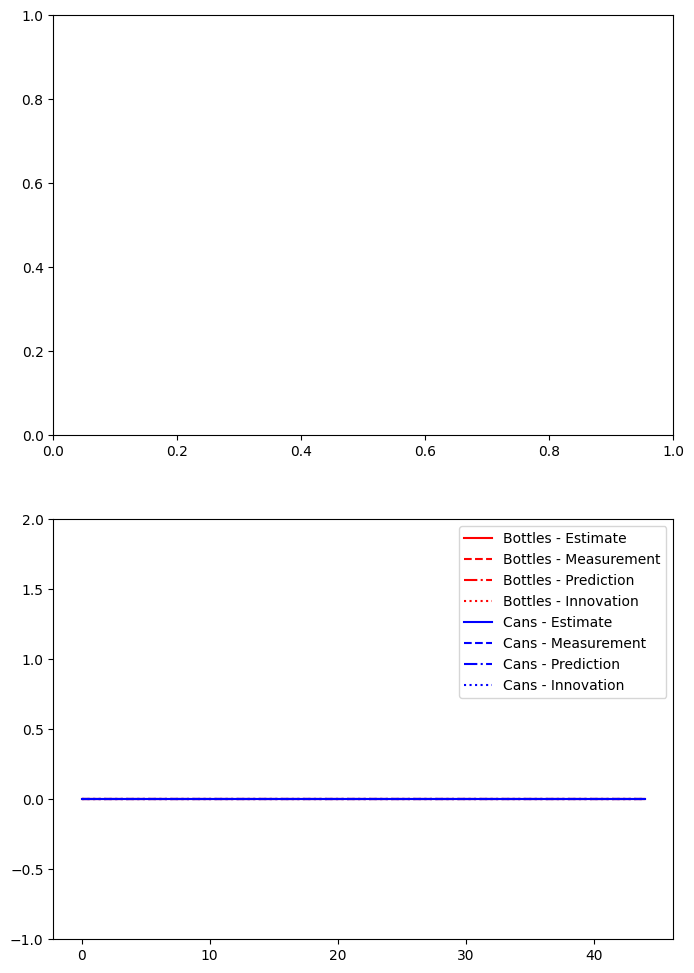

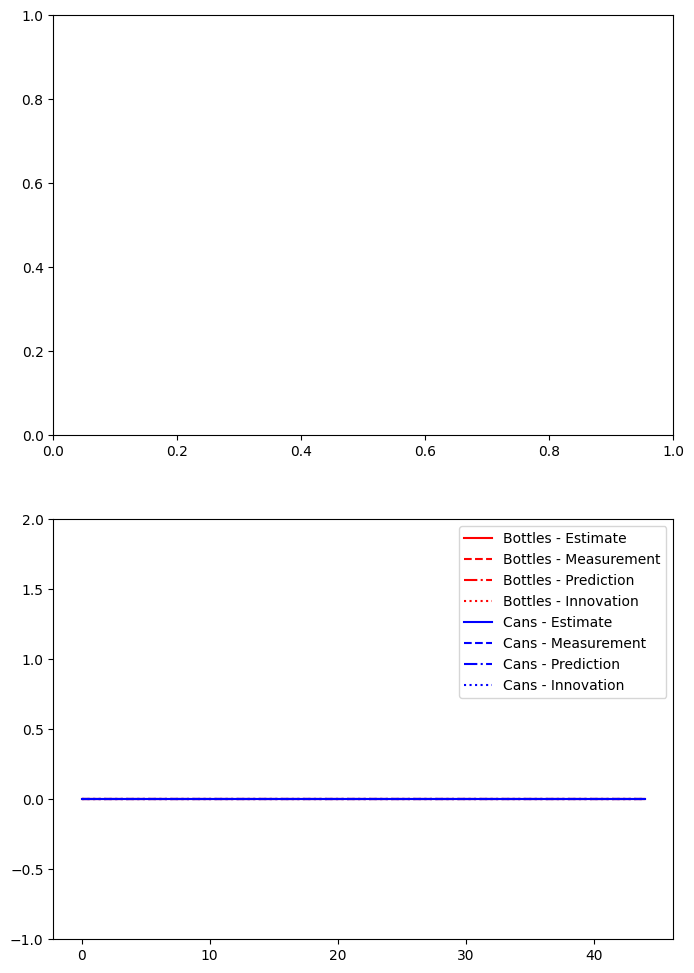

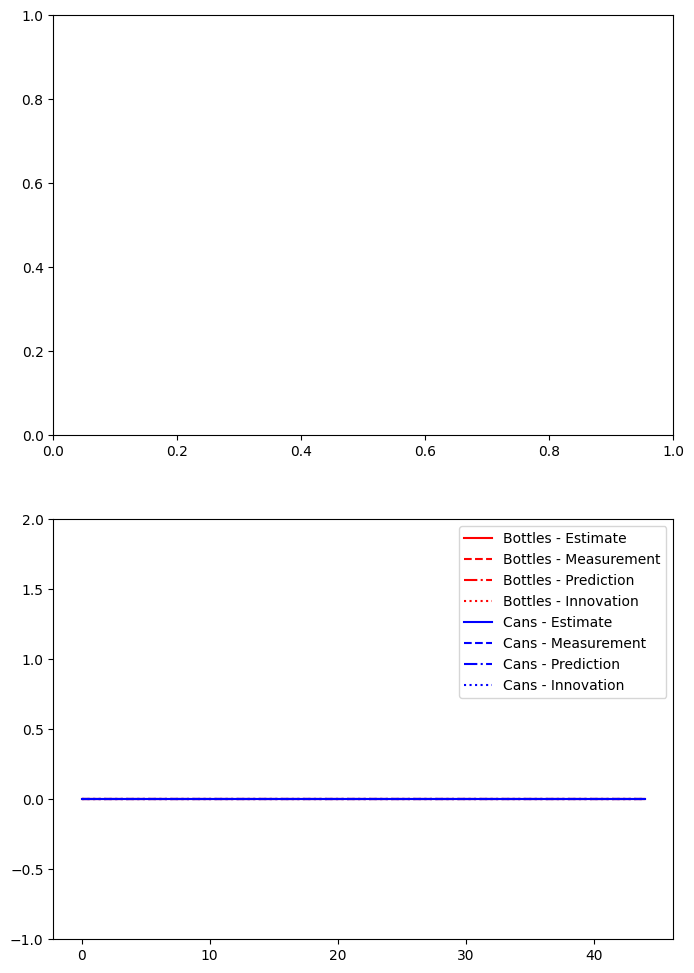

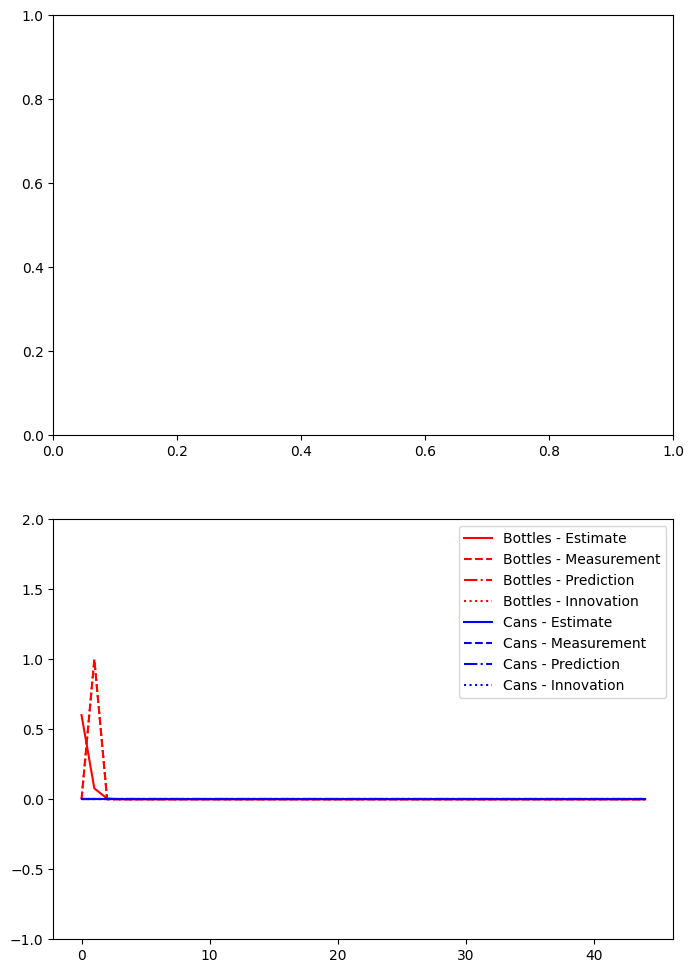

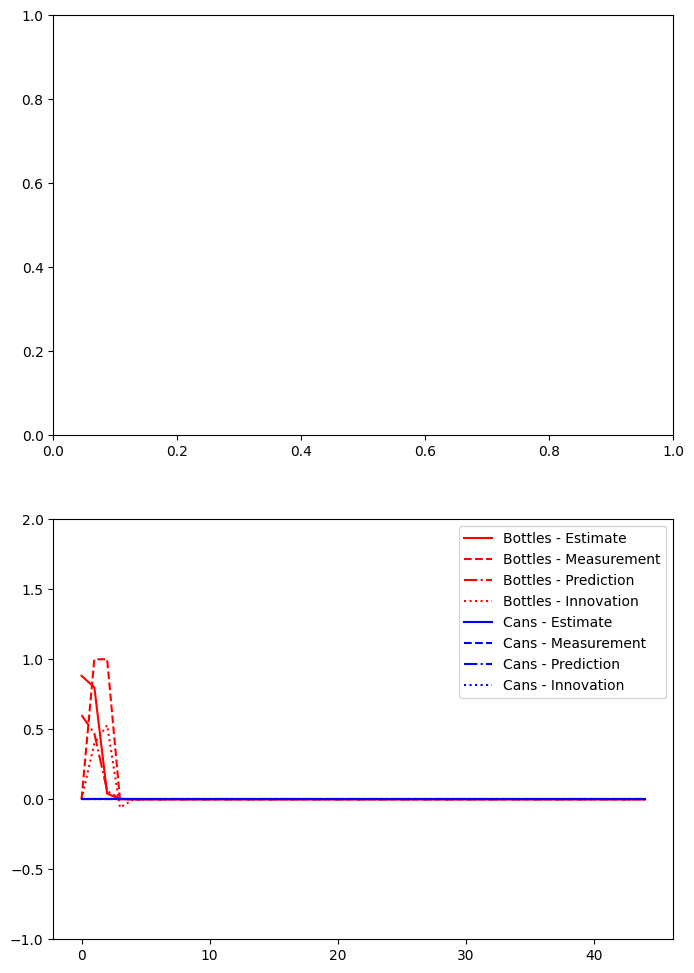

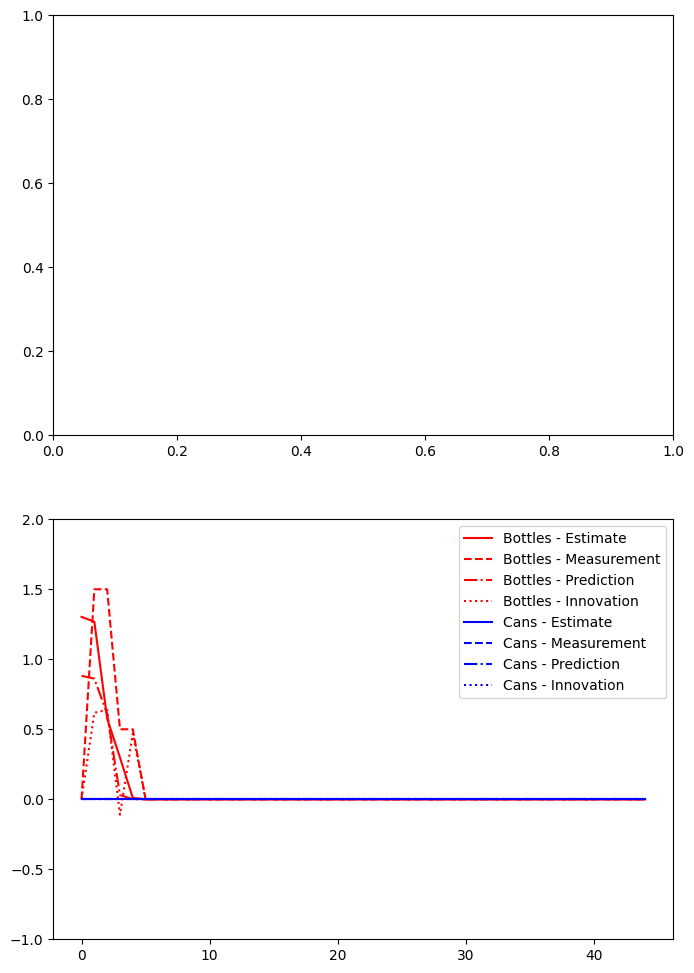

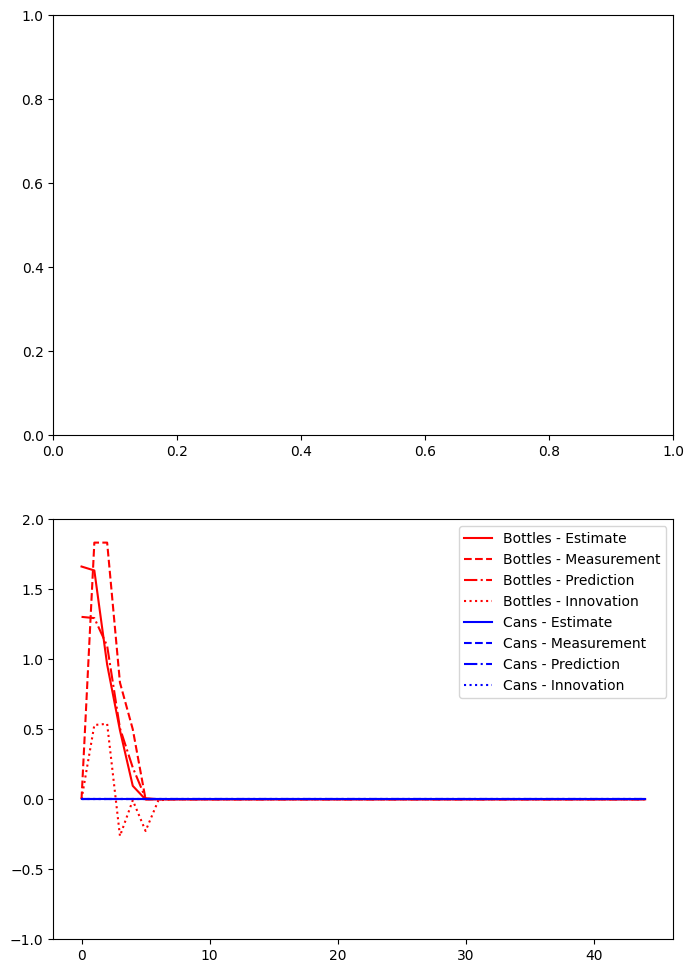

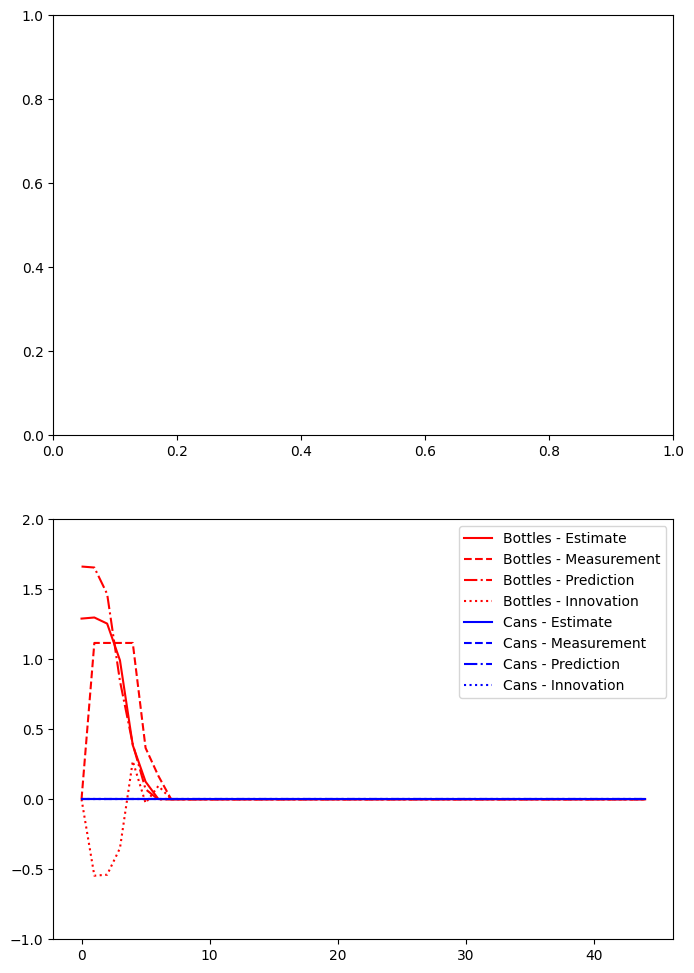

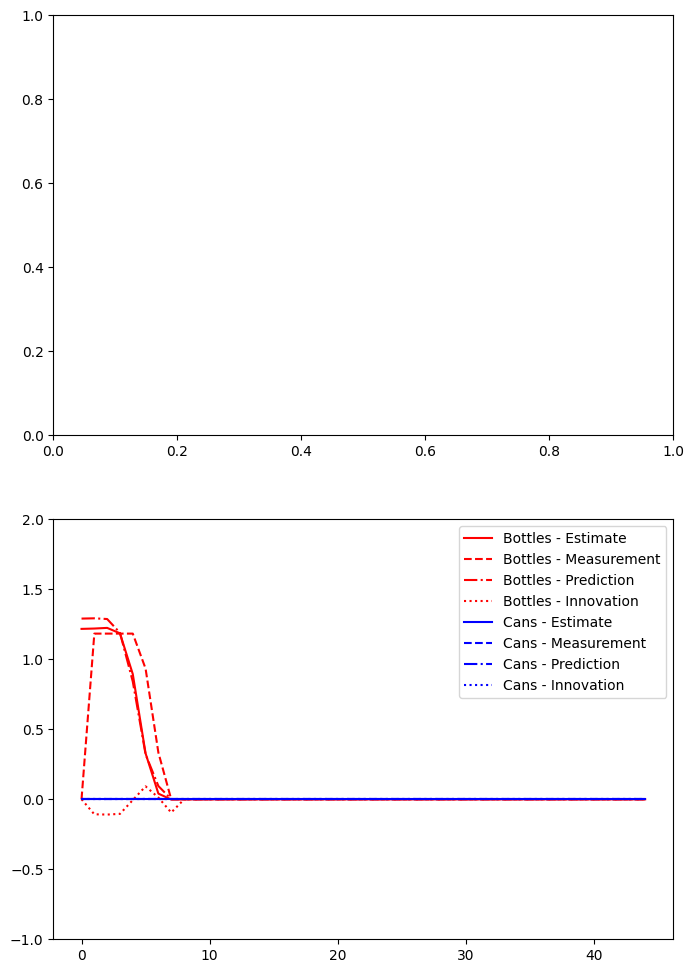

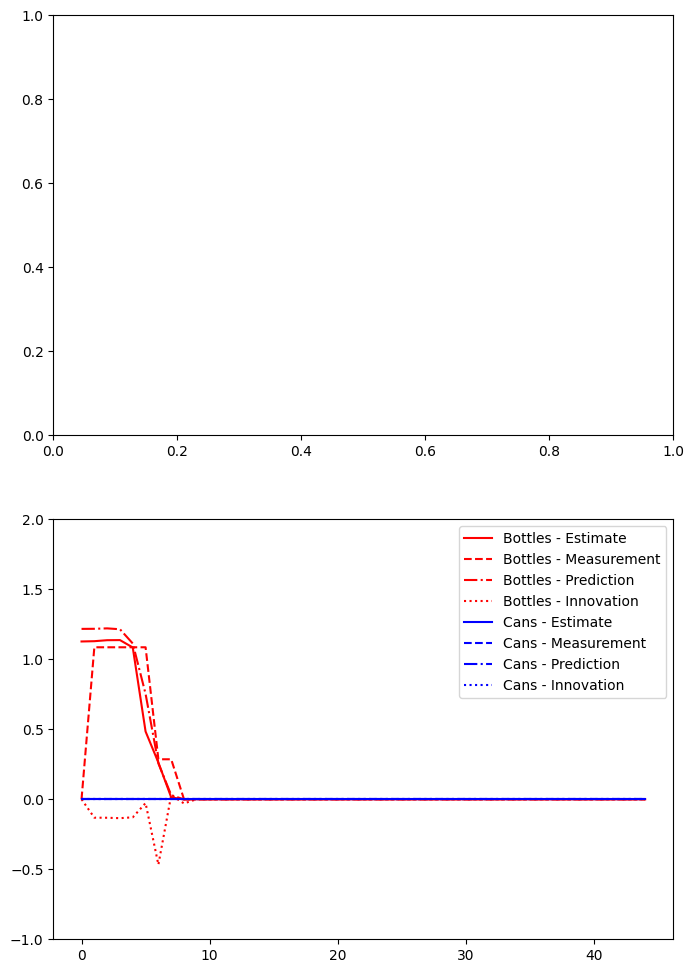

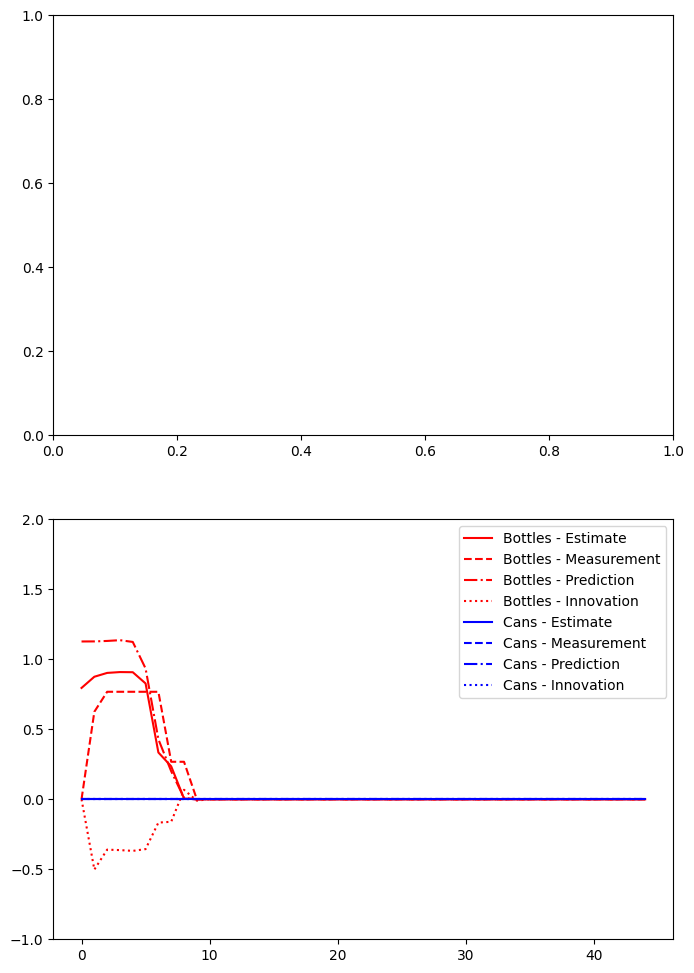

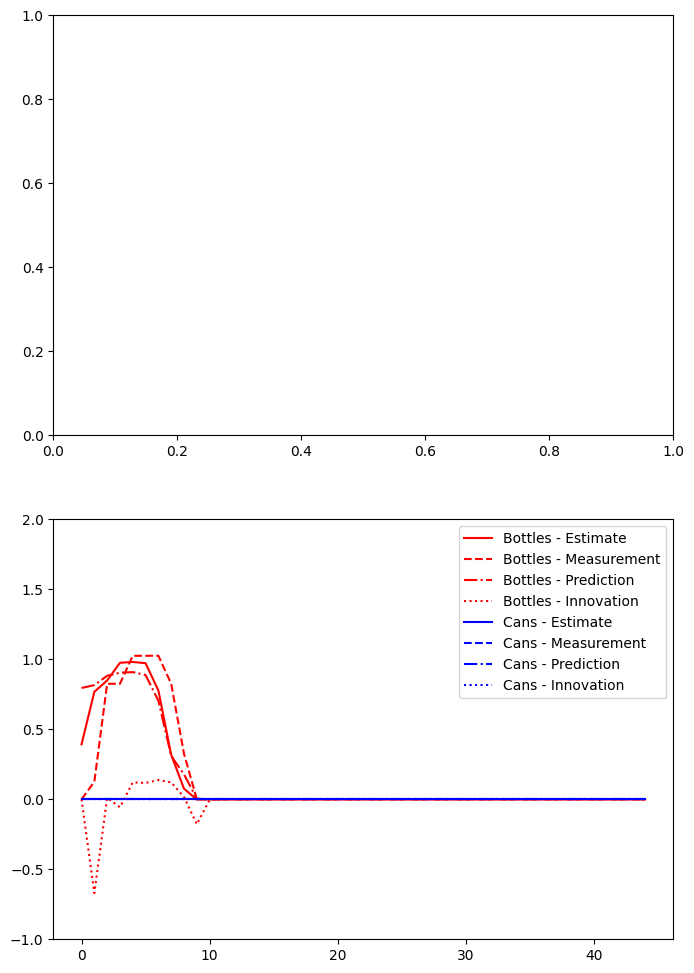

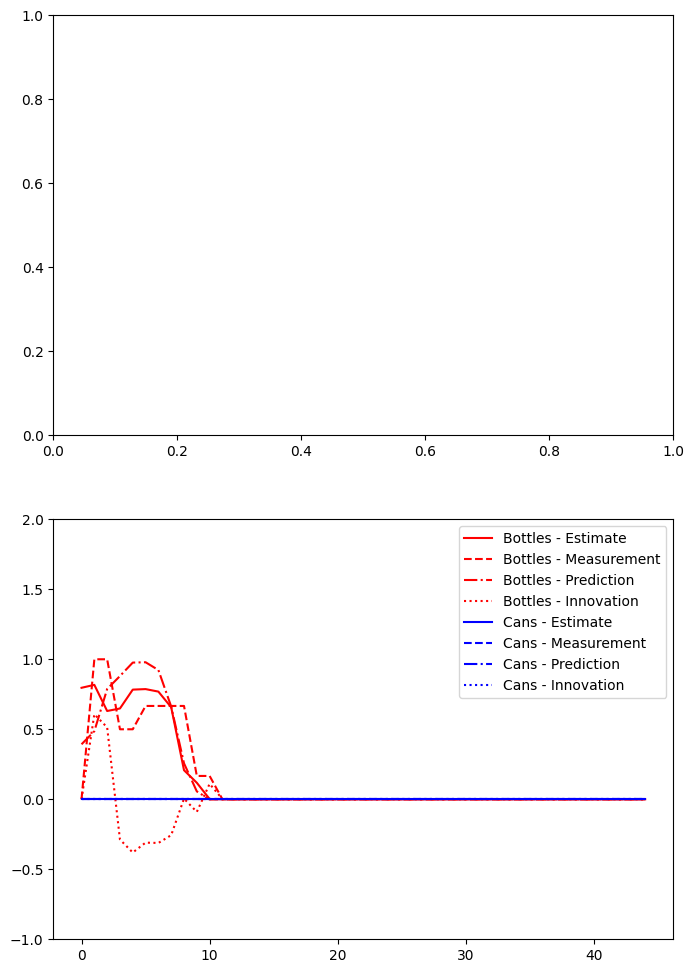

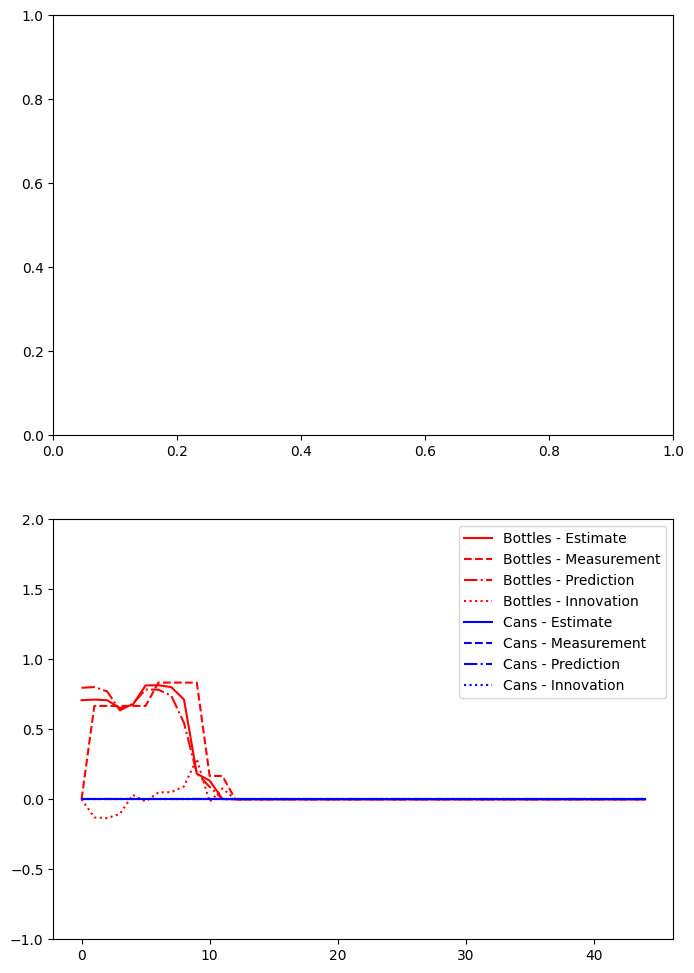

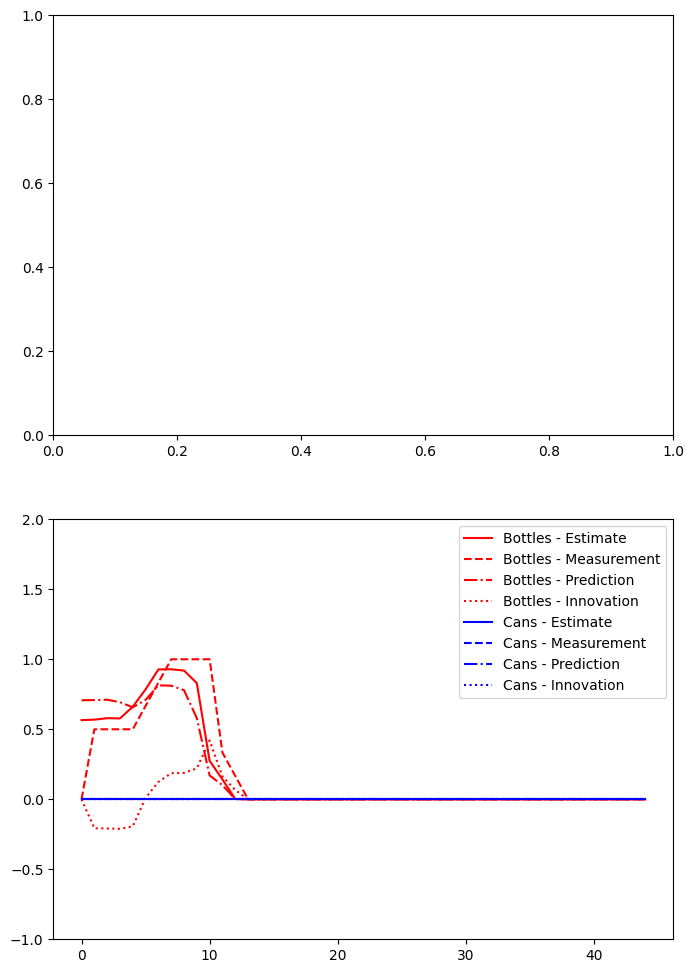

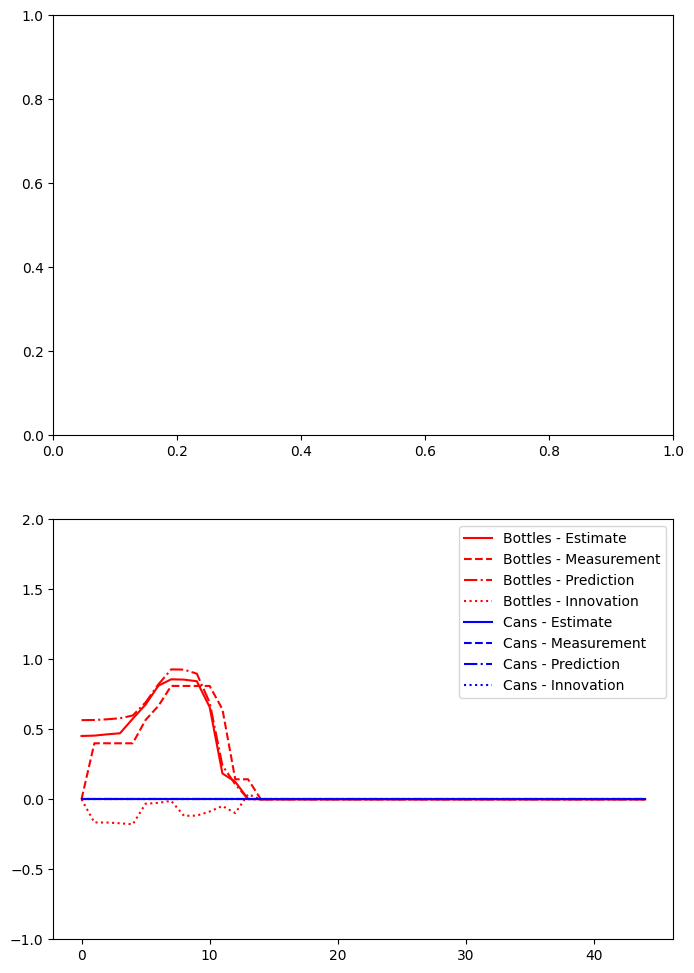

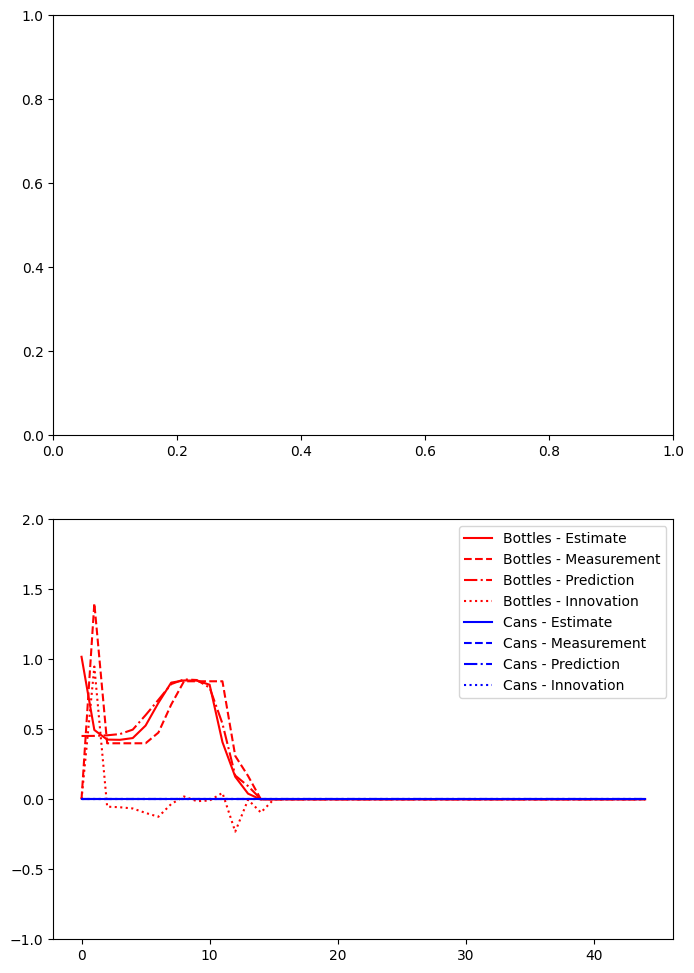

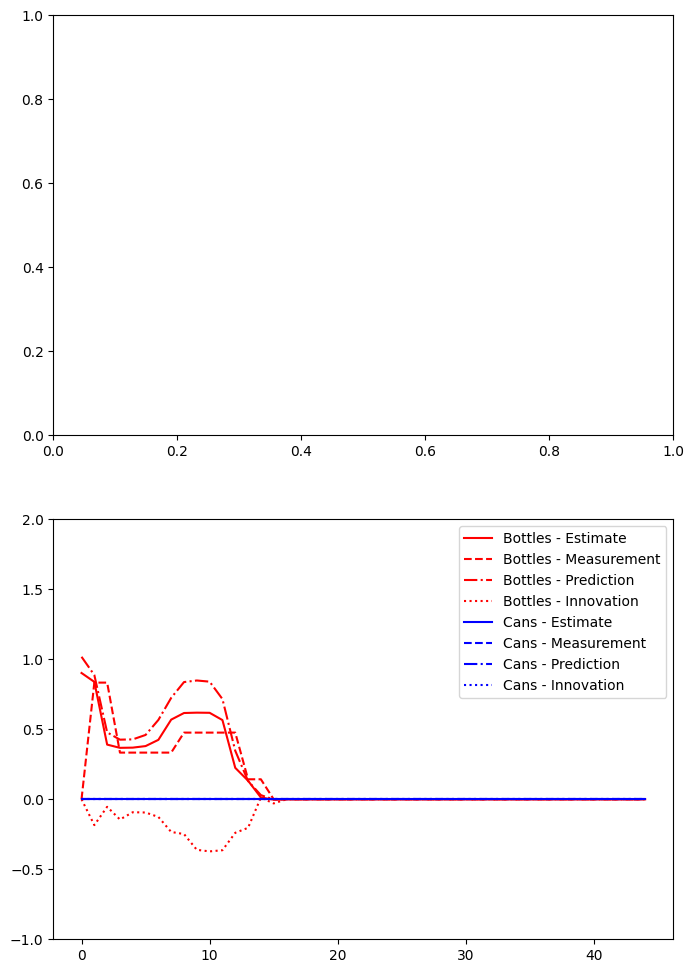

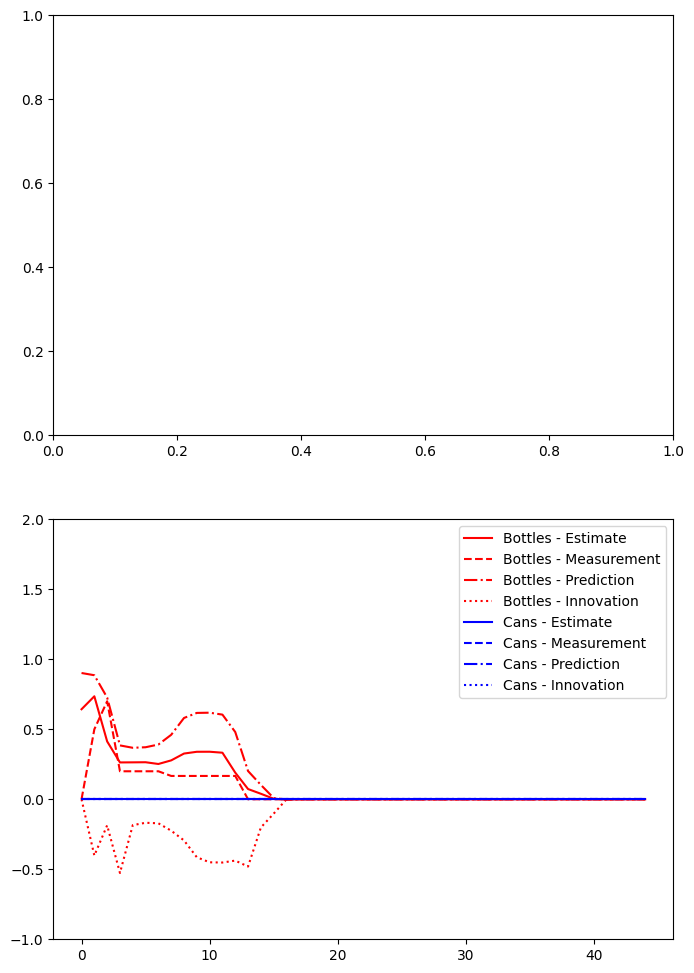

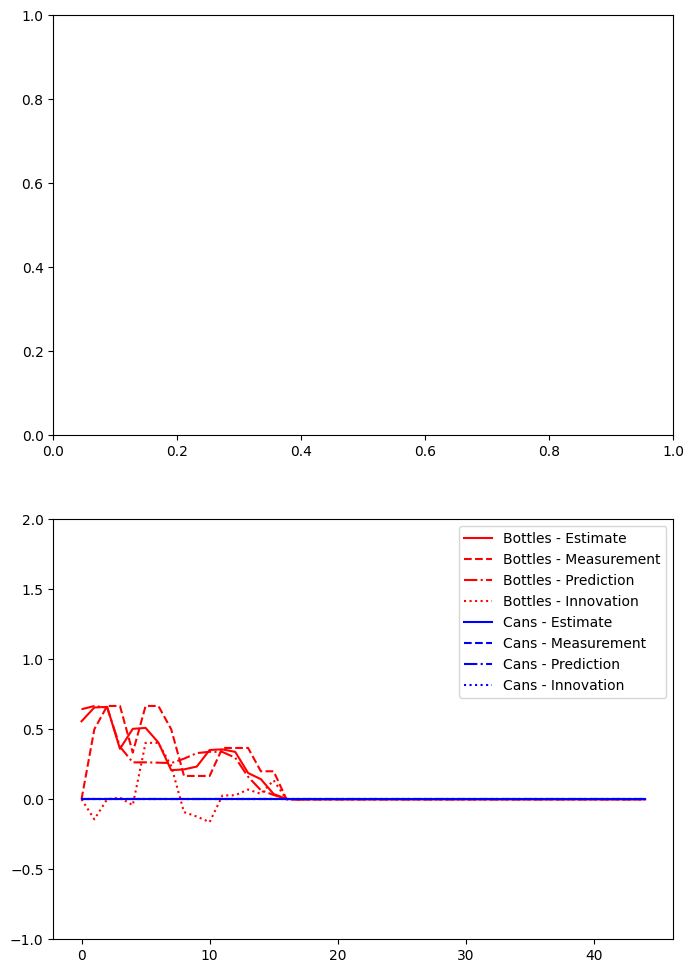

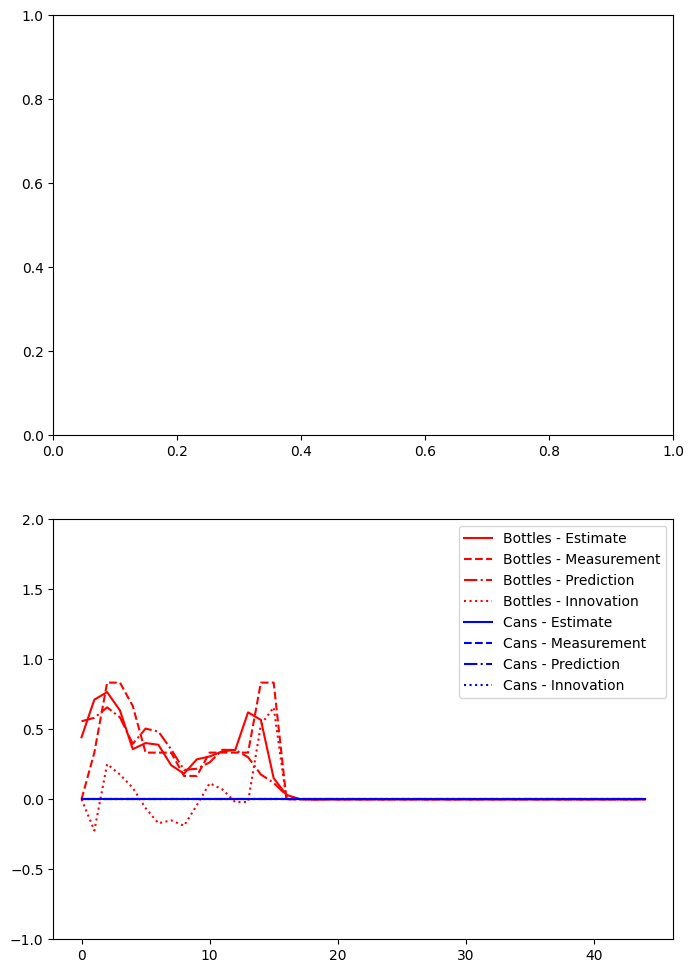

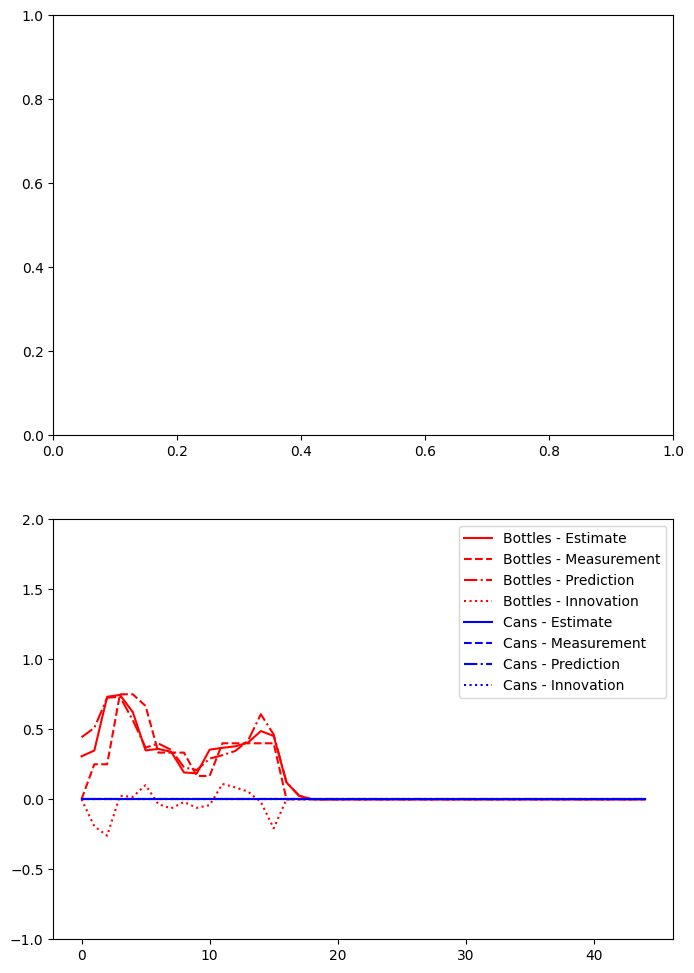

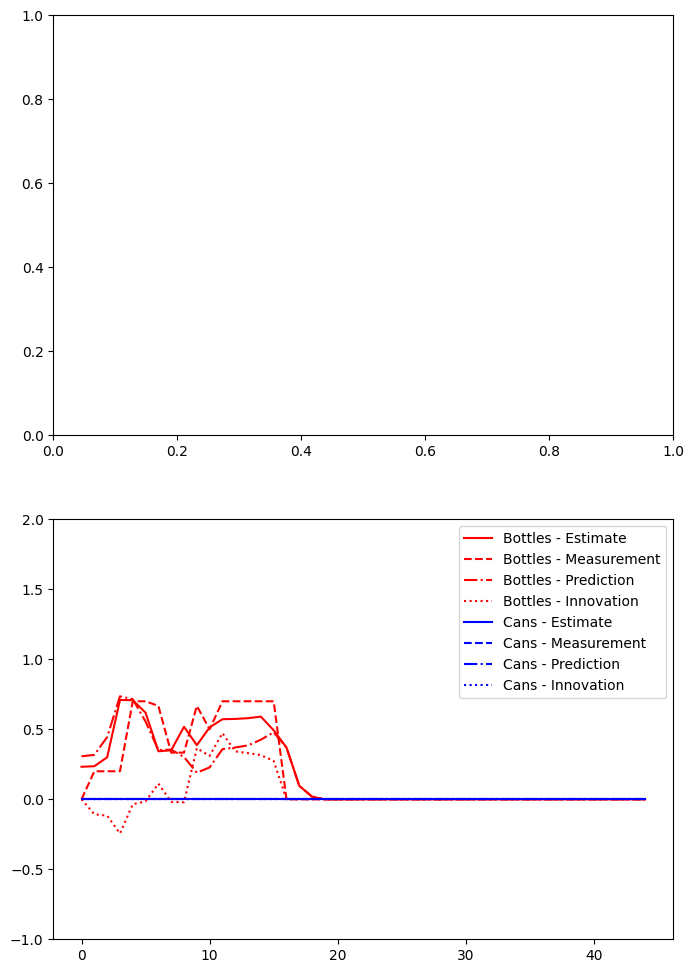

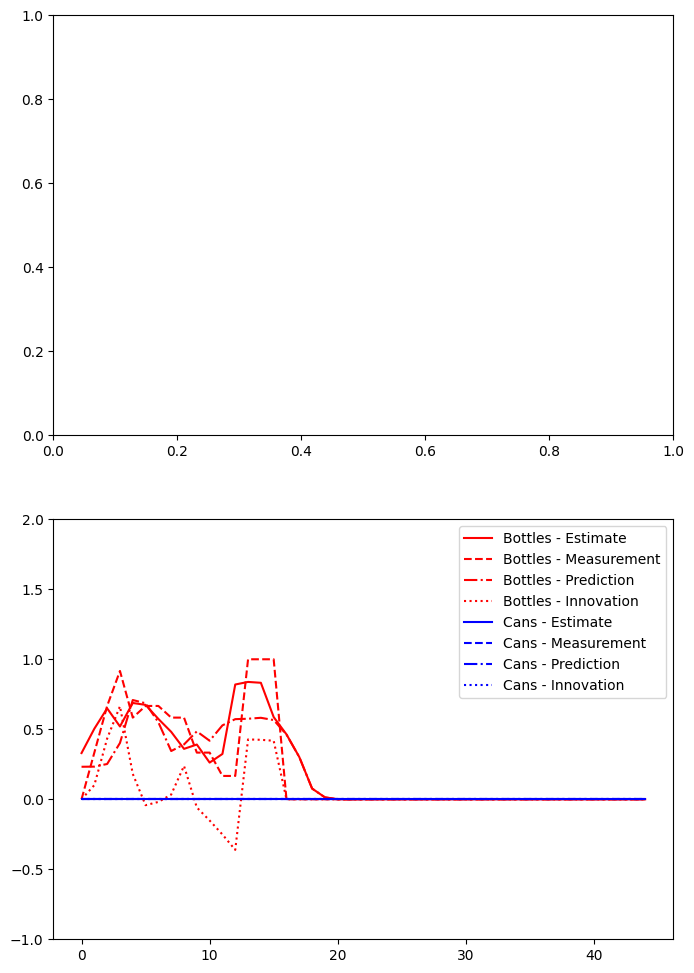

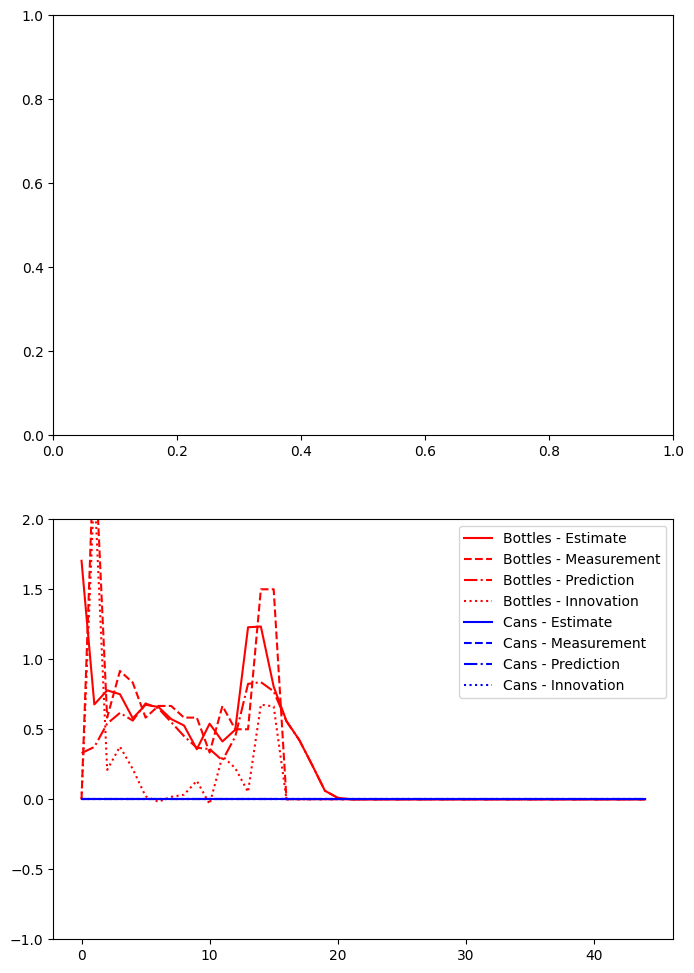

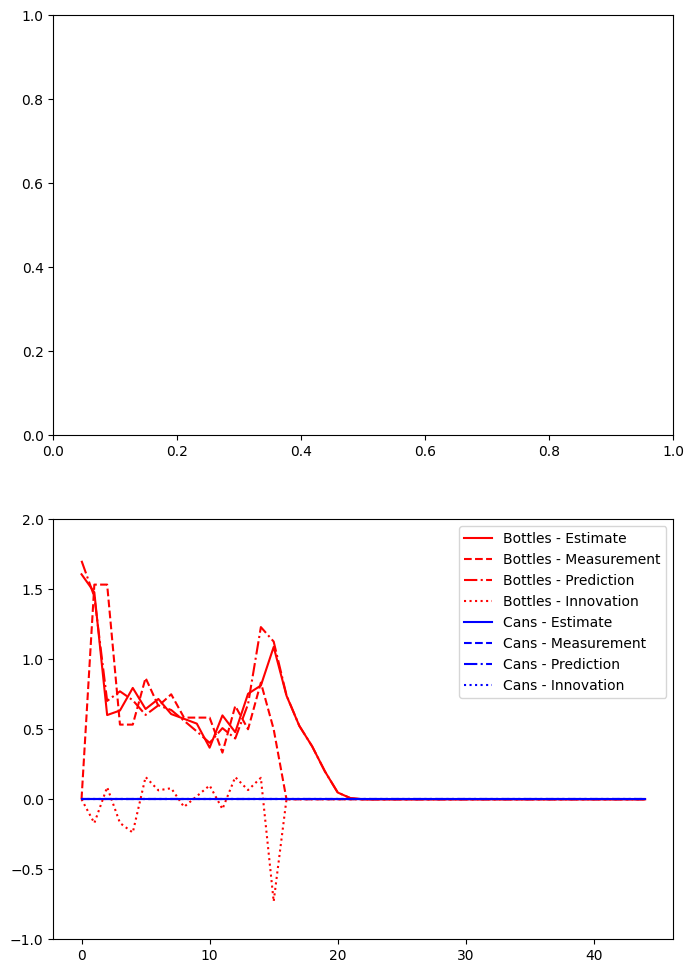

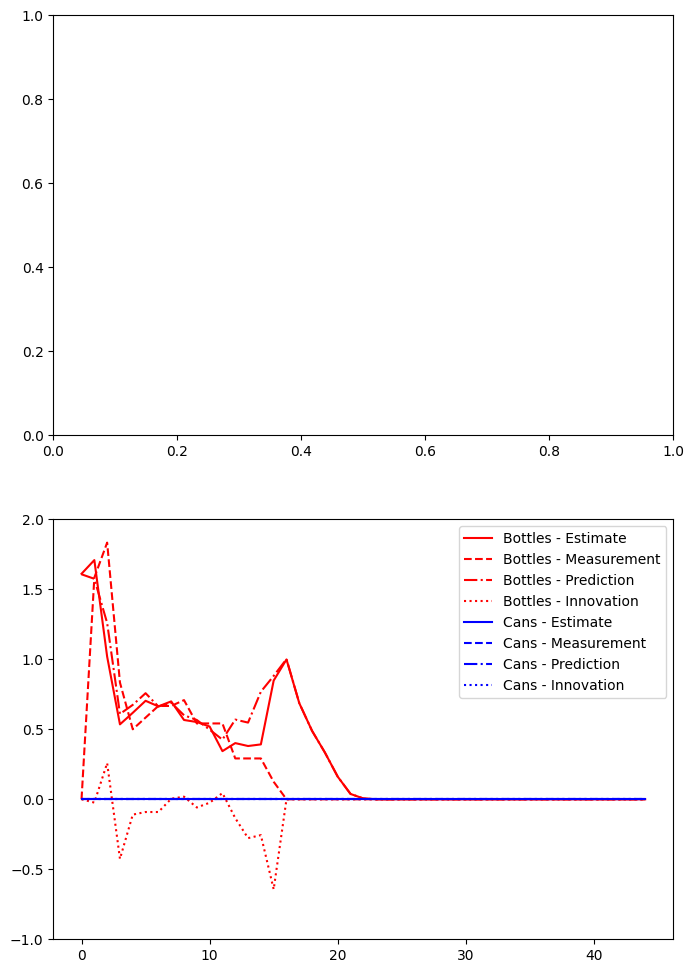

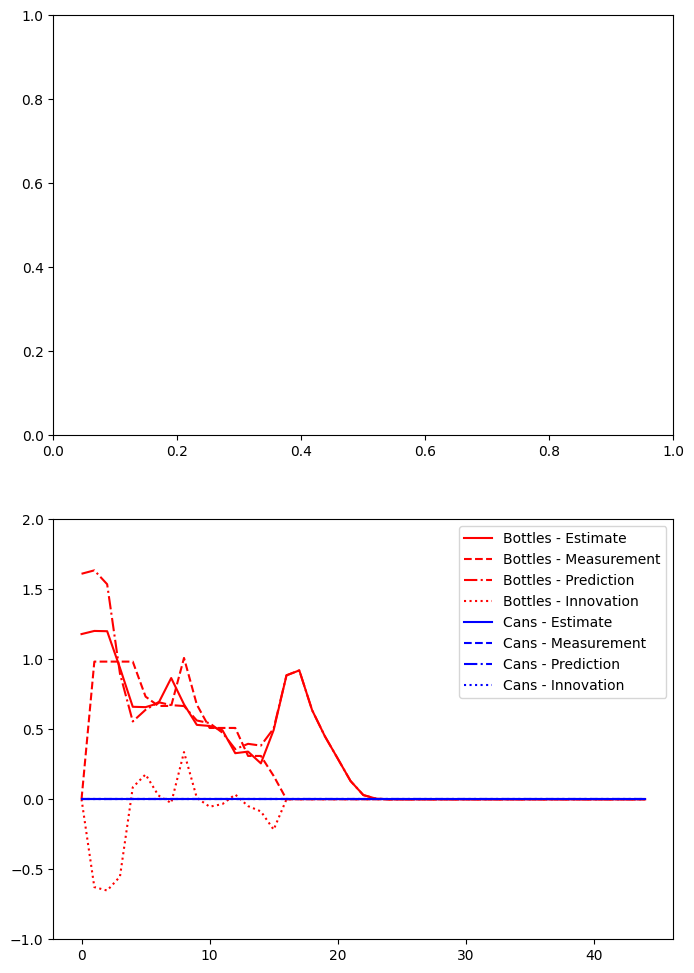

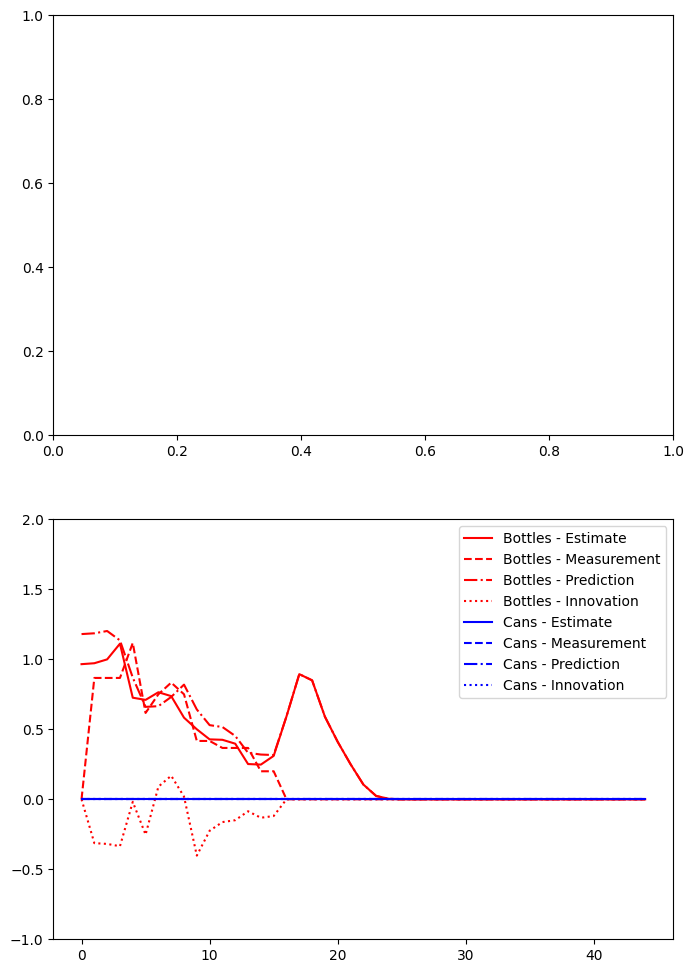

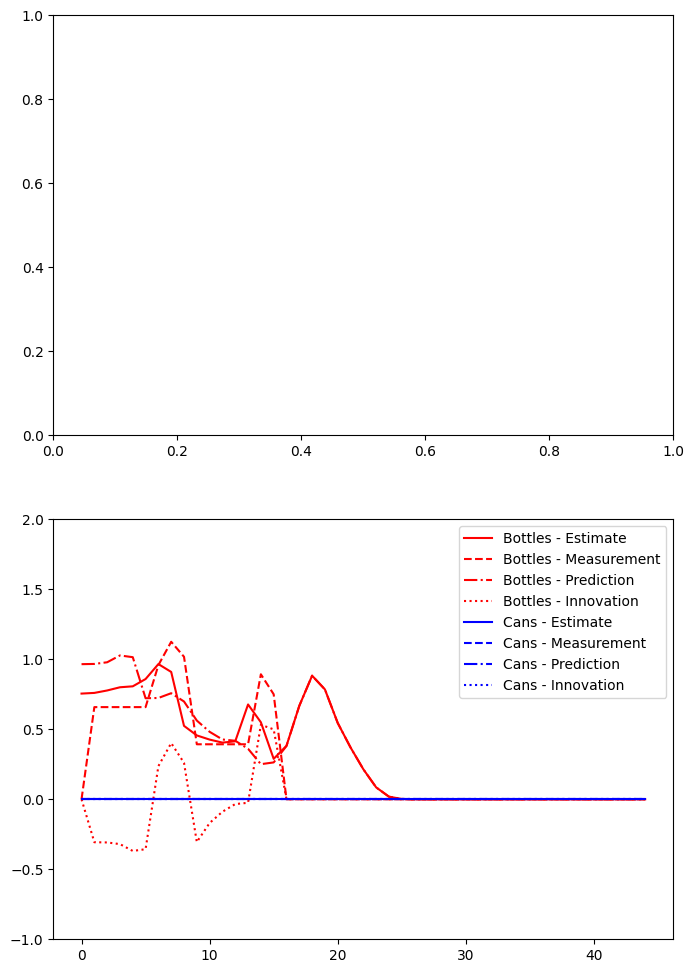

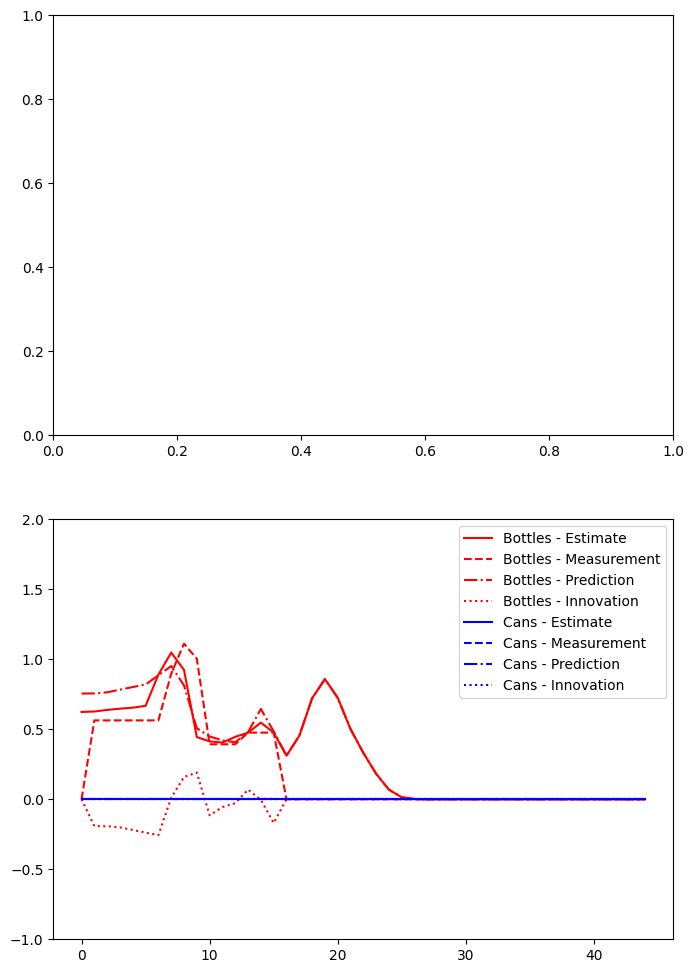

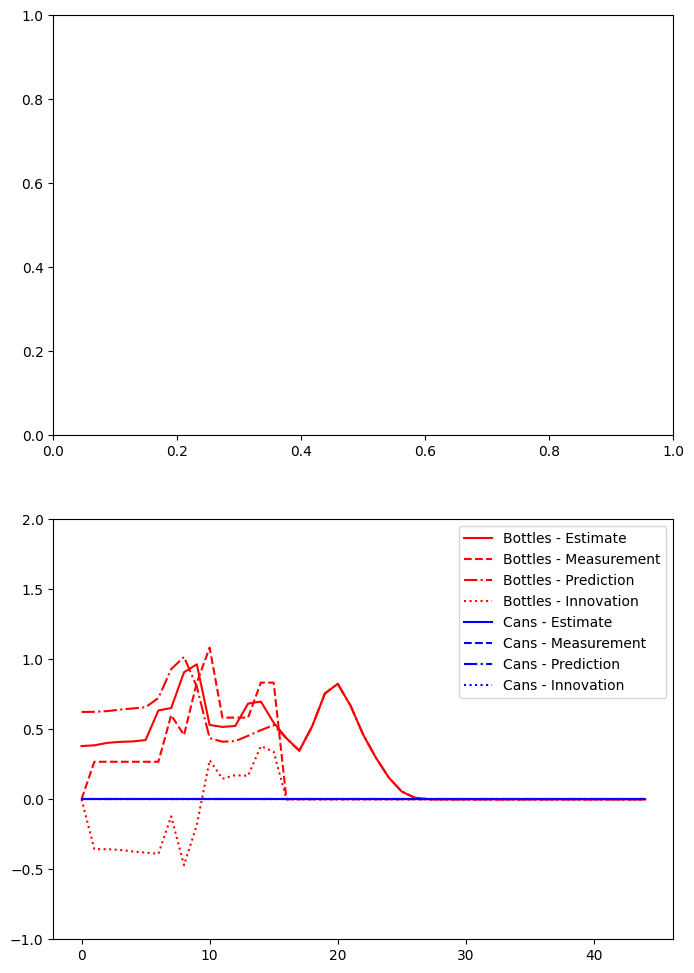

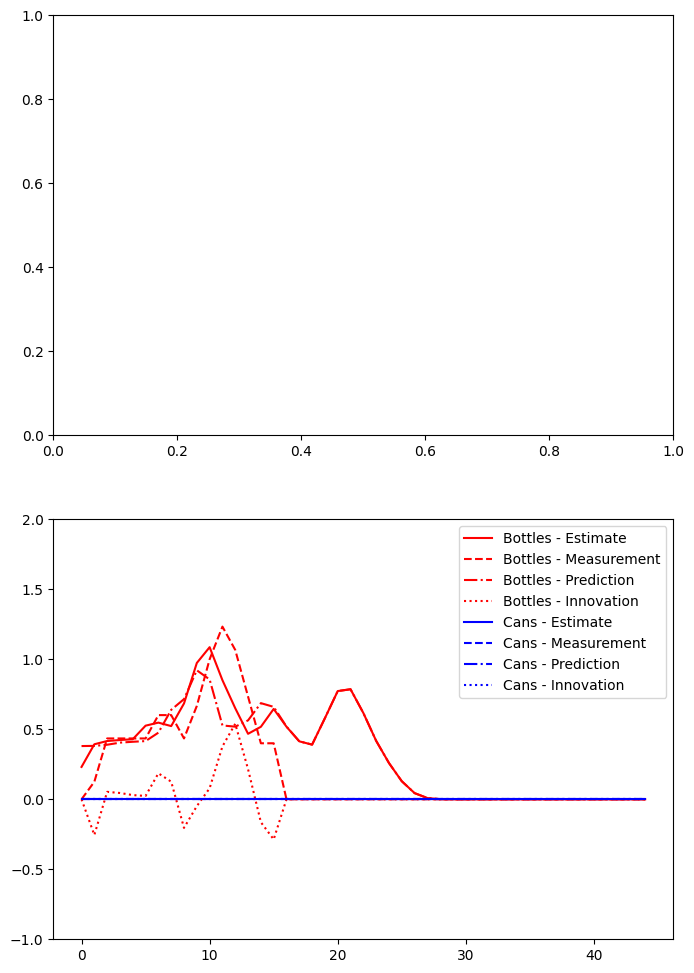

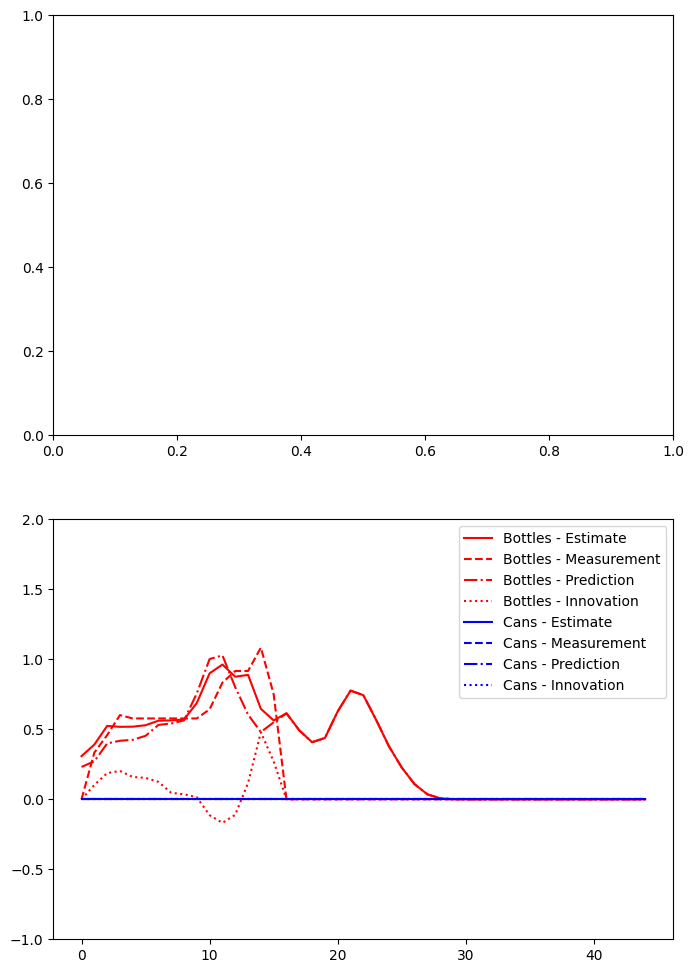

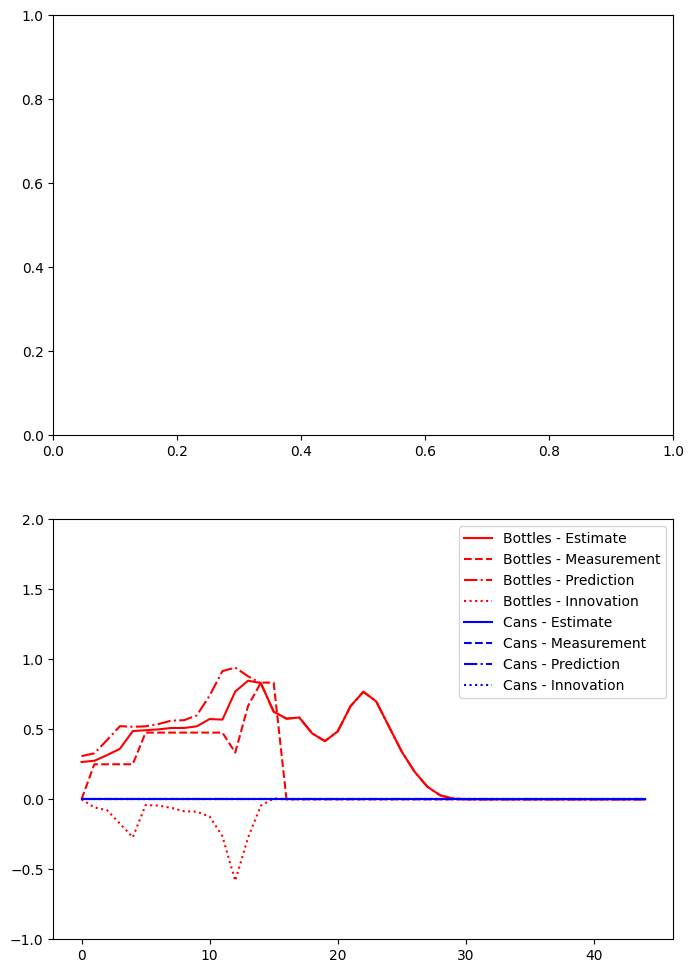

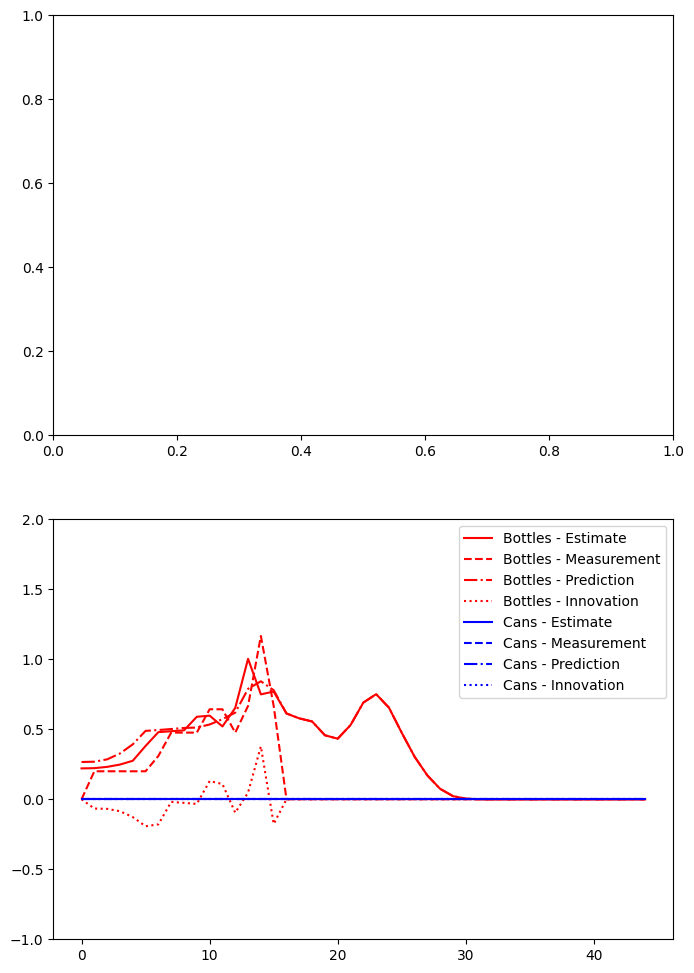

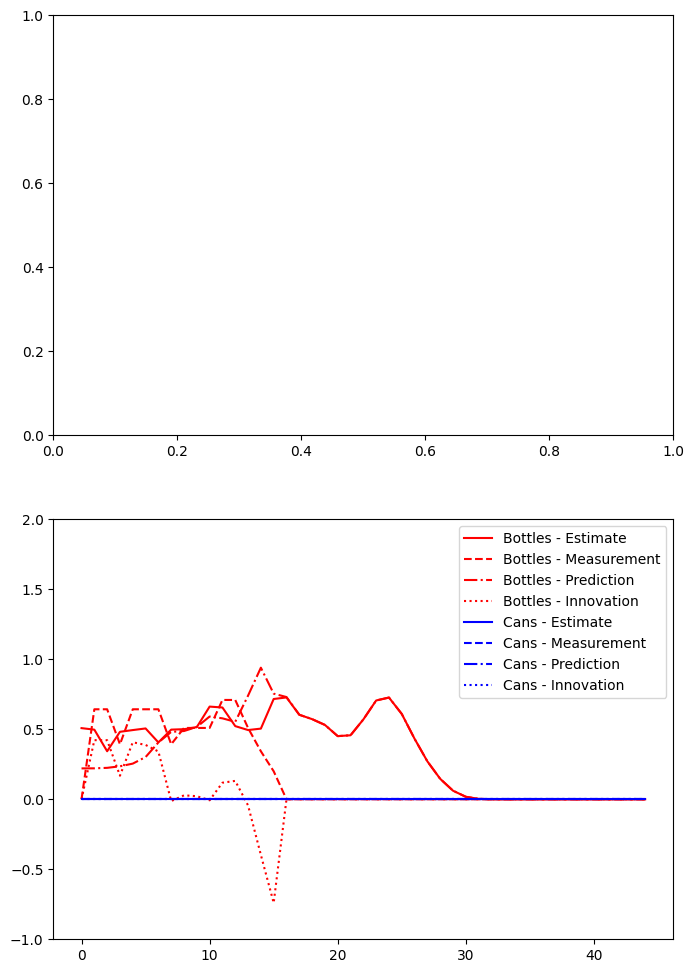

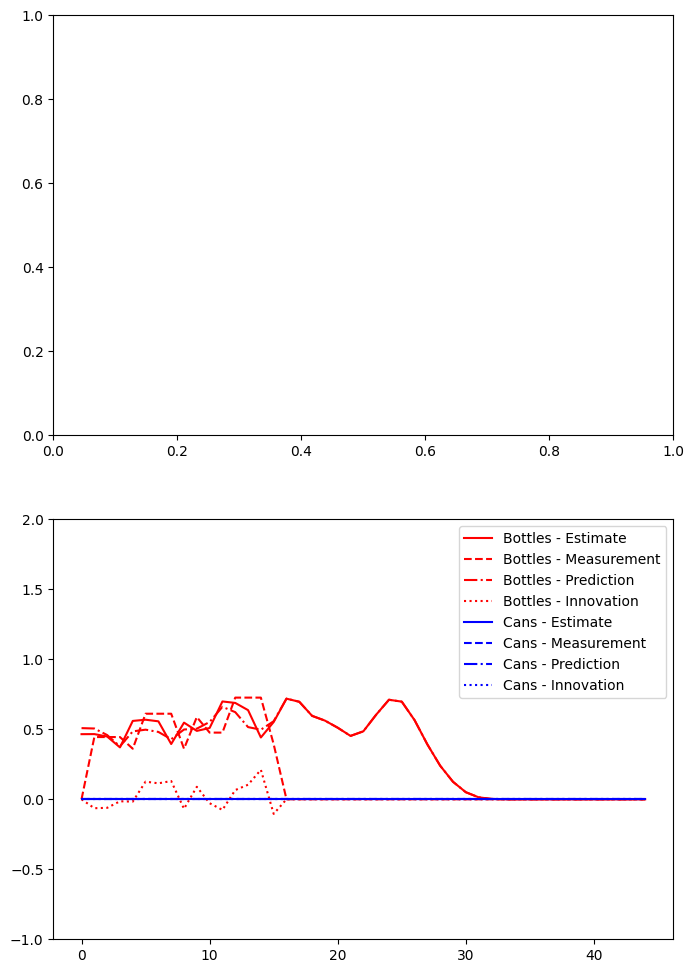

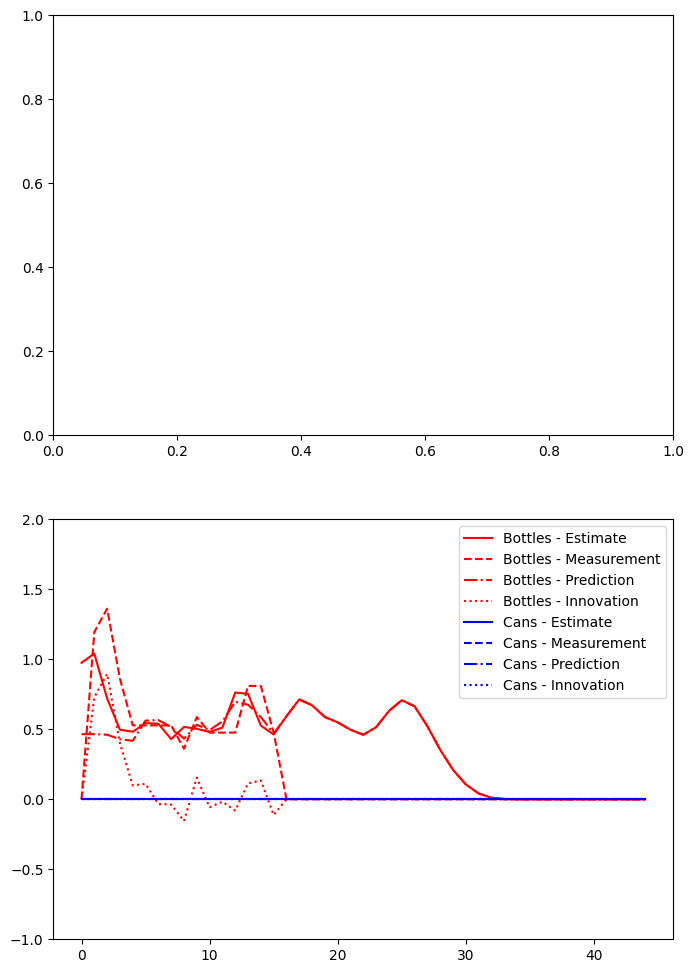

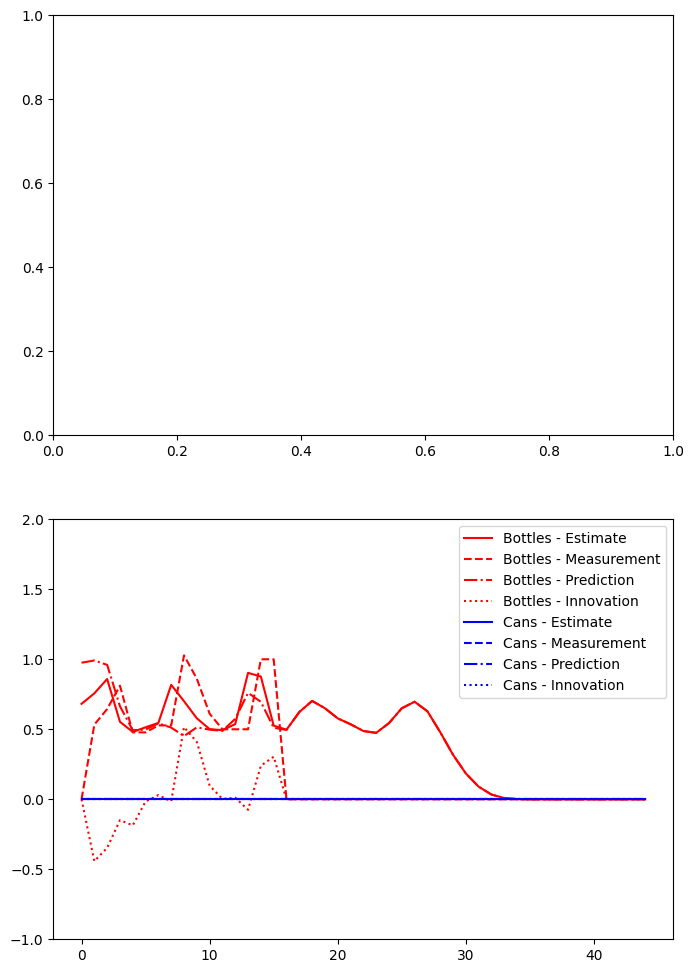

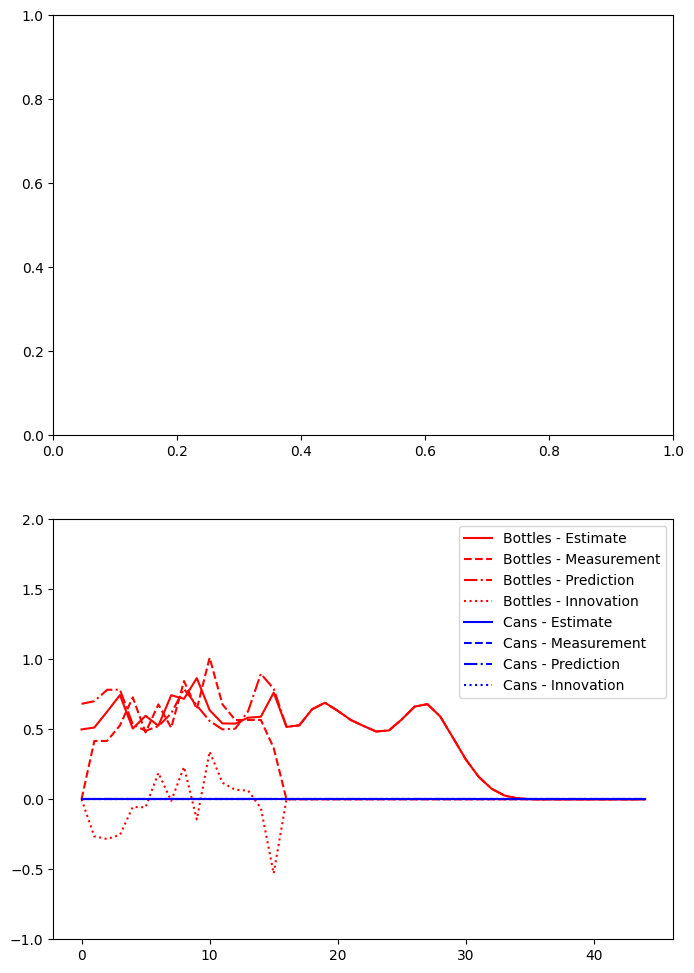

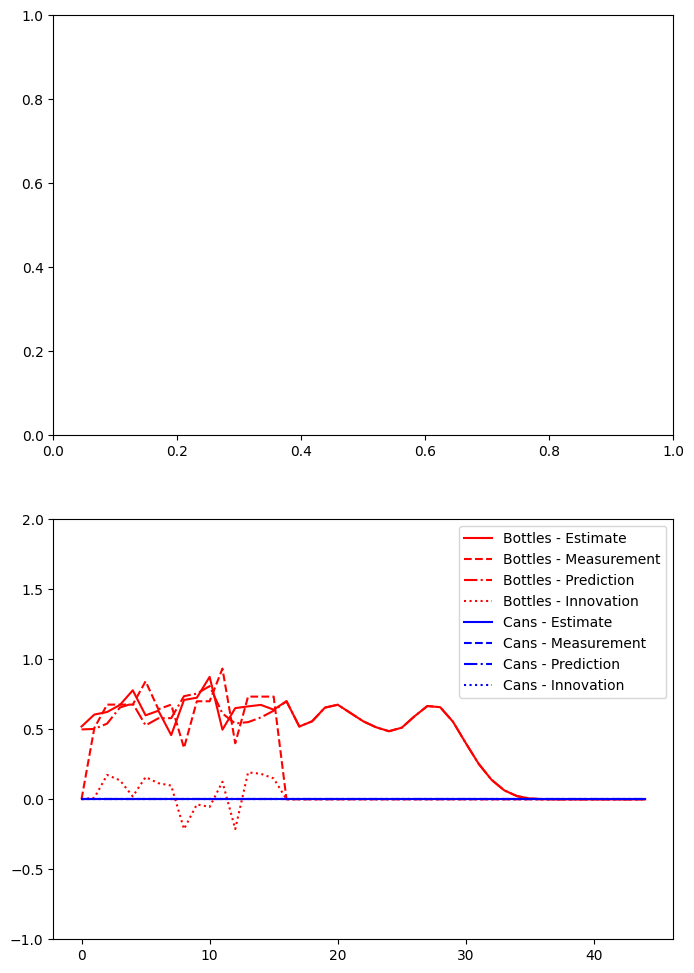

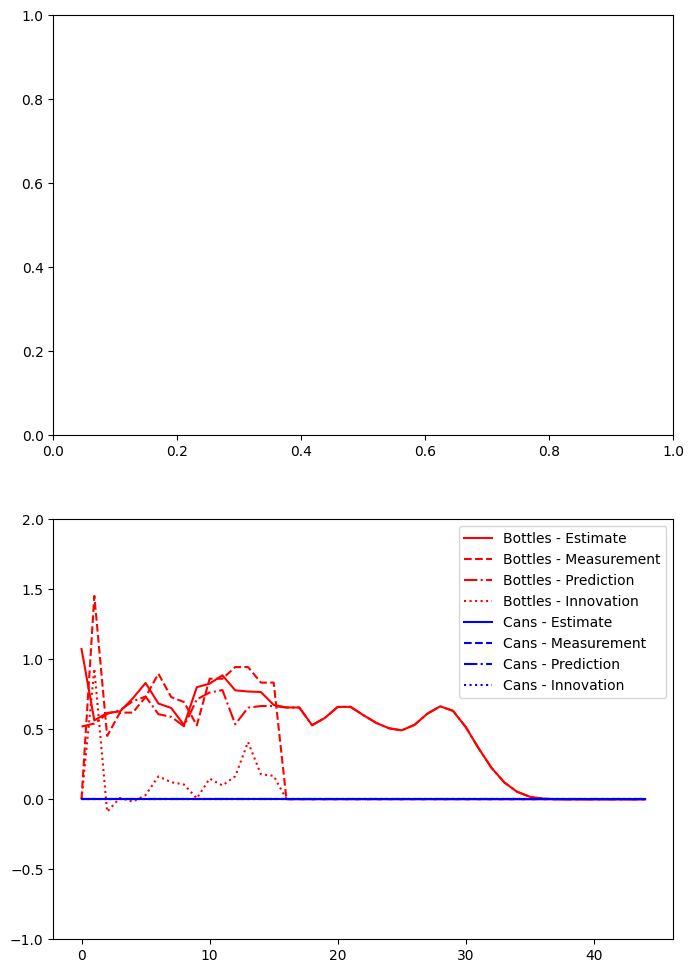

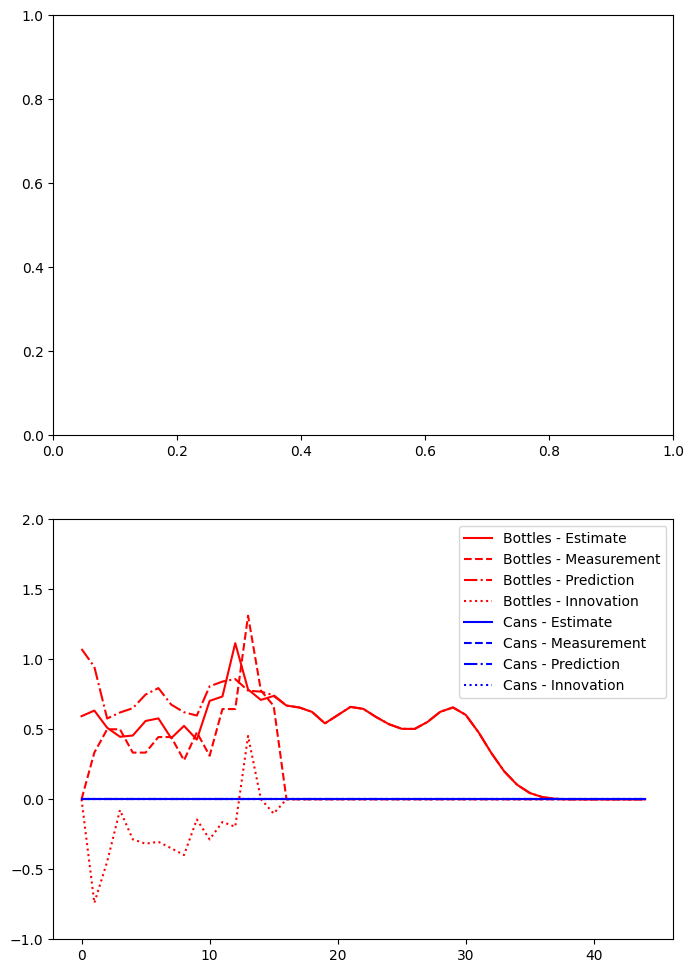

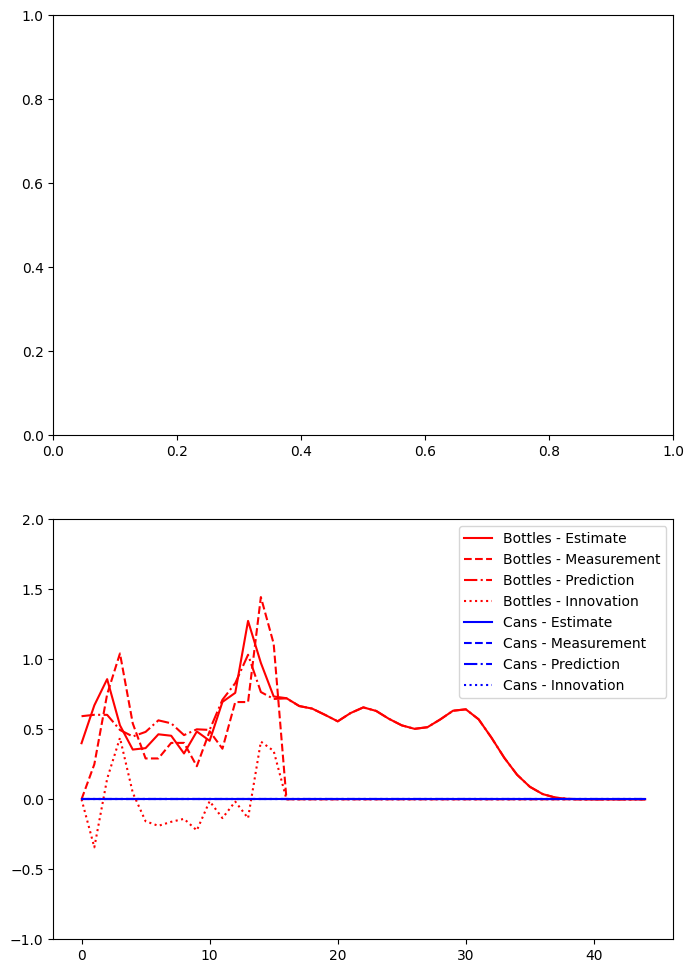

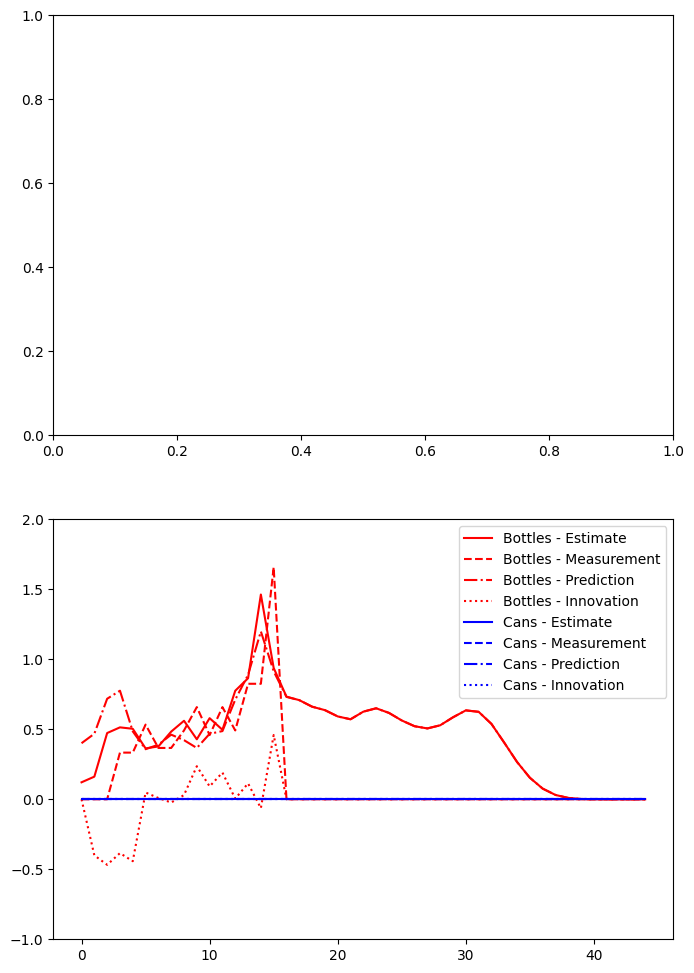

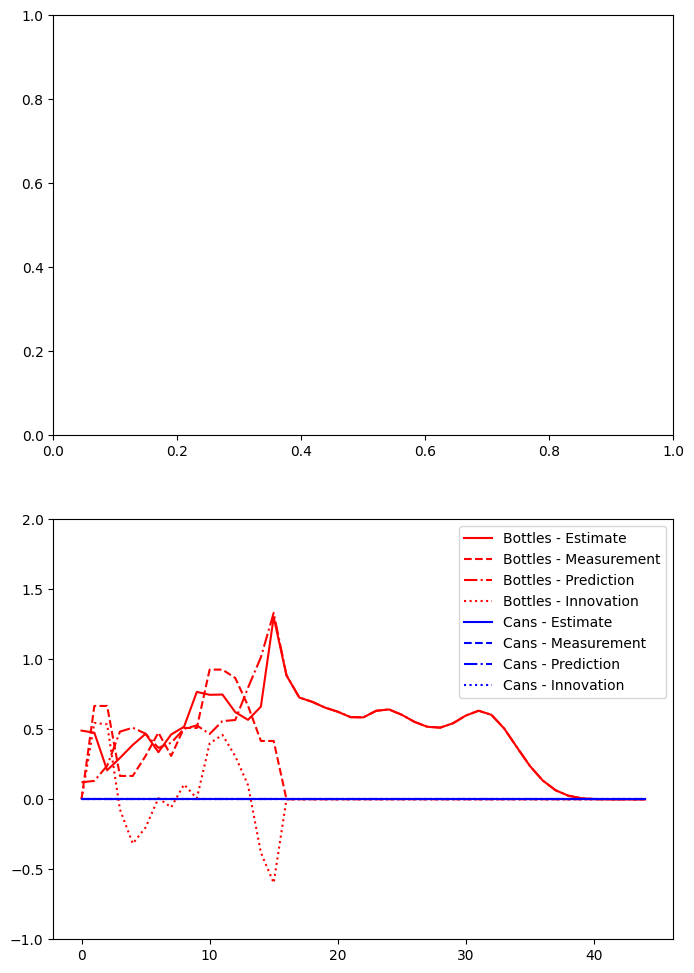

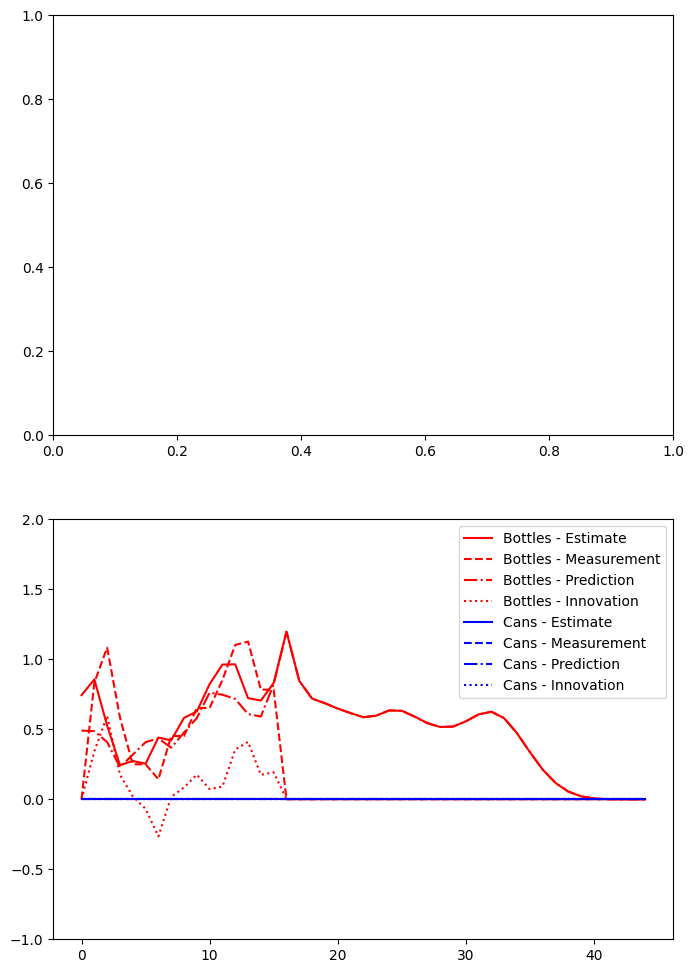

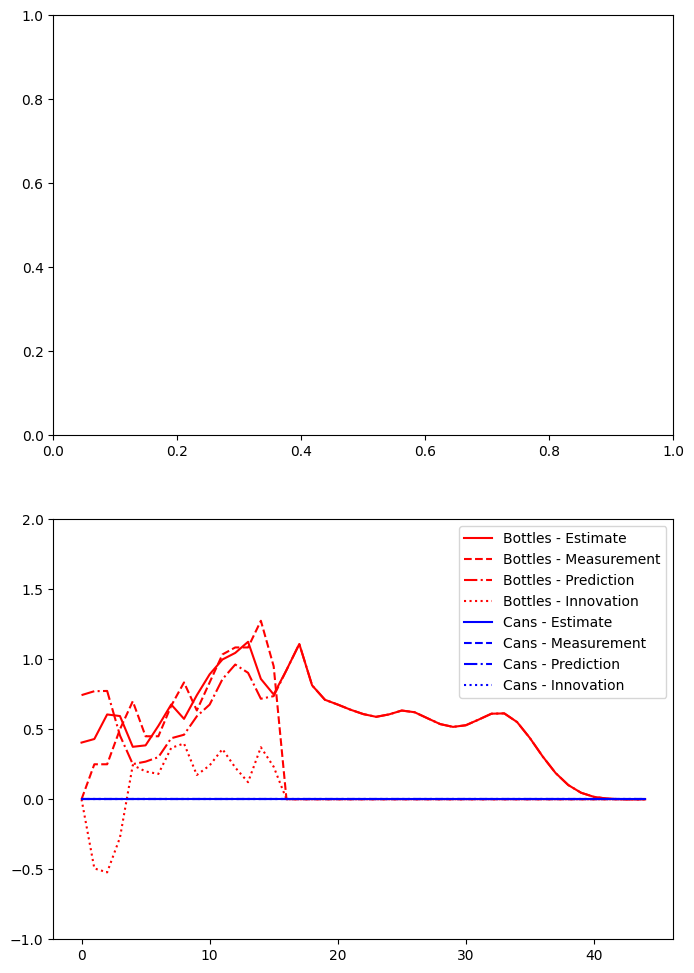

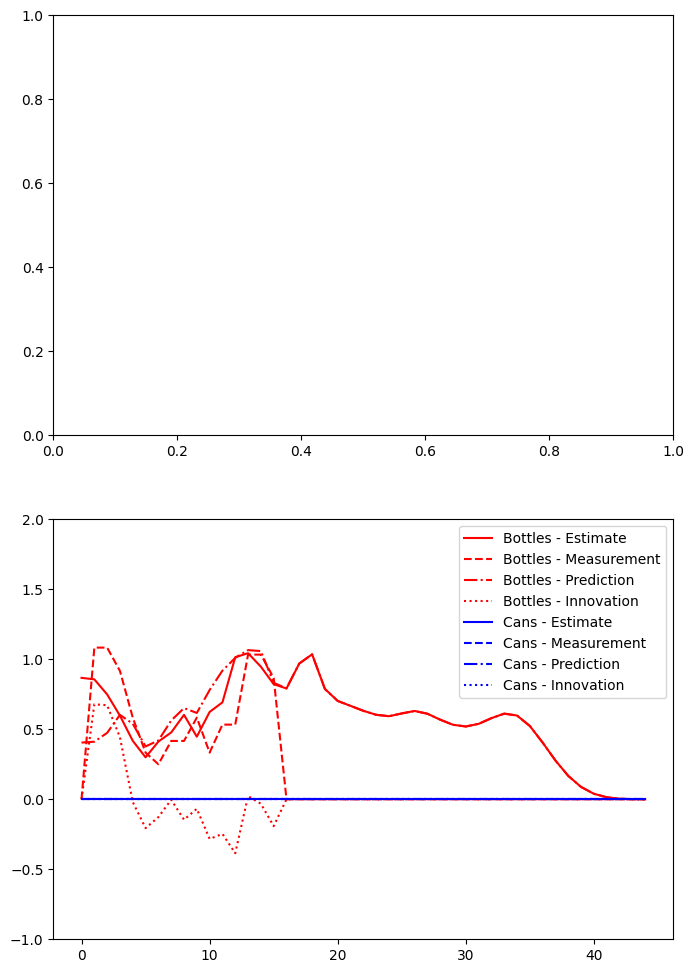

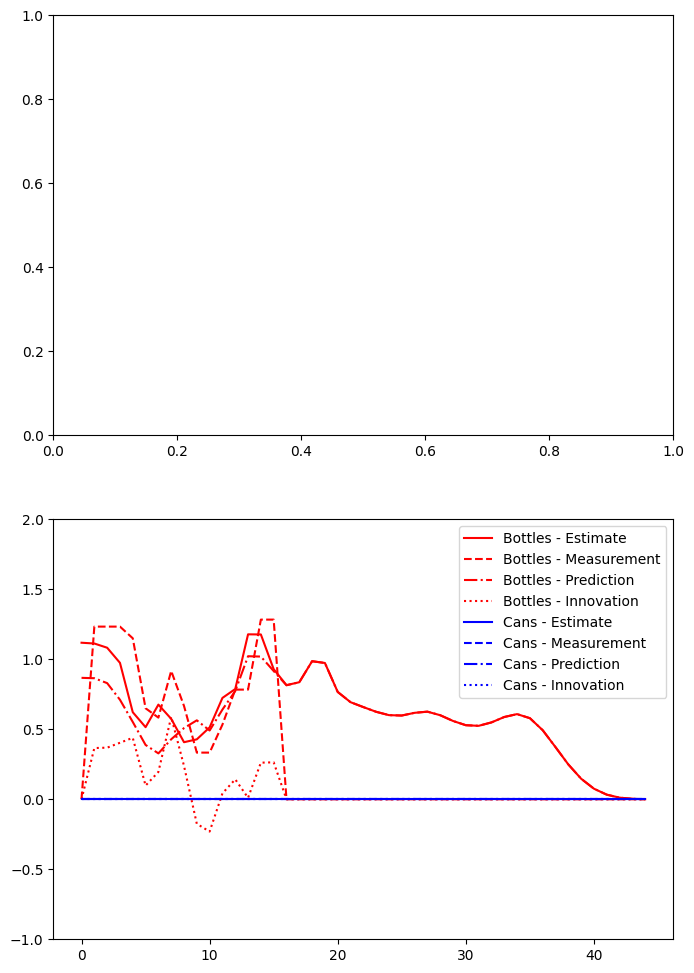

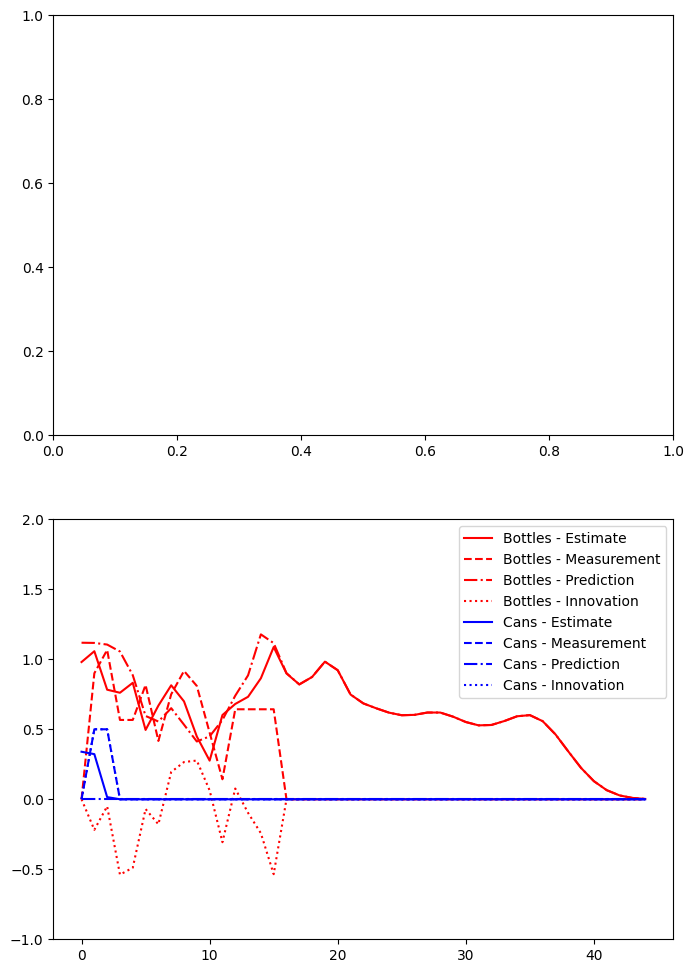

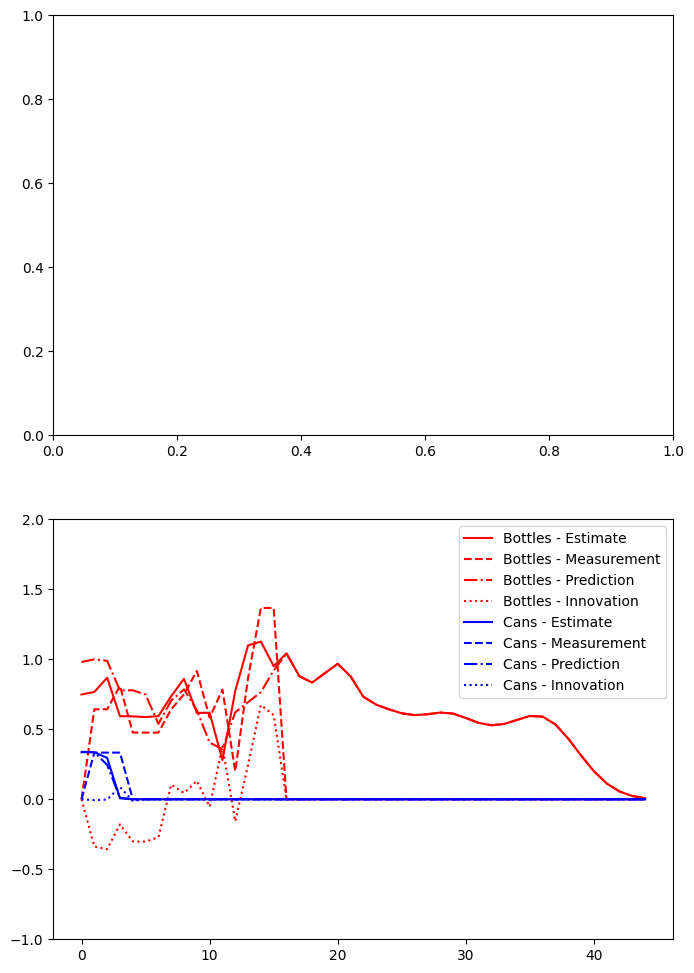

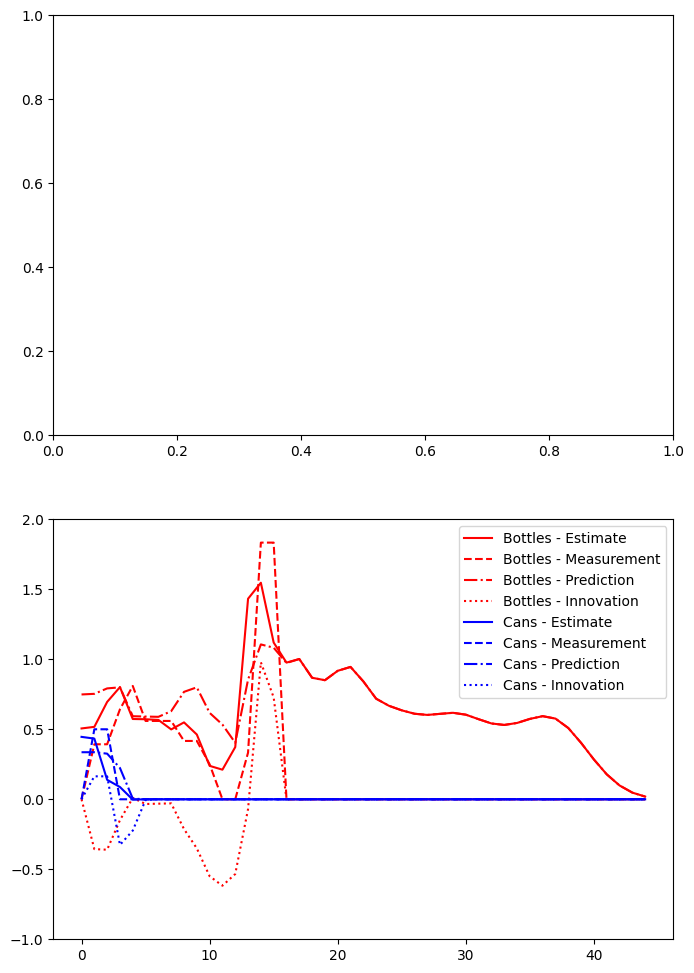

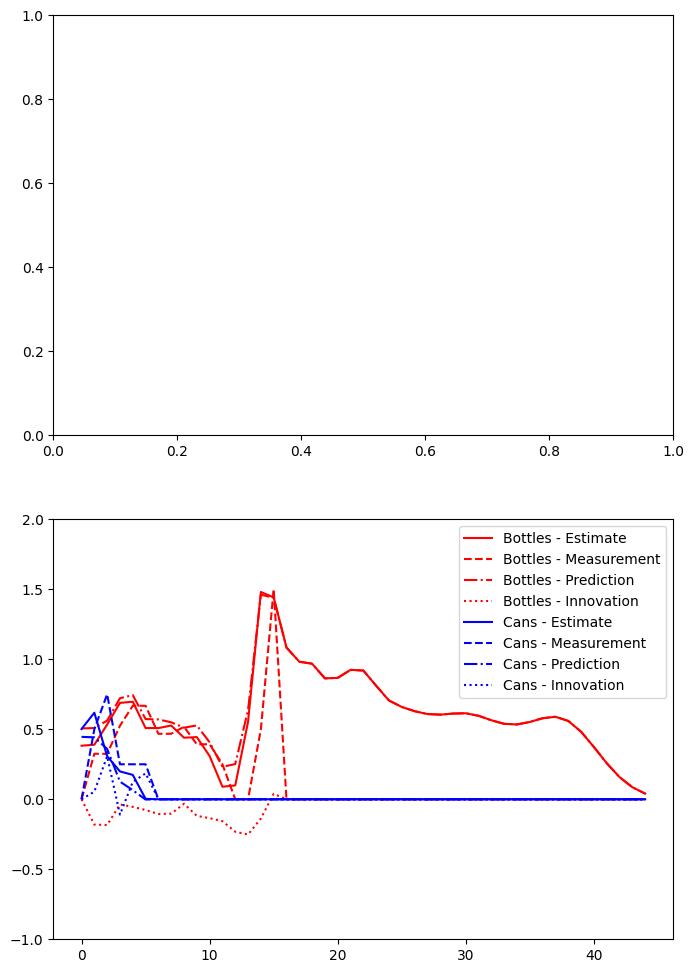

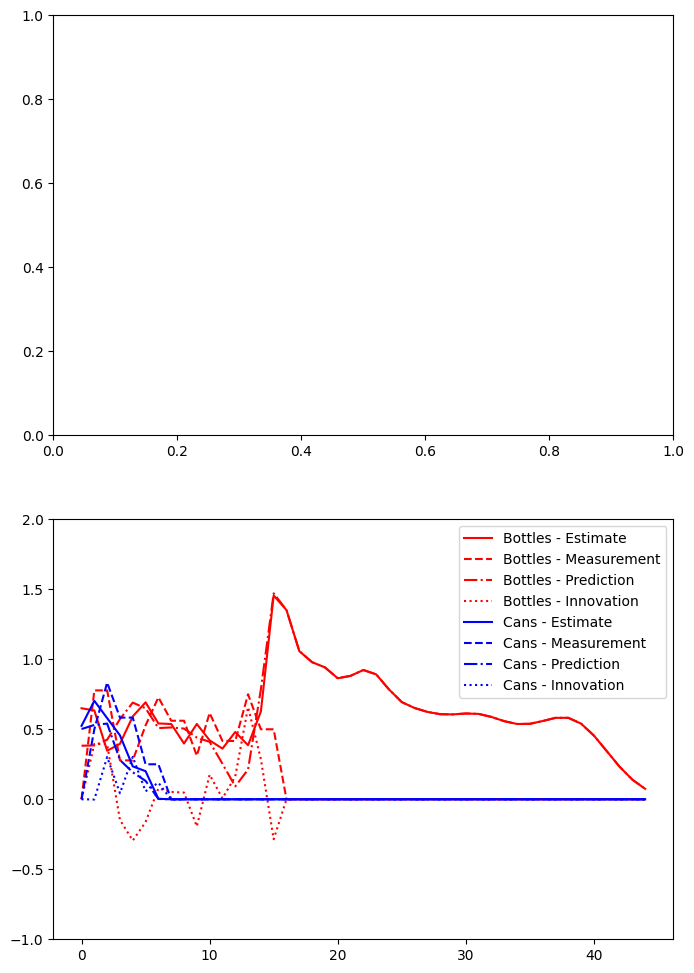

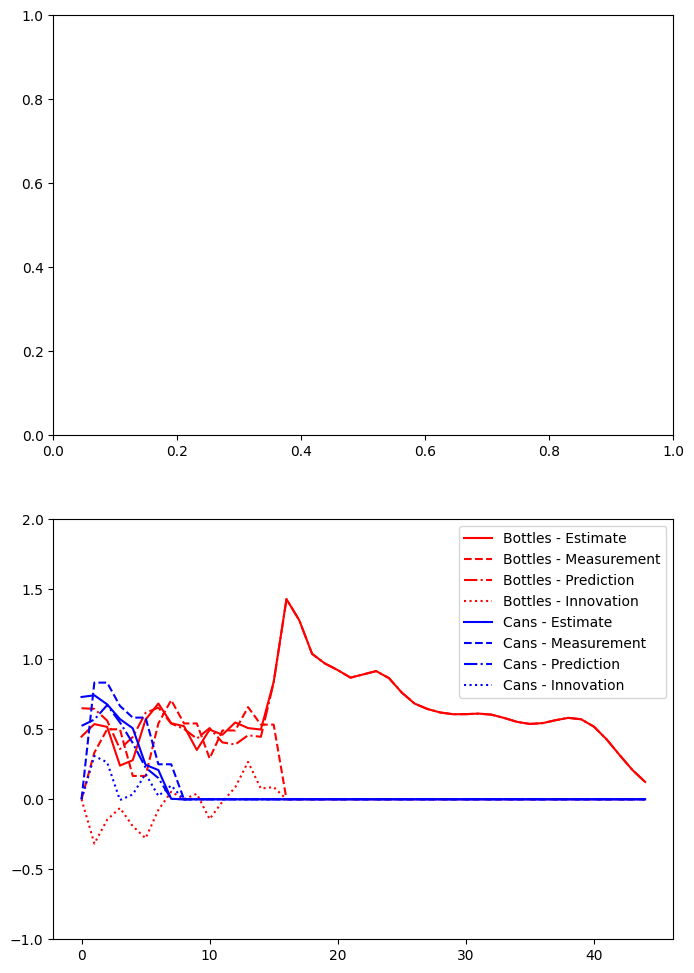

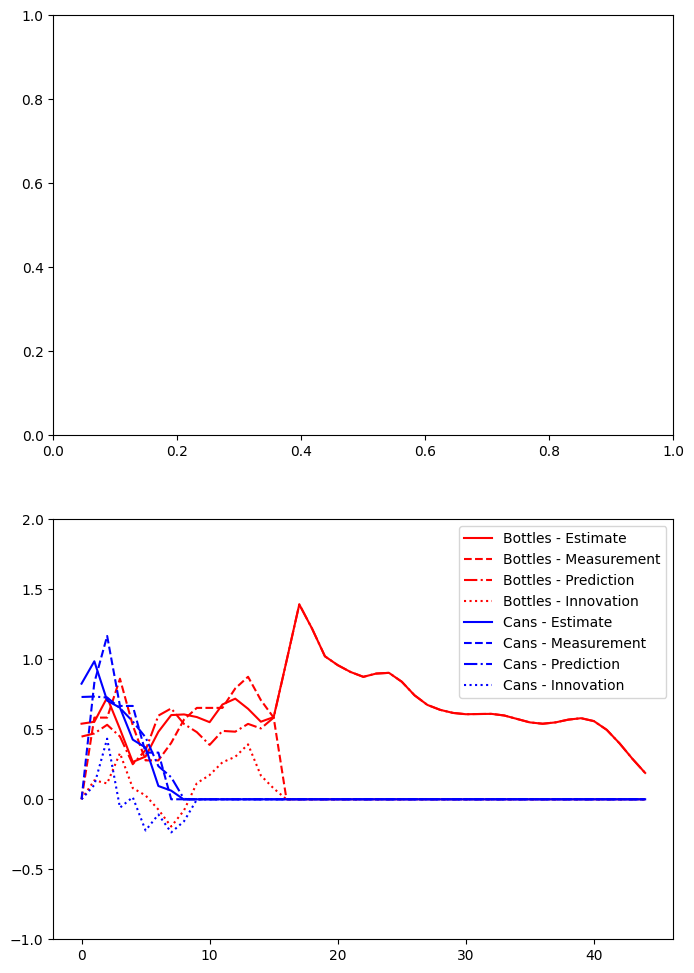

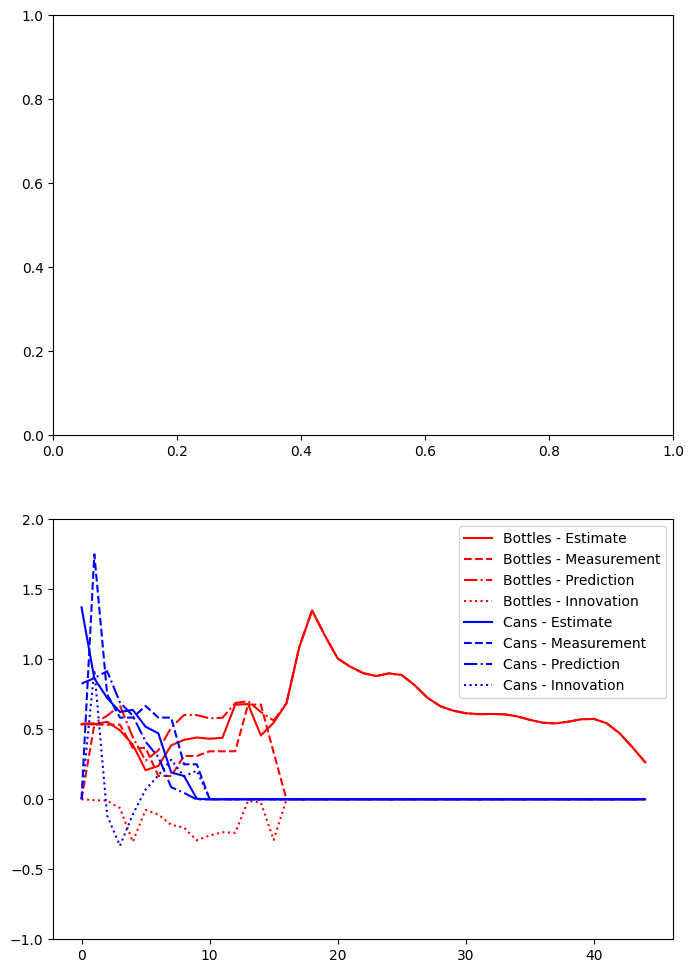

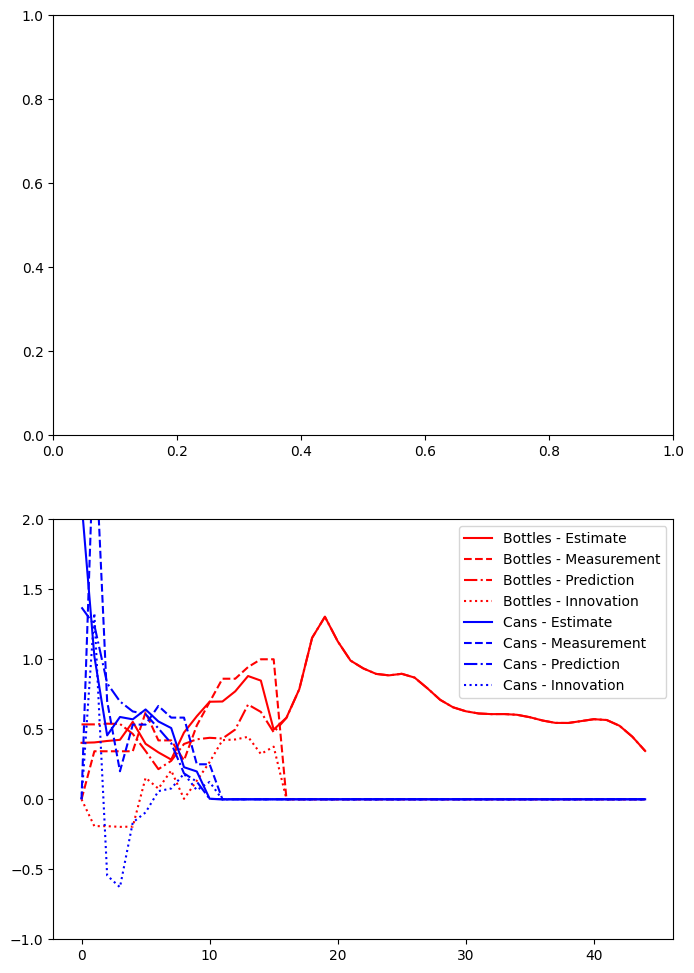

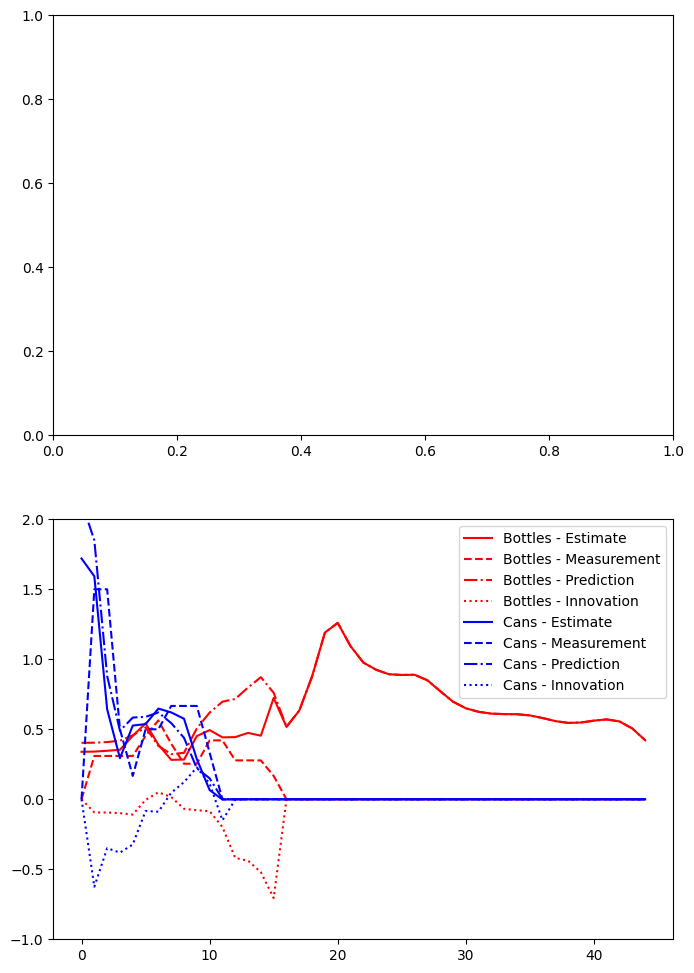

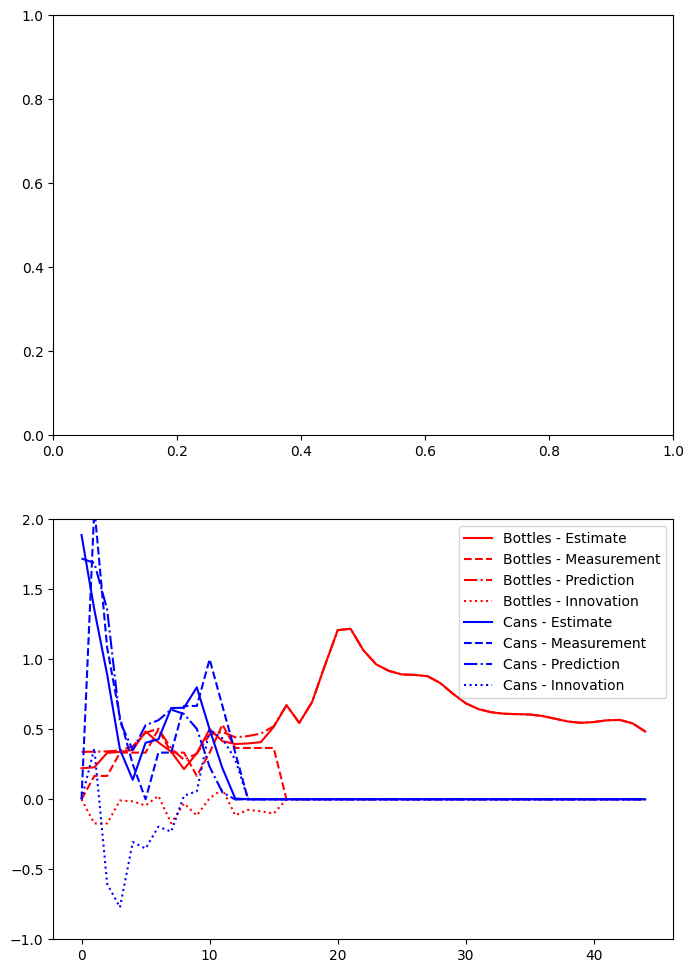

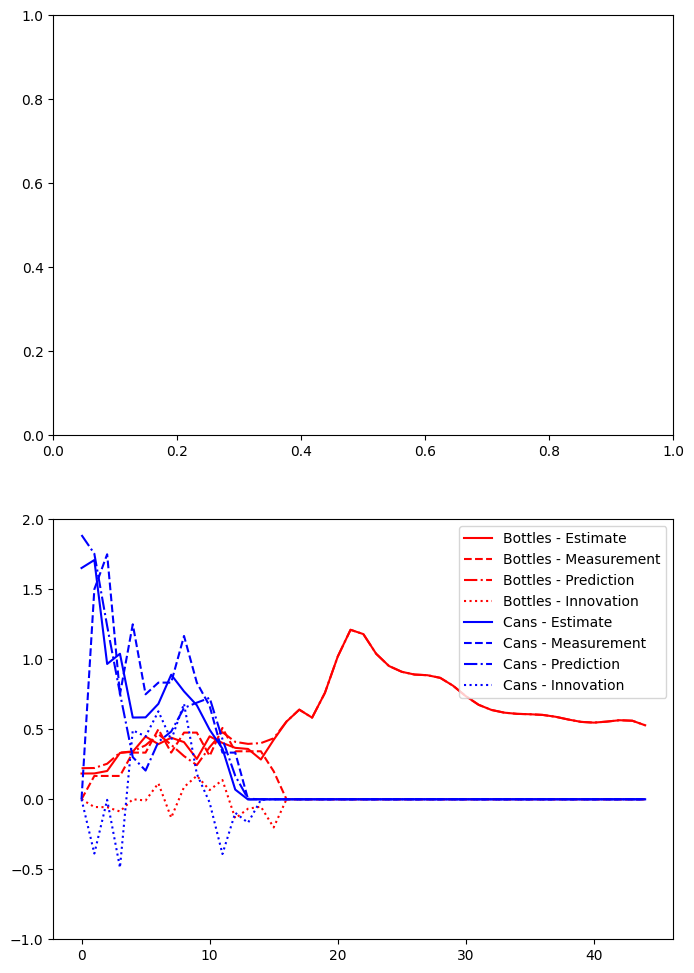

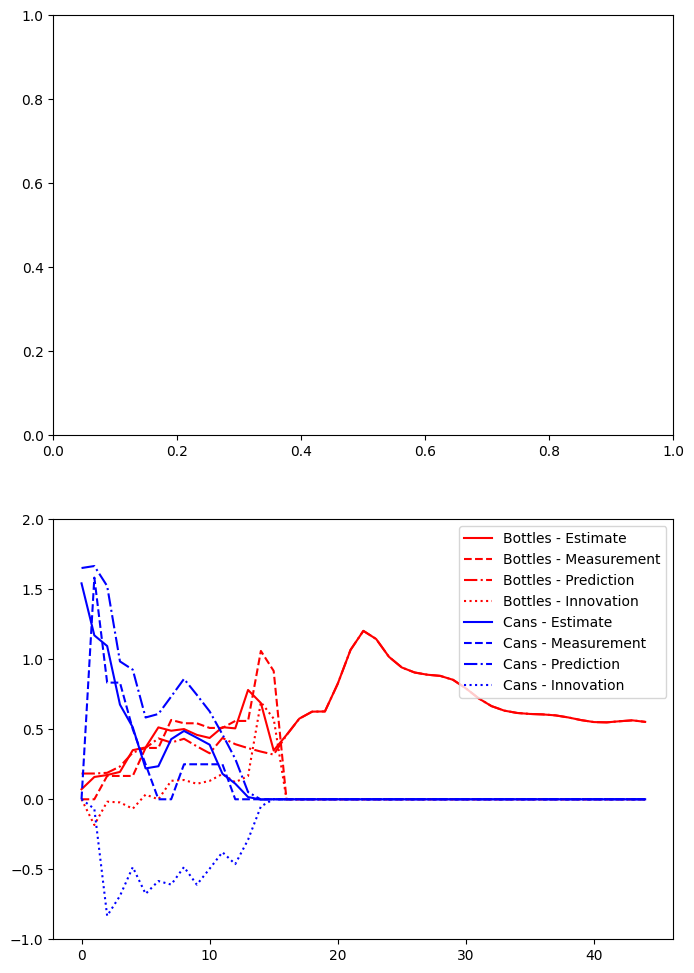

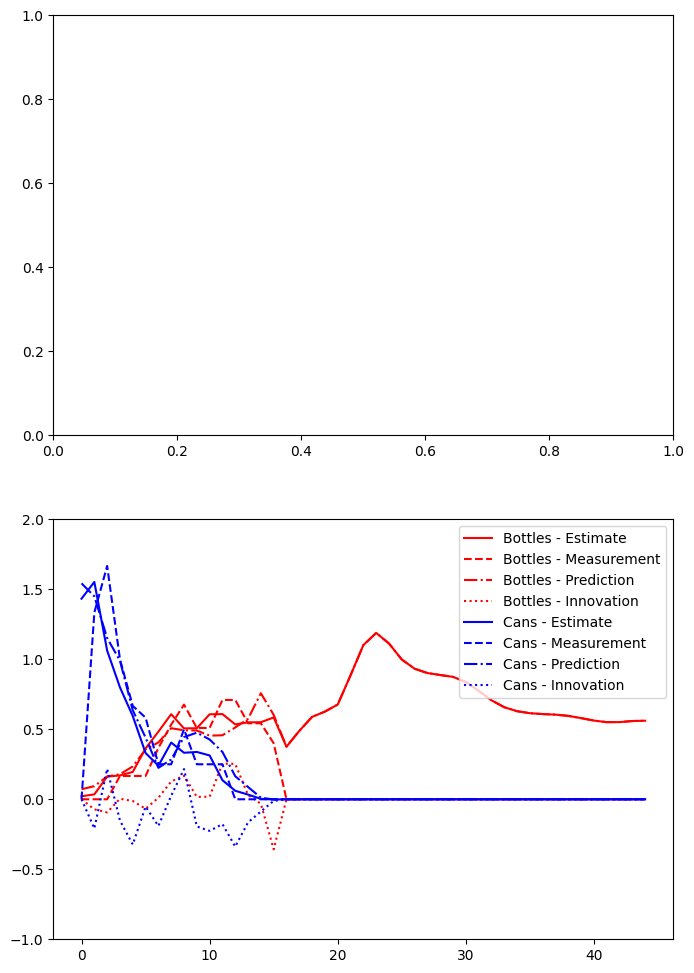

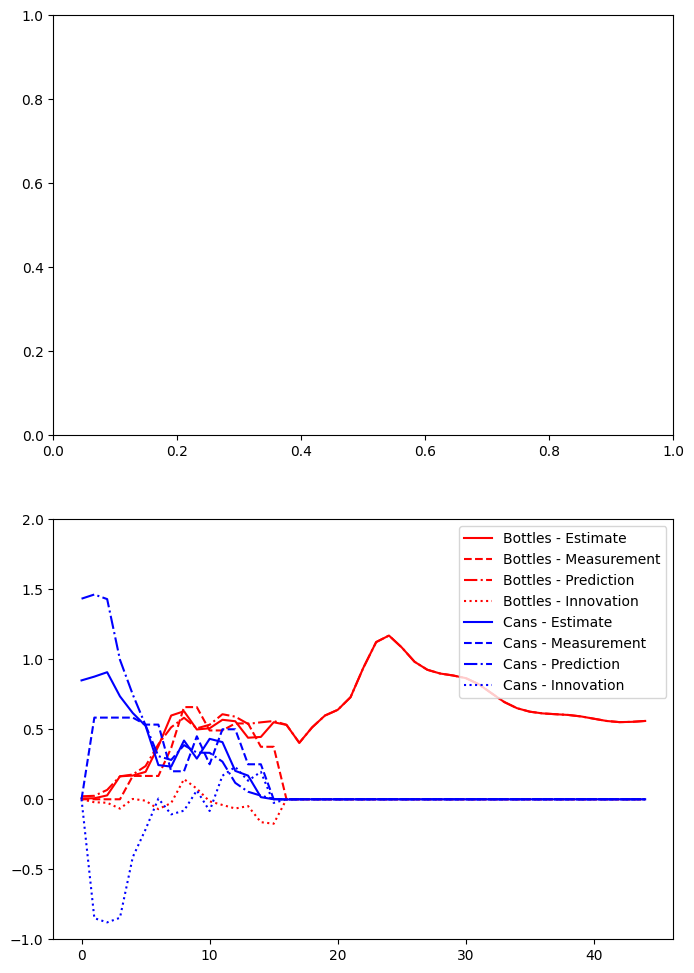

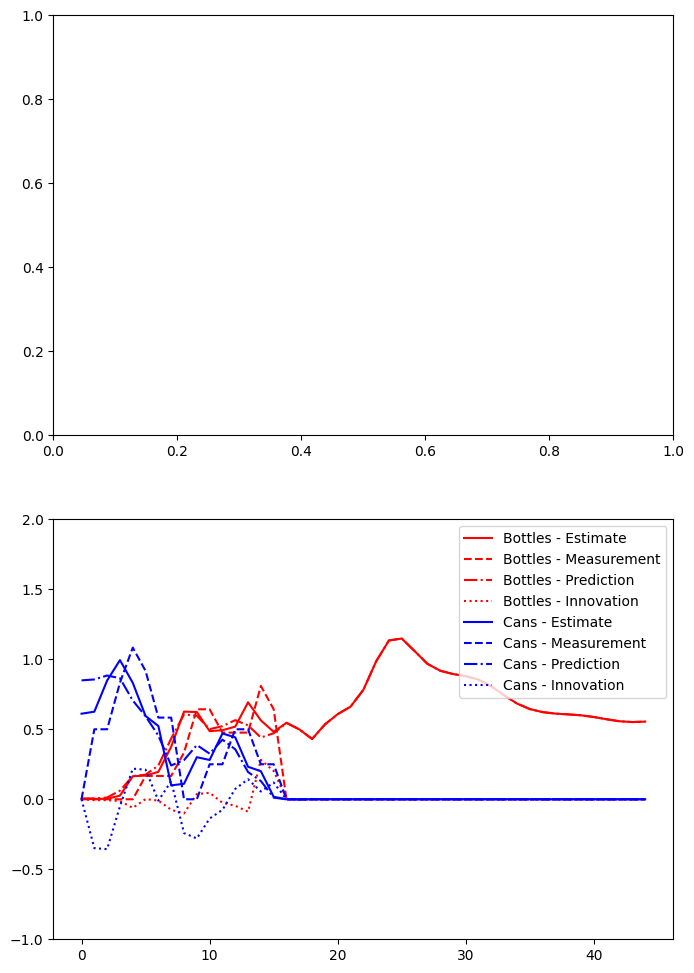

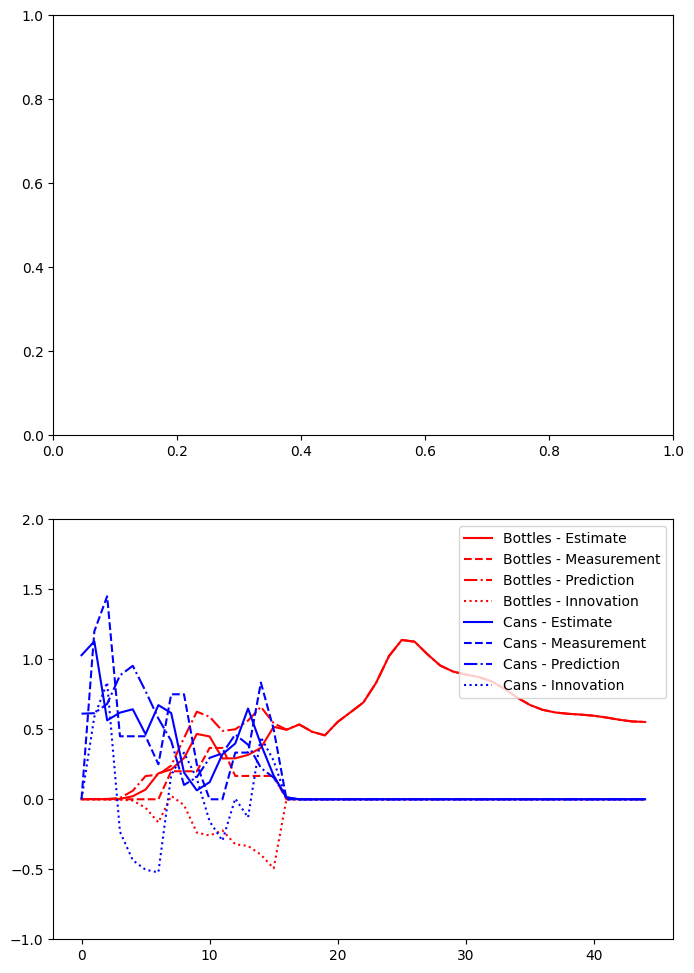

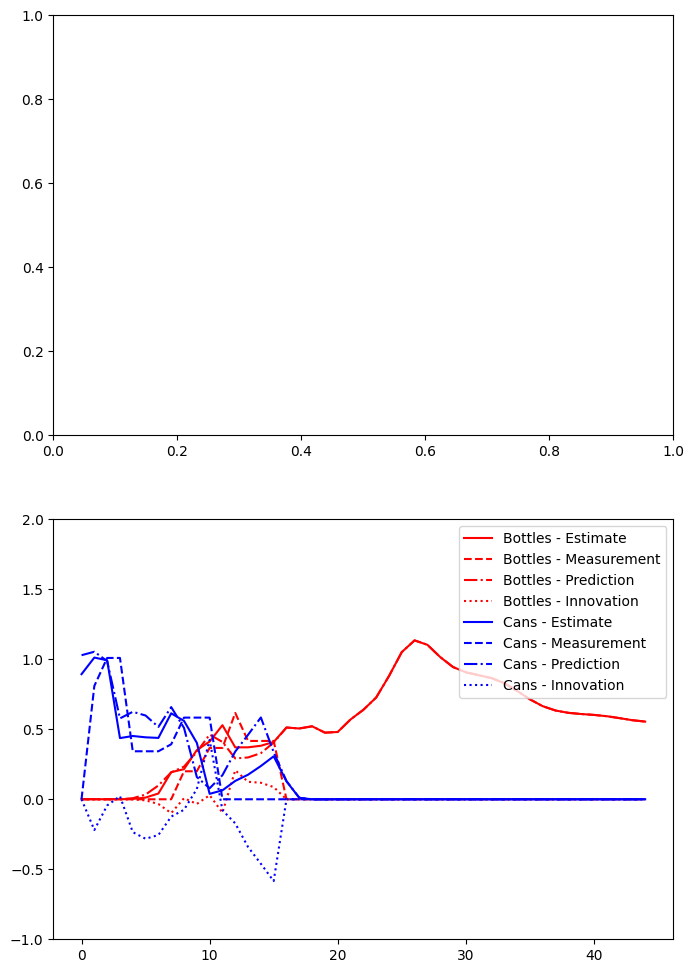

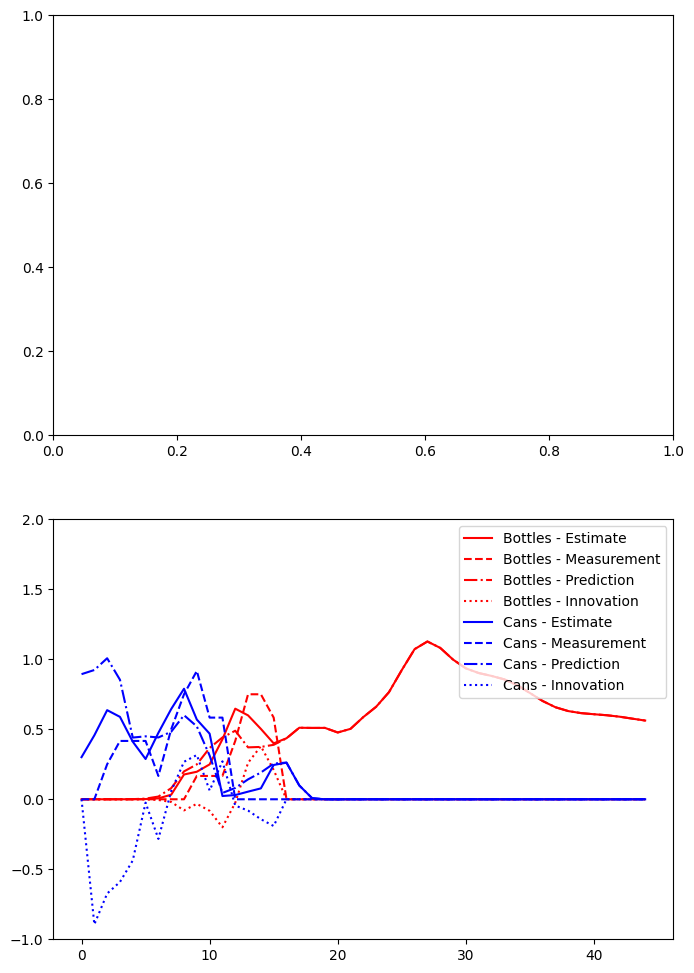

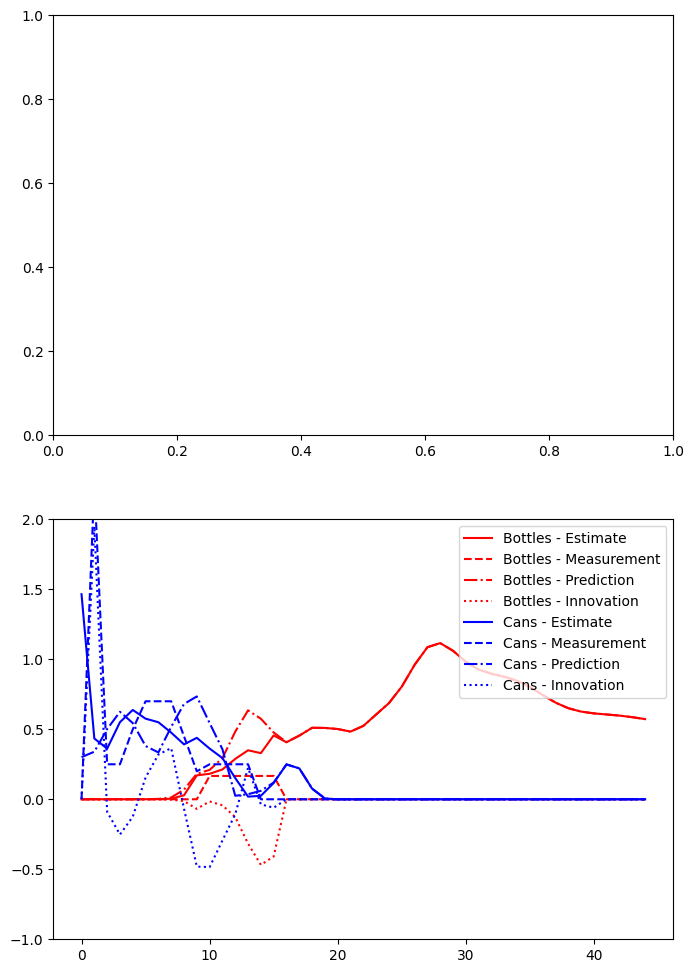

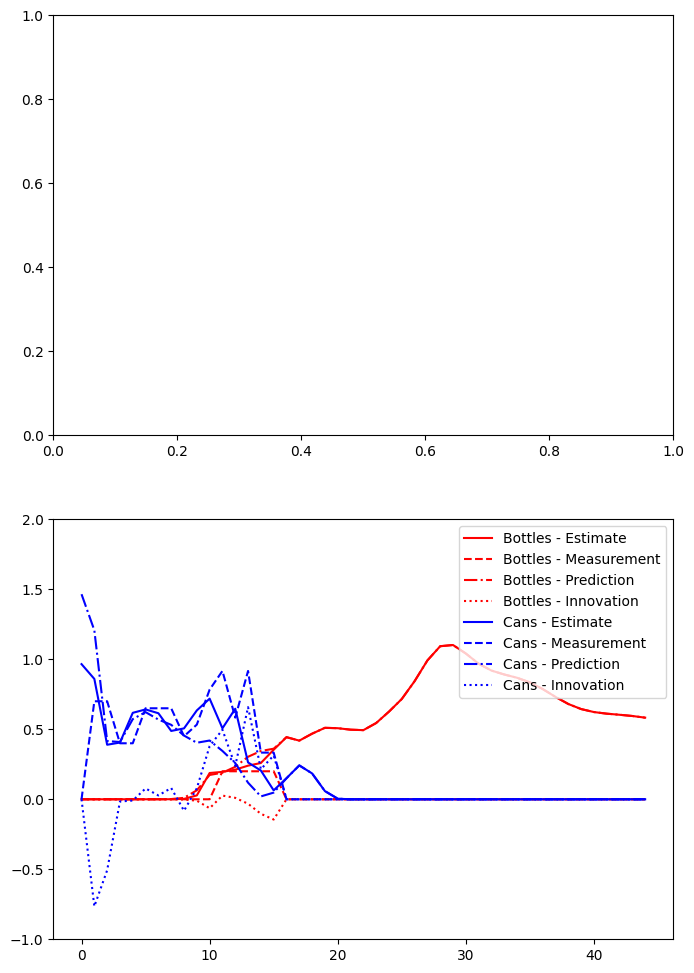

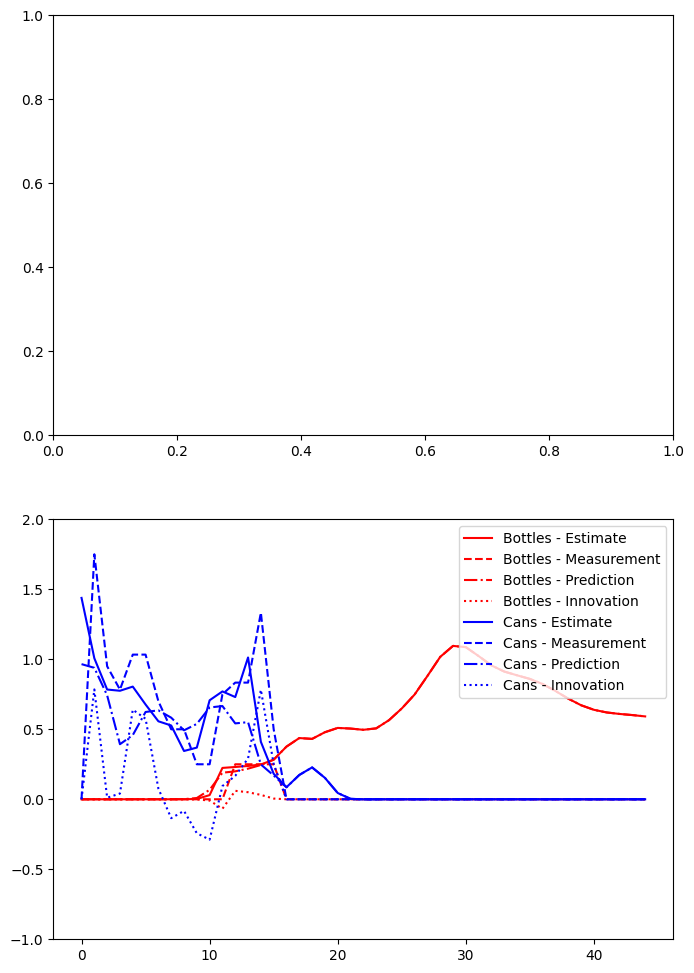

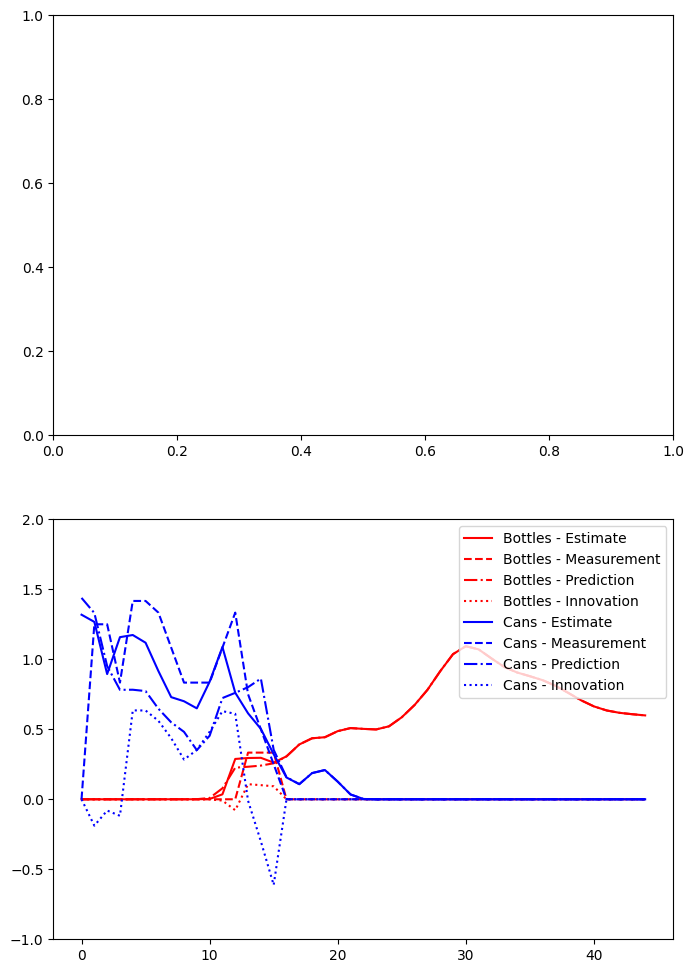

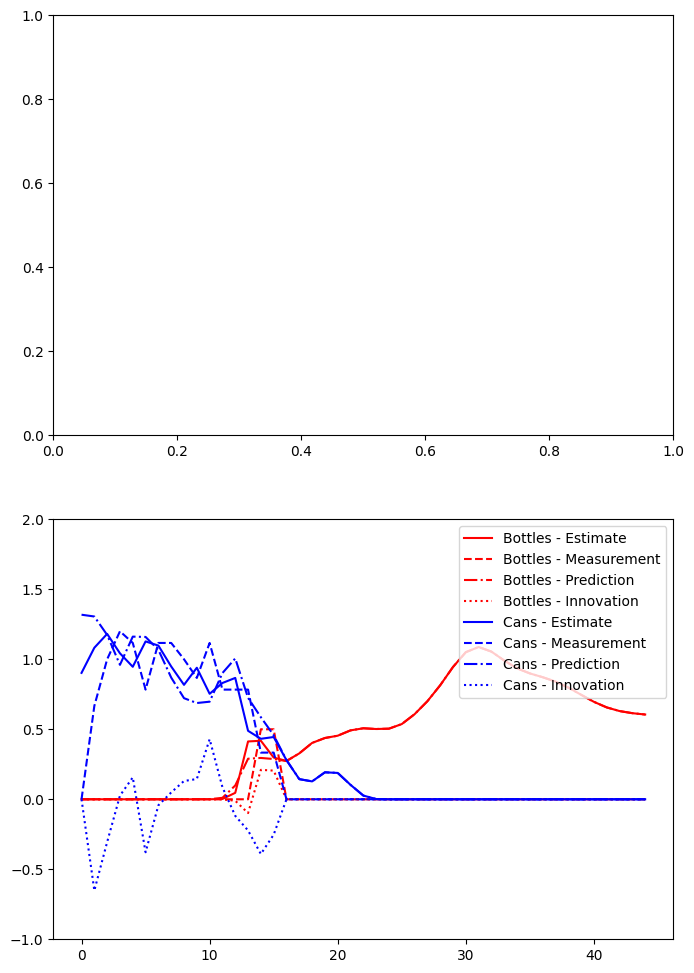

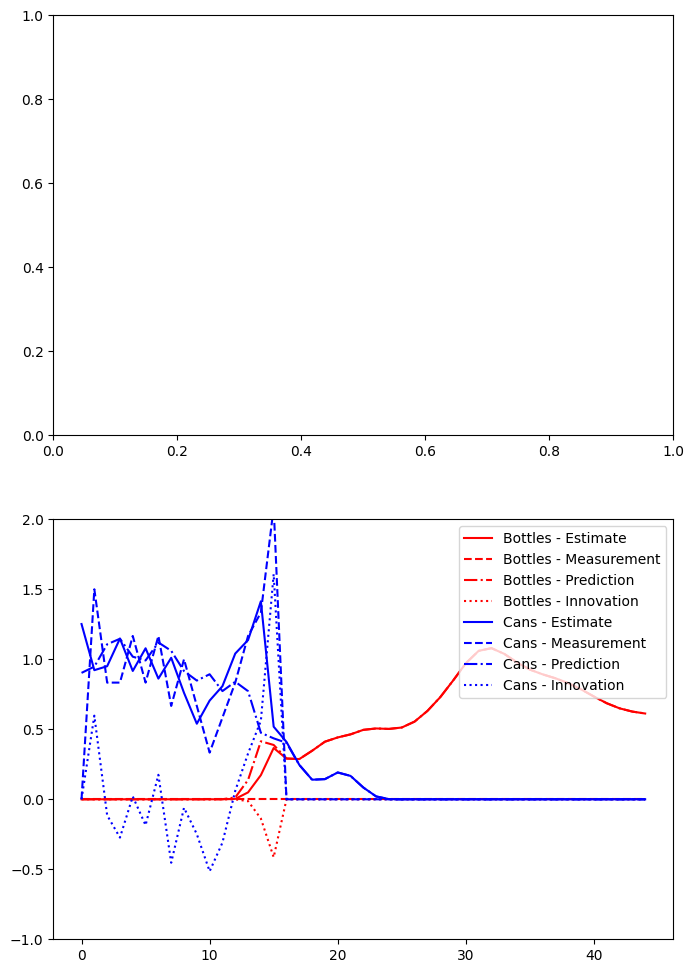

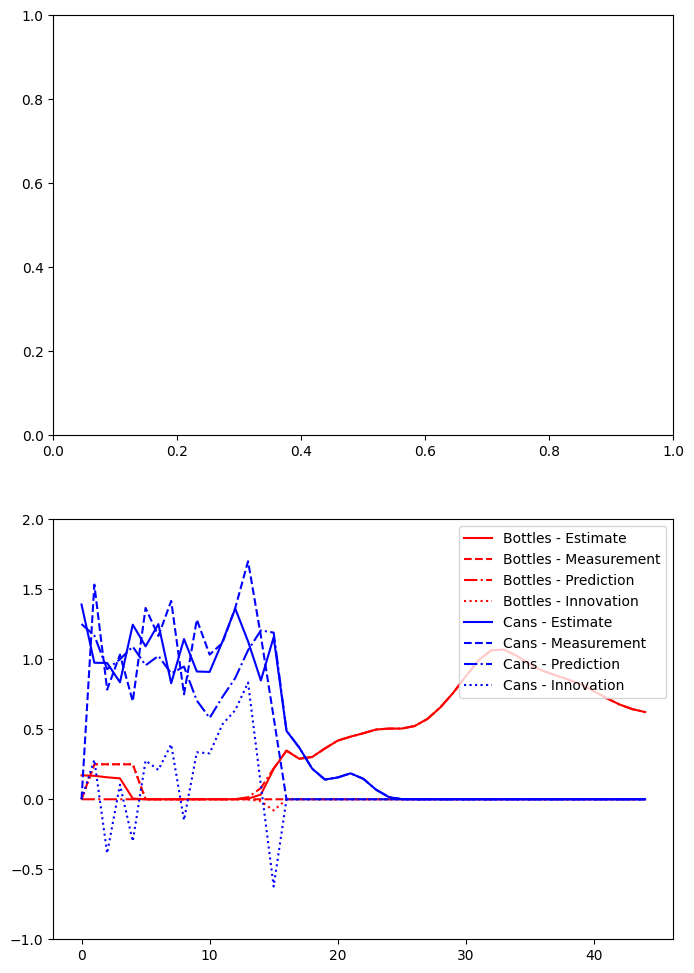

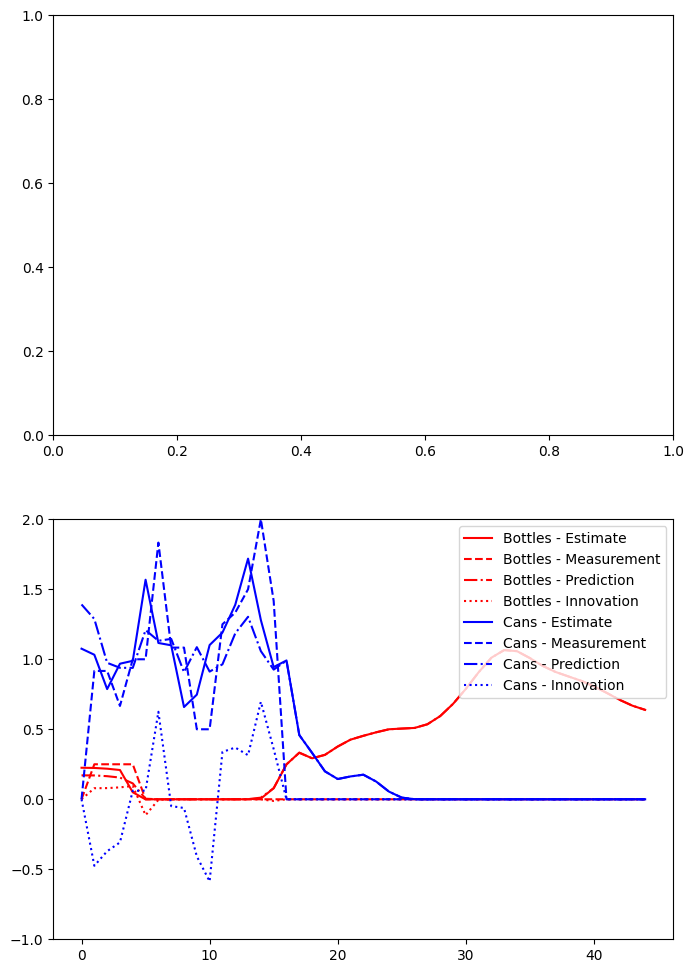

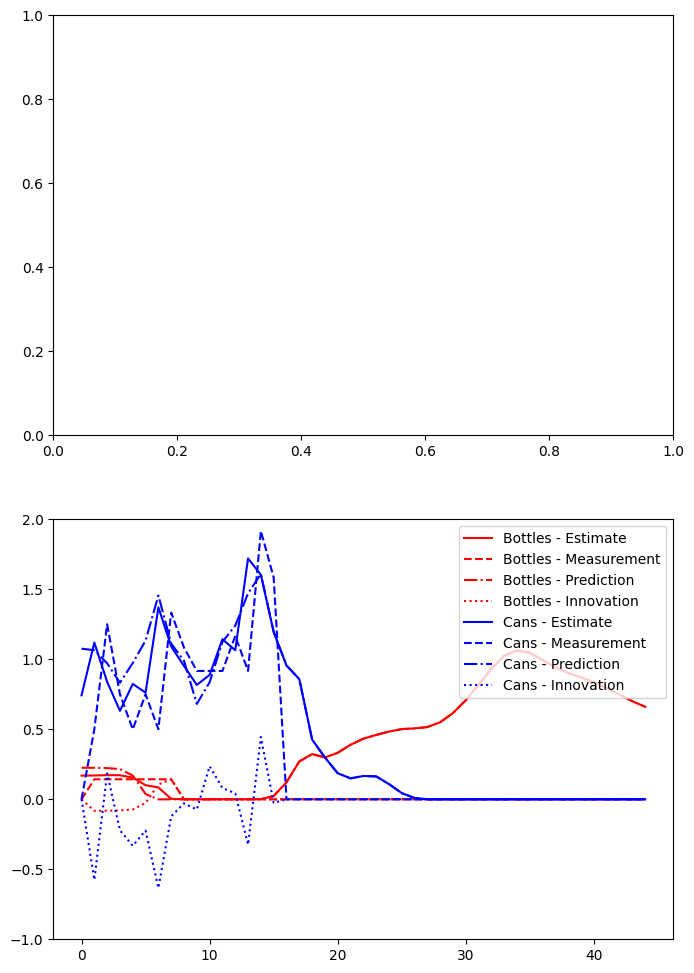

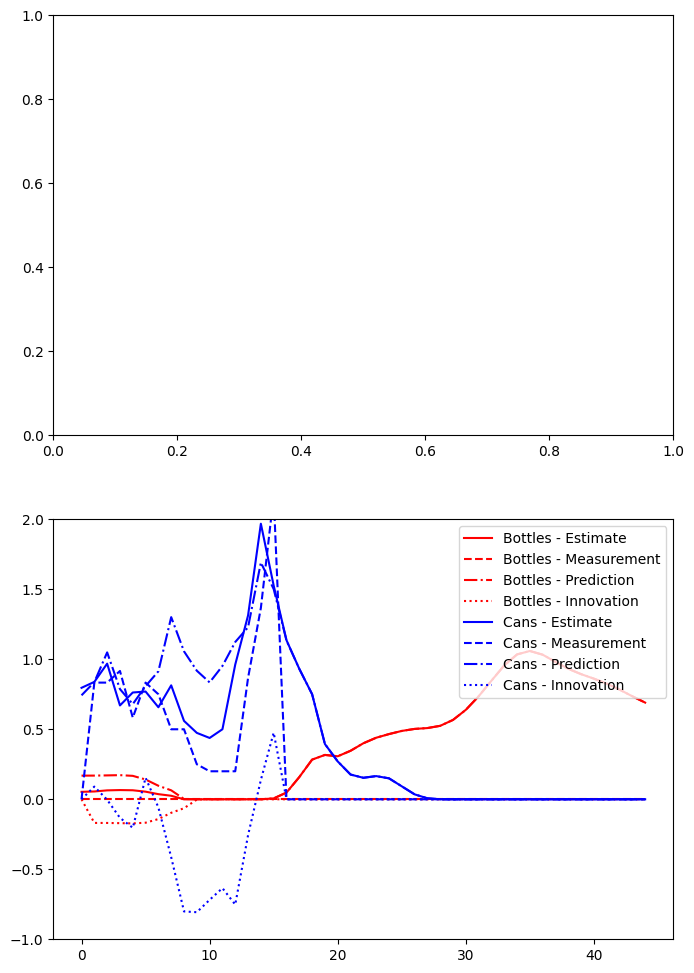

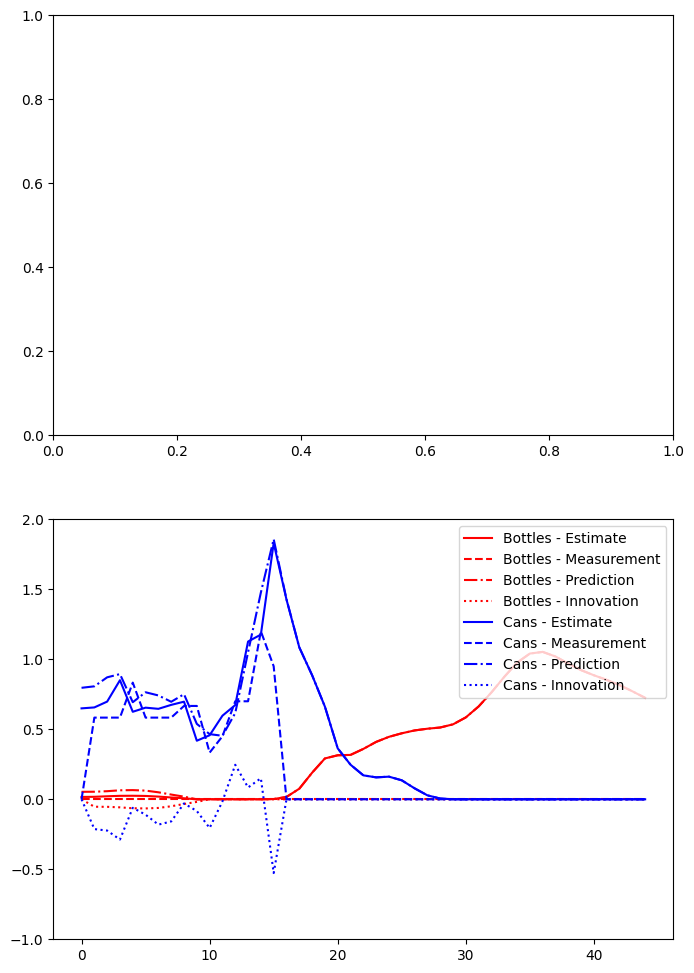

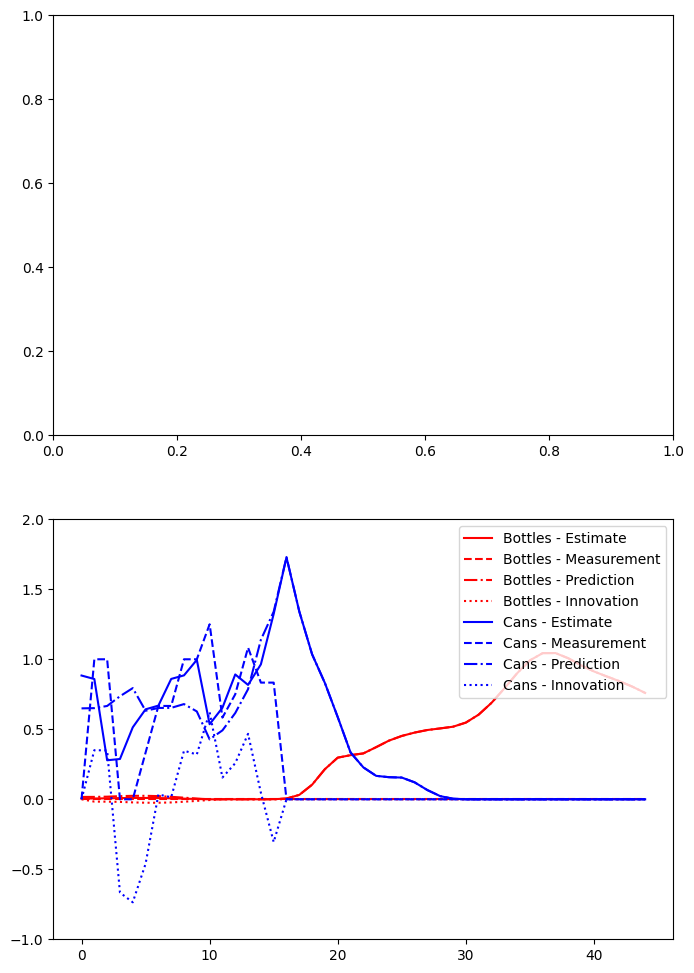

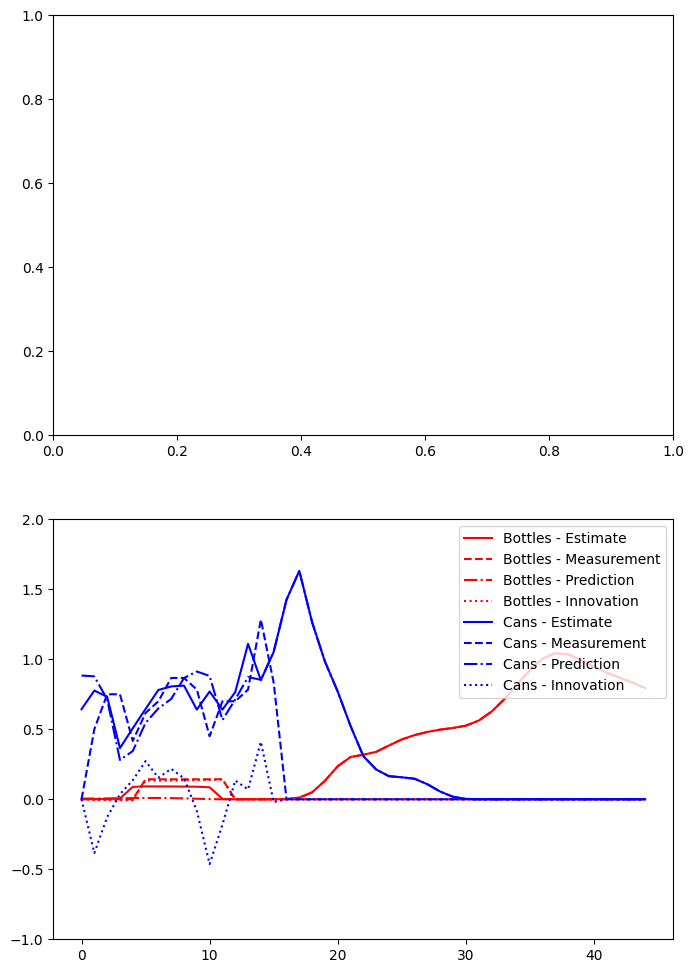

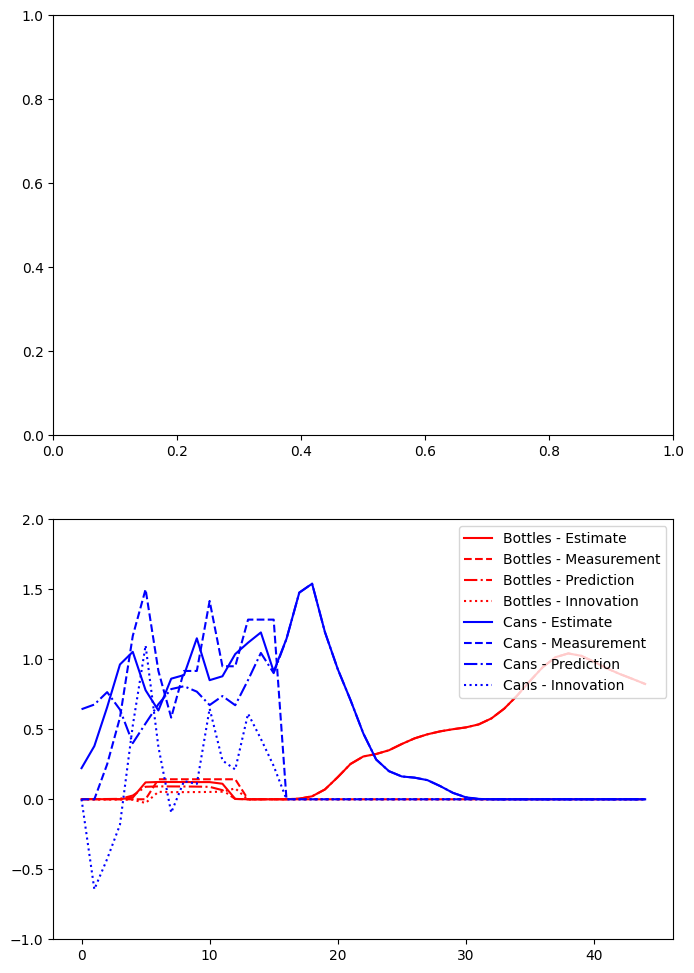

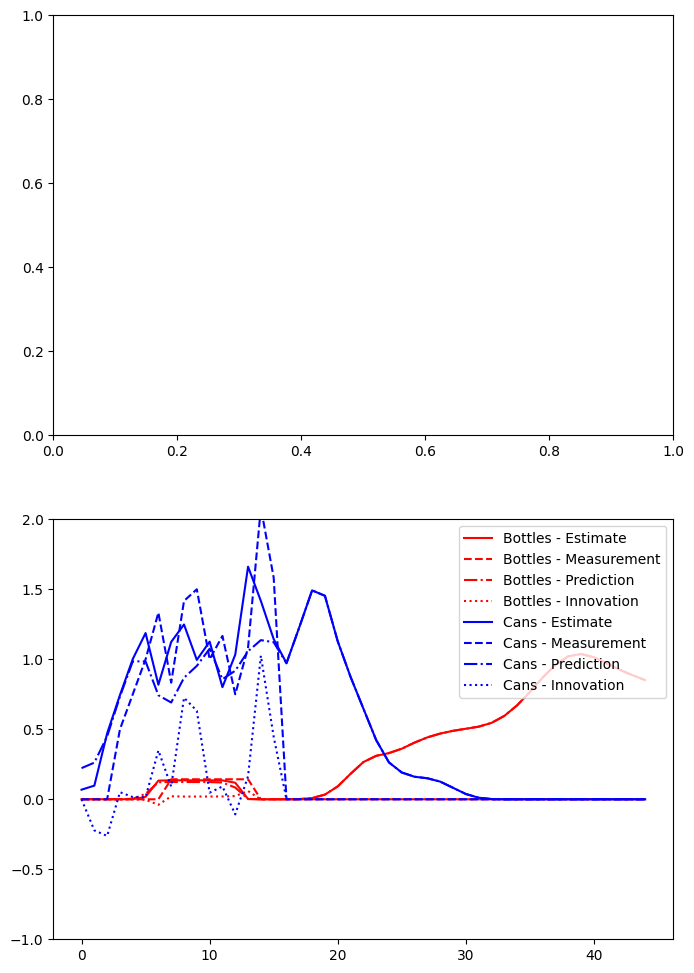

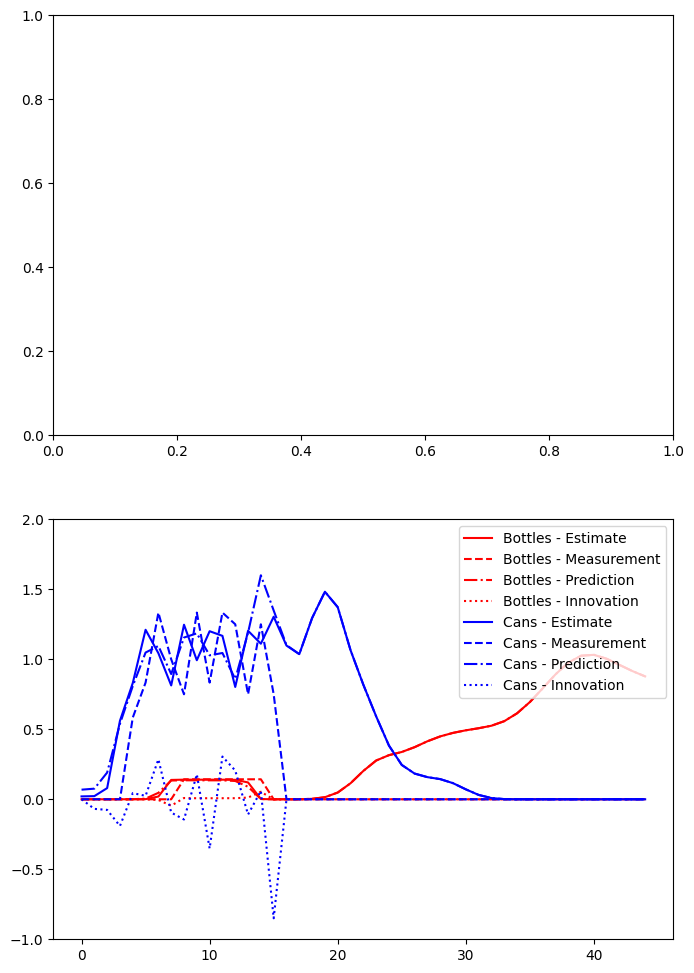

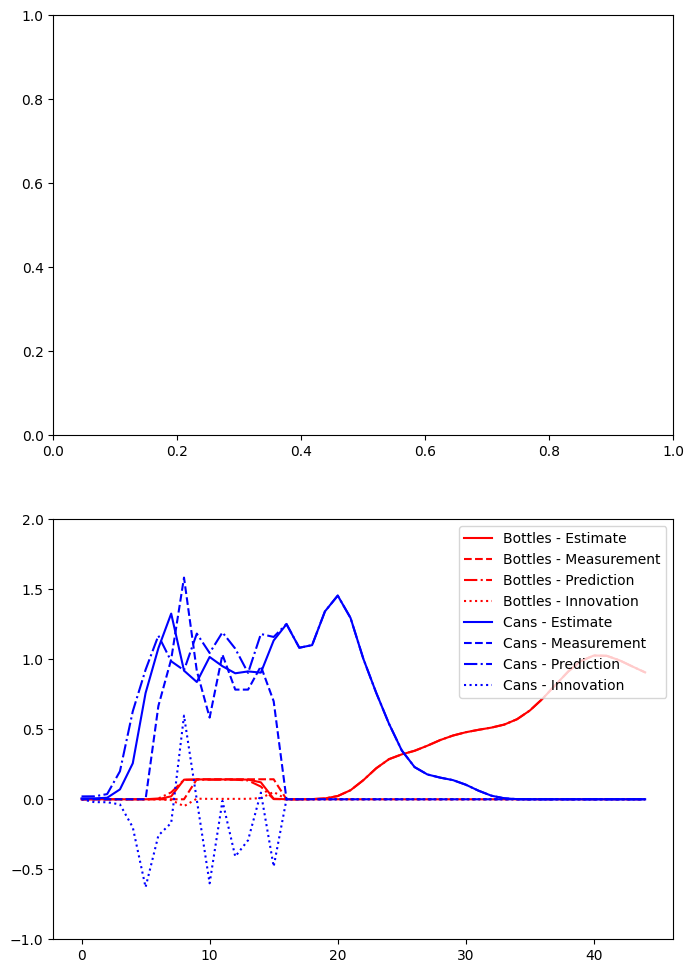

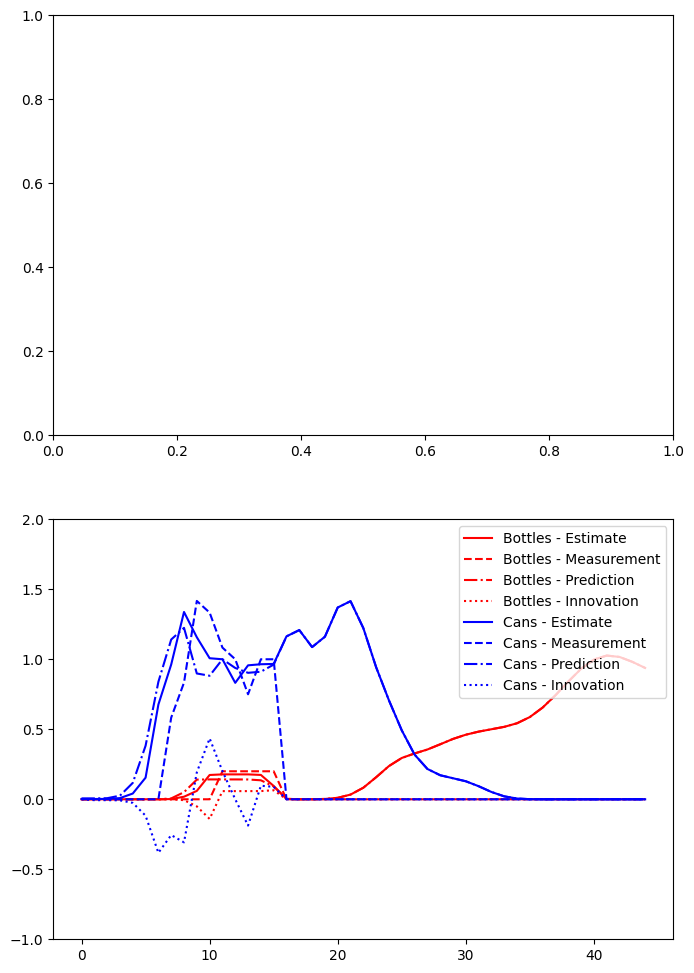

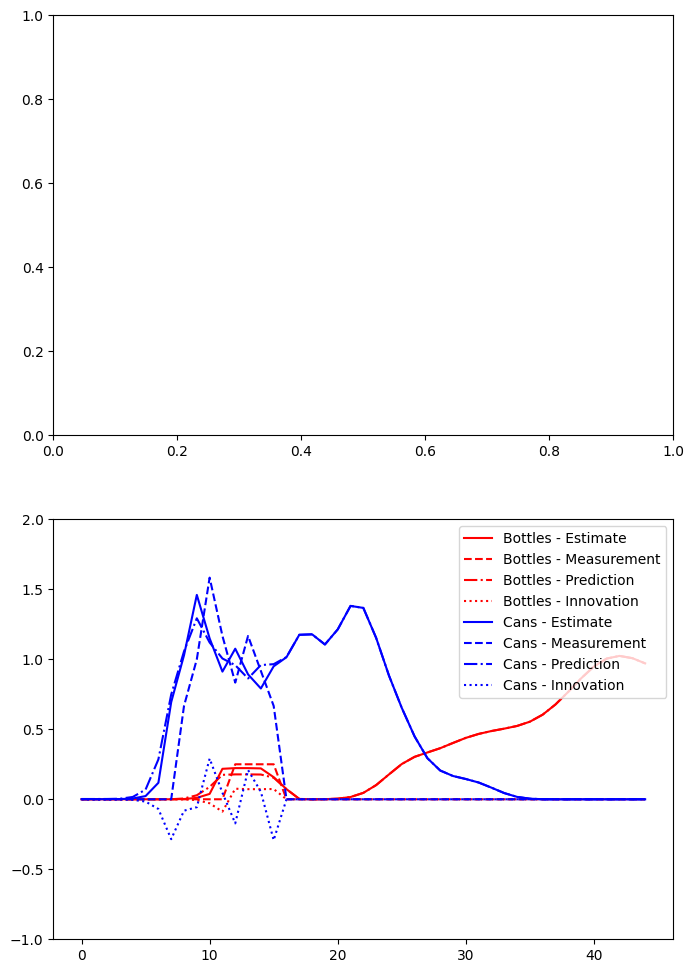

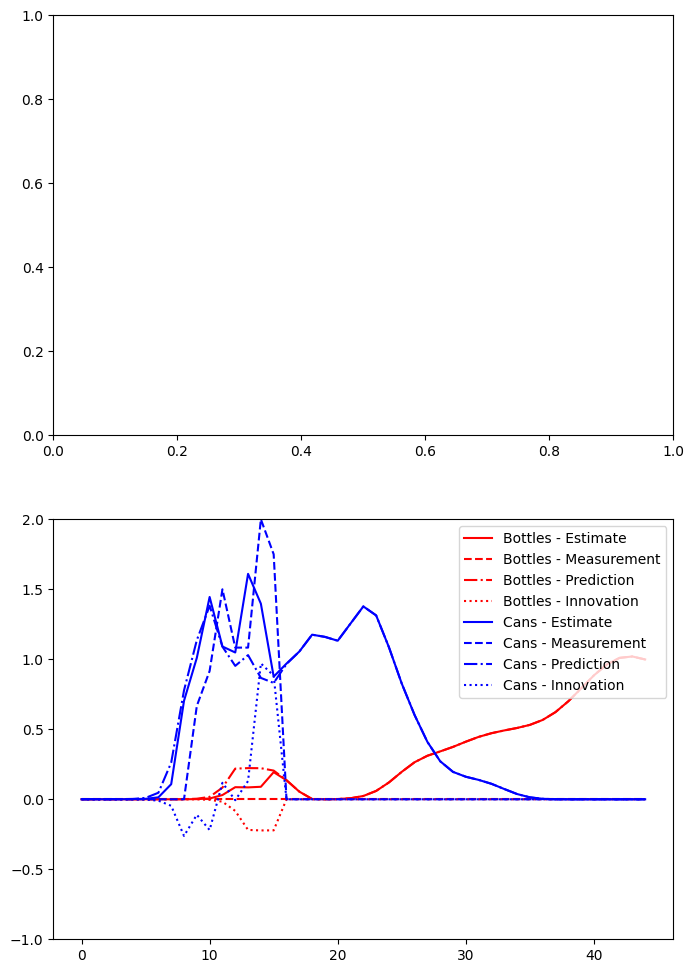

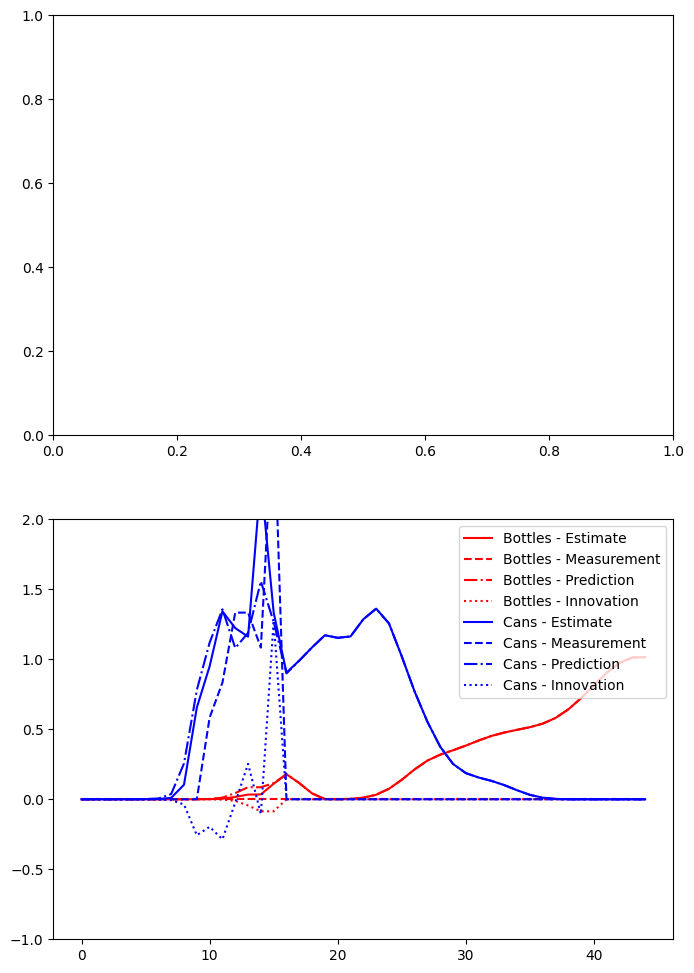

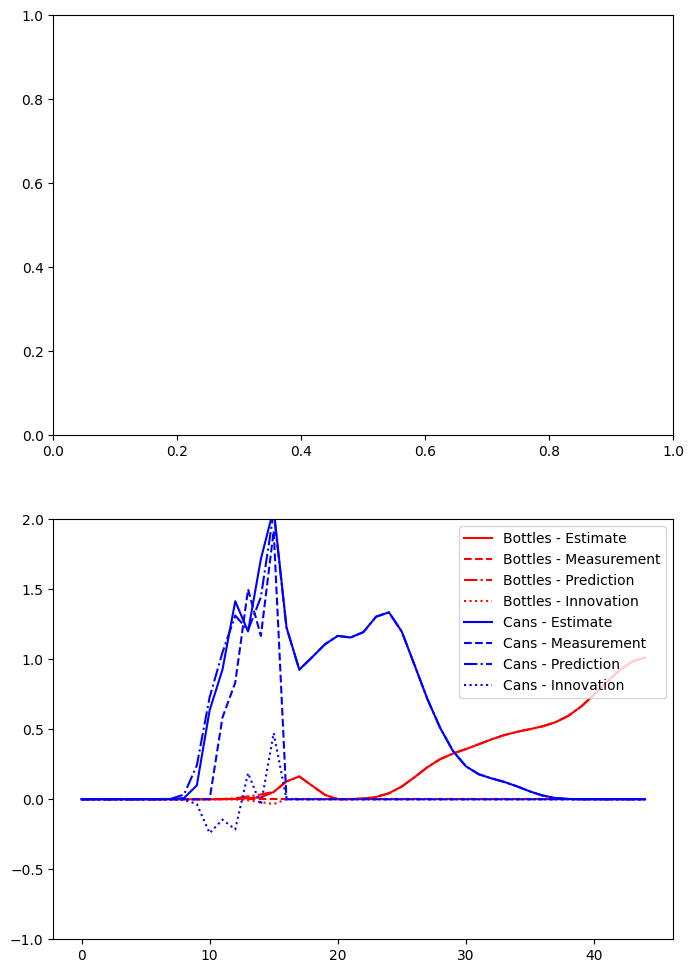

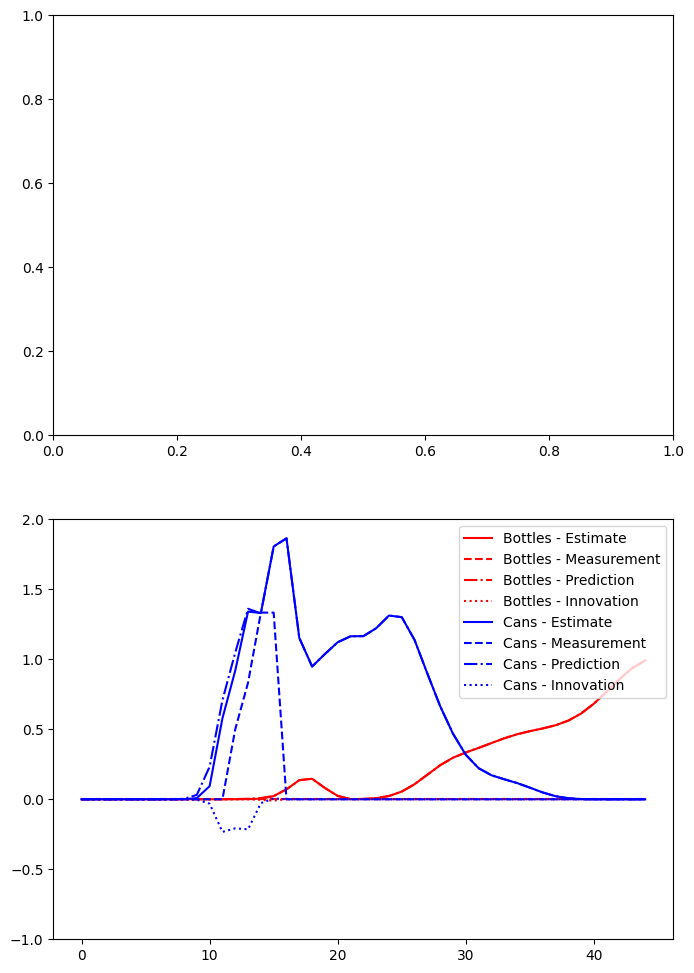

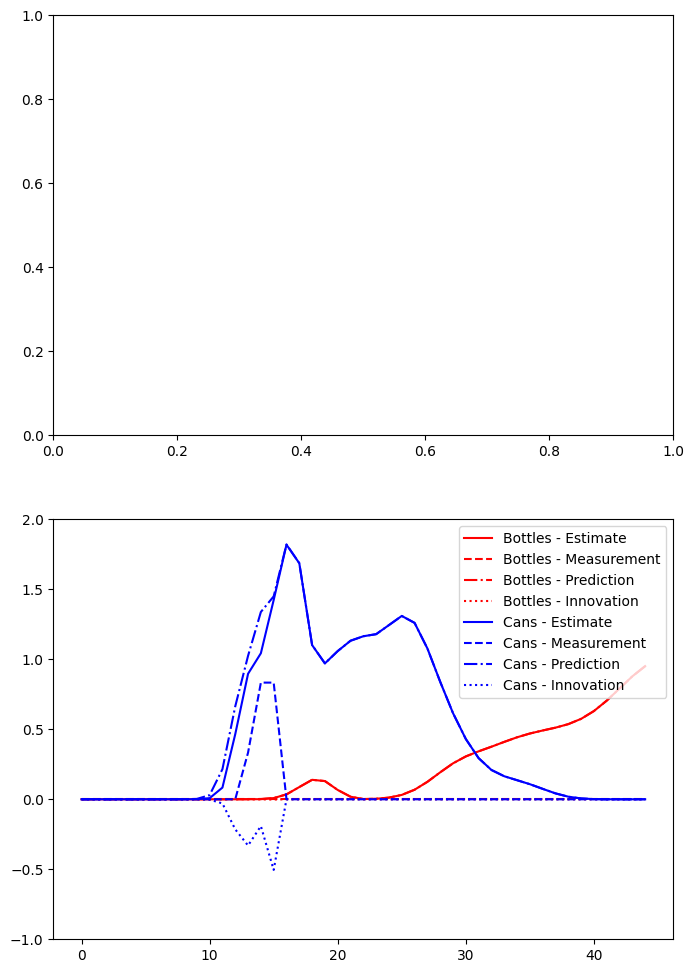

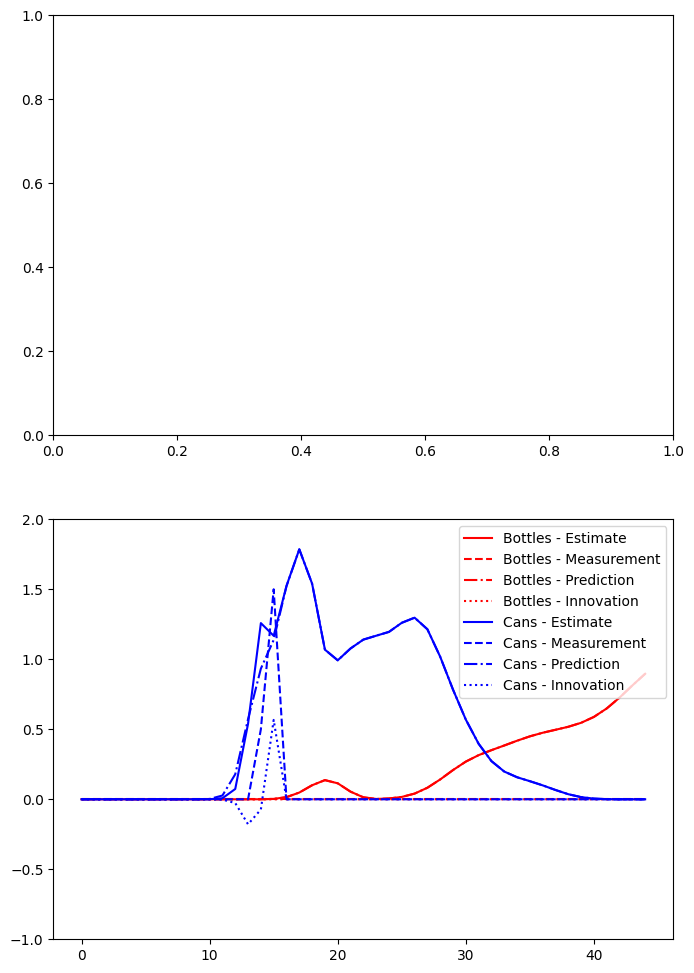

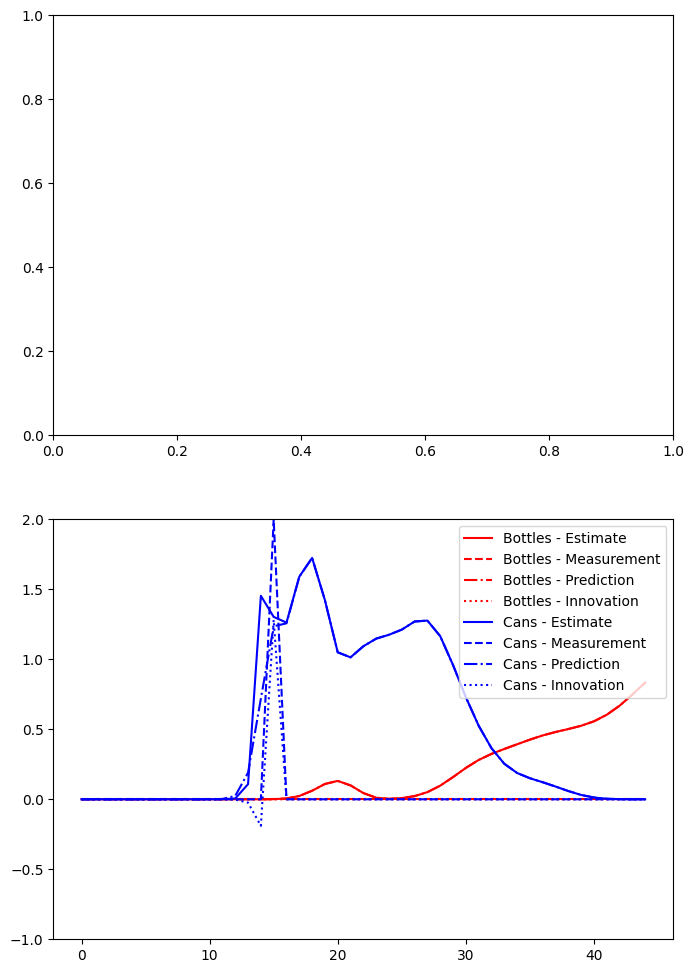

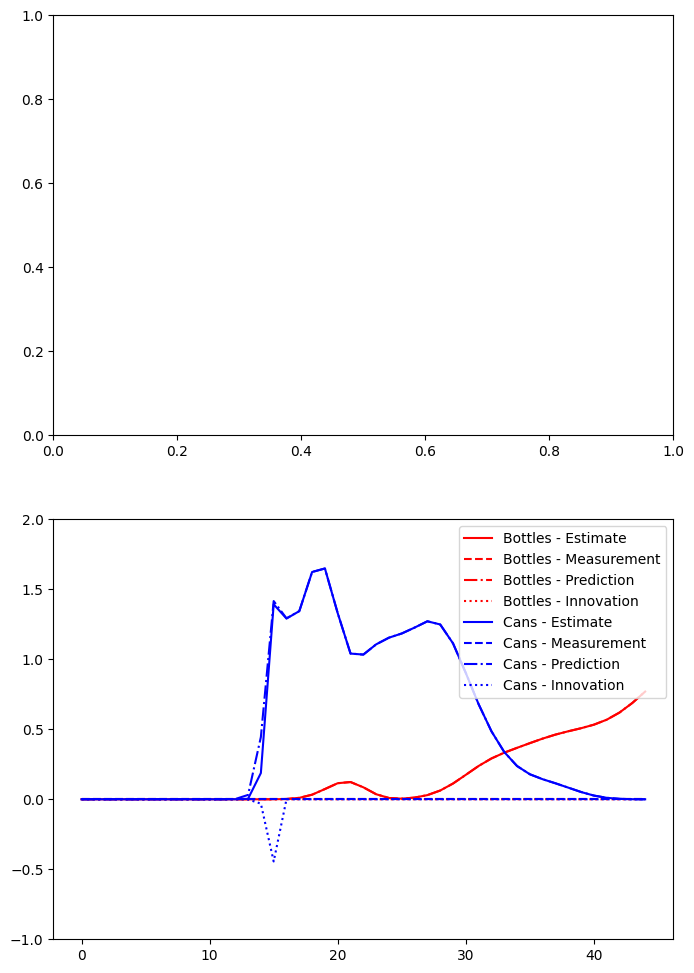

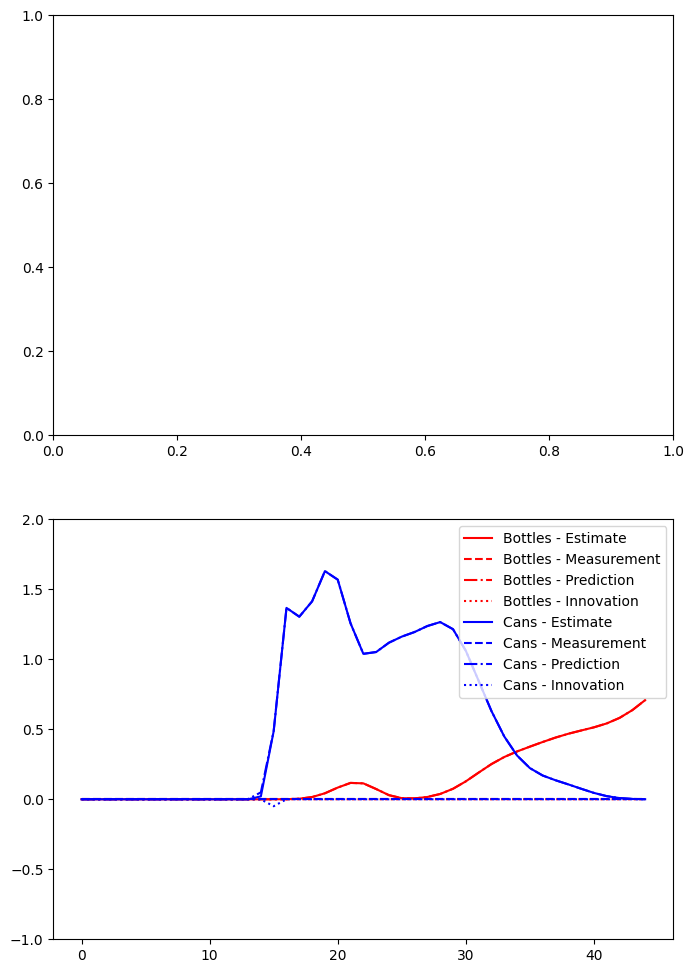

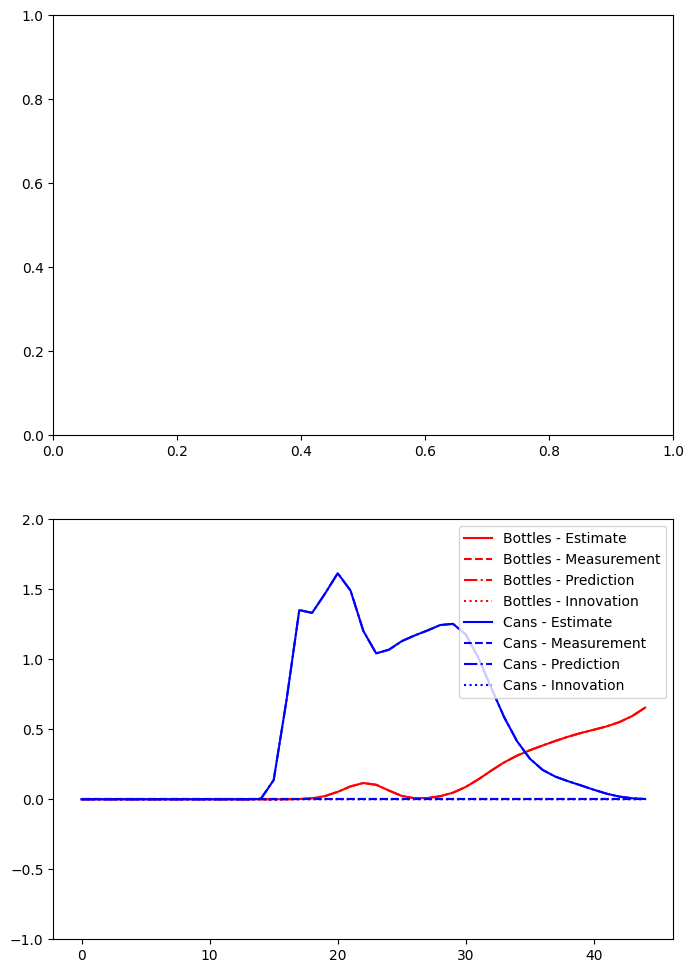

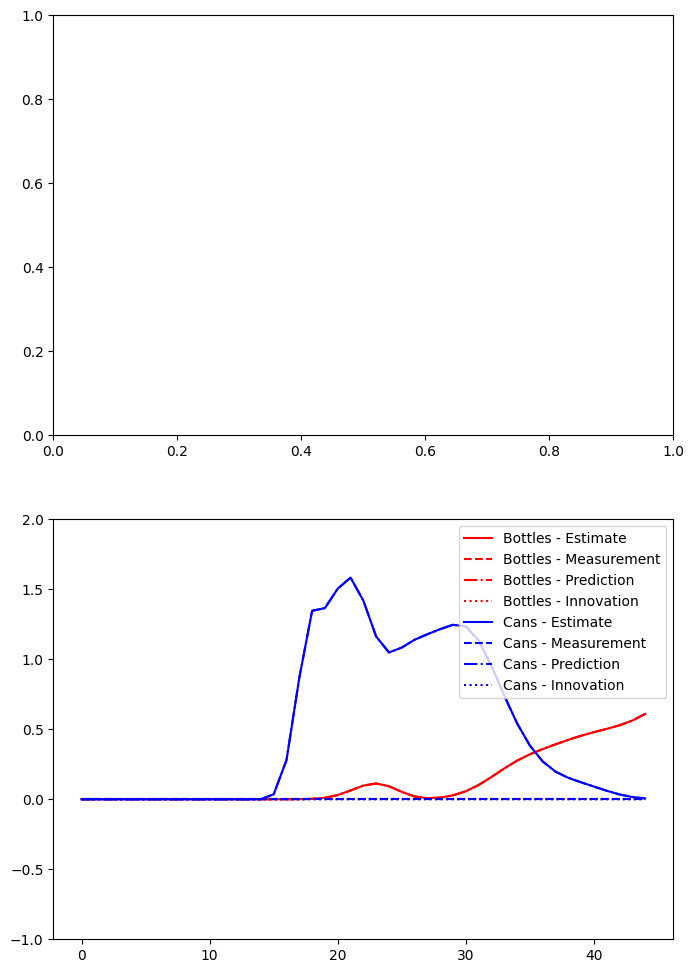

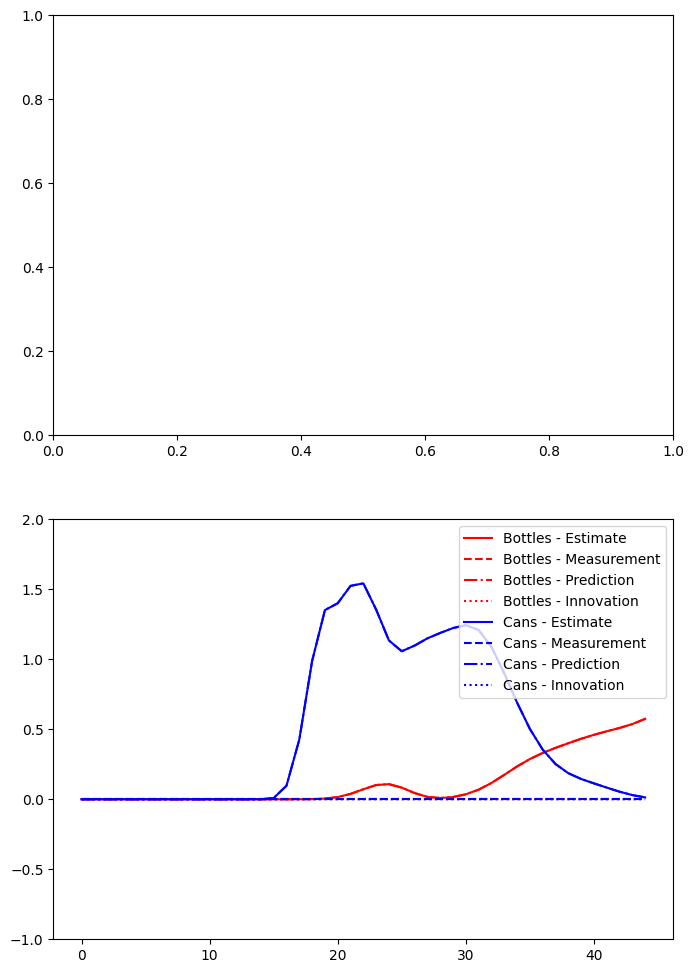

In [171]:

for i in range(len(images)):
    fig, ax = plt.subplots(2, 1, figsize=(8, 12))
    
    # ax[0].imshow(images[i]*im_mask)
    # ax2 = ax[0].twinx()
    # ax2.ylim
    
    ax[1].plot(vol_ids, ests_disp[i][0], 'r', label='Bottles - Estimate')
    ax[1].plot(vol_ids, cams_disp[i][0], 'r--', label='Bottles - Measurement')
    ax[1].plot(vol_ids, preds_disp[i][0], 'r-.', label='Bottles - Prediction')
    # plt.set_ylim(0, 2)
    ax[1].plot(vol_ids, inn_disp[i][0], 'r:', label='Bottles - Innovation')
    
    ax[1].plot(vol_ids, ests_disp[i][1], 'b', label='Cans - Estimate')
    # plt.set_ylim(0, 2)
    ax[1].plot(vol_ids, cams_disp[i][1], 'b--', label='Cans - Measurement')
    
    ax[1].plot(vol_ids, preds_disp[i][1], 'b-.', label='Cans - Prediction')
    
    
    
    
    ax[1].plot(vol_ids, inn_disp[i][1], 'b:', label='Cans - Innovation')
    ax[1].legend(loc="upper right",)
    ax[1].set_ylim(-1, 2)
    name = 'plot_' + str(i)
    fig.savefig(name)
    print(i)

In [155]:
for i in range(3):
    print(i)

0
1
2


In [34]:
%matplotlib qt